## Process txt files

In [ ]:
!pip install pandas


In [2]:
import codecs

In [ ]:
# must run
import xml.etree.ElementTree as xml_parser
import re
import tarfile
from tqdm.auto import tqdm
import json
import os,codecs
from time import sleep
import pandas as pd
import urllib.request as ur
from random import randint



# test download one file 
# !wget ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/5f/a6/PMC7102175.tar.gz

# must run
def get_id_list_by_year_season(year, season=1):

    '''
    reldate
    When reldate is set to an integer n, ELink returns only those items that have a date specified by datetype within the last n days.
    # "cerebral palsy"[MeSH Terms] OR ("cerebral"[All Fields] AND "palsy"[All Fields]) OR "cerebral palsy"[All Fields]
    https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=cerebral+palsy[MeSH+Terms]+OR+cerebral+palsy[All+Fields]+AND+Randomized+Controlled+Trial[Publication+Type]

    '''
    #term1 = "(cerebral+palsy[MeSH+Terms]+OR+cerebral+palsy[All+Fields]+AND+Randomized+Controlled+Trial[Publication+Type])"
    #term2 = "(cerebral+palsy[MeSH+Terms]+OR+cerebral+palsy[All+Fields]+AND+randomized+controlled+trial[All+Fields])"
    #term3 = "(randomized+controlled+trial[All+Fields])"
    #term3 = "(Randomized+Controlled+Trial[Publication+Type])"
    term4 = "(Observational+Study[Publication+Type])"
    term5 = "(Observational+Study%2C+Veterinary[Publication+Type])"
    term6 = term4 + "||" + term5
    term7 = "(Case+Reports[Publication+Type])"
    term8 = "(ffrft[Filter])"
    term9 = "+AND+(humans[Filter])+AND+(english[Filter])"
    term10 = term7 + '+AND+' + term8 + term9
    baseURL = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    #filter=pubt.randomizedcontrolledtrial
    #Randomized Controlled Trial[Publication Type]

    reldate=None
    eutil = 'esearch.fcgi?'
    dbParam = 'db=pubmed'#db=pubmed, db=pmc
    usehistoryParam = '&usehistory=y'
    retmode = '&retmode=JSON'
    eutilfetch = 'efetch.fcgi?'
    fieldParam = '&field=title'
    termParam = '&term='+ str(term10)
    reldateParam = '&reldate='+ str(reldate)+'&datetype=edat'
    if season==1:
        mindate='&mindate='+str(year)+'/01/01'
        maxdate='&maxdate='+str(year)+'/03/31'
    elif season==2:
        mindate='&mindate='+str(year)+'/04/01'
        maxdate='&maxdate='+str(year)+'/06/30'
    elif season==3:
        mindate='&mindate='+str(year)+'/07/01'
        maxdate='&maxdate='+str(year)+'/09/30'
    elif season==4:
        mindate='&mindate='+str(year)+'/10/01'
        maxdate='&maxdate='+str(year)+'/12/31'
    else:
        mindate='&mindate='+str(year)+'/01/01'
        maxdate='&maxdate='+str(year)+'/12/31'

        
    #crdt='&crdt=2021'
    retmax = 1000000
    retmaxParam = '&retmax='+str(retmax)
    #retstart = 0
    if reldate is not None and isinstance(reldate, int):
        fullURL = baseURL+eutil+dbParam+fieldParam+termParam+usehistoryParam+retmode+retmaxParam+reldateParam
        print (fullURL)
    else:
        fullURL = baseURL+eutil+dbParam+fieldParam+termParam+usehistoryParam+retmode+retmaxParam+mindate+maxdate
        #print ("Invalid/Empty reldate intput (need to be an INTEGER). Collecting publications from all time ...")
        print(fullURL)

    # =====urllib.error.HTTPError: HTTP Error 400: Bad Request======== dealing with non-ascii url =====
    try:
        fetch = ur.urlopen(fullURL)
    except:
        fullURL = urllib.parse.quote(fullURL,safe=':/') # <- here
        fetch = ur.urlopen(fullURL)

    datam = json.loads(fetch.read().decode('utf-8')) 
    idlist = []
   
    try:
        count = datam['esearchresult']['count']
    except:
        count = None
    if count is not None:
        idlist = datam['esearchresult']['idlist']

    return count, idlist



for i in range(1,3):
  year = i+2010
  count, idlist = get_id_list_by_year_season(year, 2)
  print(f'year {year}: {count}')
  print(len(idlist))
  print(idlist[:20])
  sleep(0.2)


In [ ]:
def save_id_list_season(year_begin, year_end):
    #Yingcheng Update
    #API instructions: https://dataguide.nlm.nih.gov/eutilities/utilities.html
    year = year_begin
    total_count=0
    total_list=[]
    while year <= year_end:
        for season in range(1,5):
            sleep(0.5)
            count,idlist = get_id_list_by_year_season(year, season)
            print(year, count, len(idlist))
            total_count+=len(idlist)

            path="data/"
            os.makedirs(path, exist_ok=True)
            output_dir = os.path.join(os.getcwd(),path+"pmid_"+str(year)+".list")
            outfile = codecs.open(output_dir, "a+")
            for pmid in idlist:
                outfile.write(pmid+"\n")
                total_list.append(int(pmid))

        year += 1 
    print(total_count)
    print(len(set(total_list)))
    
save_id_list_season(1960, 2022)

In [442]:
path = 'data/'
pmidlist= codecs.open(path+'pmid_'+str(2022)+'.list').readlines()
length = len(pmidlist)
print(f'total pmids: {length}')

total pmids: 12437


## Process Text

In [8]:
!ls ../case-report-race-data/text_data/
comm_dir = '../case-report-race-data/text_data/comm/unziped'

non_comm_dir = '../case-report-race-data/text_data/non_comm/unziped'

other_dir = '../case-report-race-data/text_data/other/unziped'

!ls $other_dir

comm     non_comm other
PMC000xxxxxx PMC002xxxxxx PMC004xxxxxx PMC006xxxxxx PMC008xxxxxx
PMC001xxxxxx PMC003xxxxxx PMC005xxxxxx PMC007xxxxxx PMC009xxxxxx


In [9]:
import os, codecs
from tqdm.auto import tqdm
import pandas as pd

In [597]:
txt_files_dict = {}

duplicates_pmcs=[]

def read_pmc_files_dict(txt_files_dict, folder_dir):
    for root, dirs, files in os.walk(folder_dir):
        for afile in files:
            if afile.endswith(".txt"):
                txt_file_name = os.path.basename(afile).replace('.txt', '').strip()
                if txt_file_name in txt_files_dict:
#                     print(txt_file_name+" already exist!")
                    duplicates_pmcs.append(txt_file_name)
                else:
                    txt_files_dict[txt_file_name] = os.path.join(root, afile)
    return txt_files_dict


pmc_dict = read_pmc_files_dict(txt_files_dict, other_dir)
print(len(pmc_dict))
pmc_dict = read_pmc_files_dict(txt_files_dict, comm_dir)
print(len(pmc_dict))
pmc_dict = read_pmc_files_dict(txt_files_dict, non_comm_dir)
print(len(pmc_dict))

print(len(duplicates_pmcs))

435949
3667207
4974288
179


In [11]:
print(len(pmc_dict))

4974288


In [596]:
for k,v in pmc_dict.items():
    print(f'{k},{v}')
    break

PMC8459462,../case-report-race-data/text_data/other/unziped/PMC008xxxxxx/PMC8459462.txt


In [12]:
def get_content_from_file(file_dir):
    f = open(file_dir, 'r', errors='replace') 
    lines = f.readlines()
#     print(lines)
    start_idx = 0
    end_idx = 0
    for idx, line in enumerate(lines):
        if line.startswith('==== Body'):
            start_idx = idx
        elif line.startswith('====') and not line.startswith('==== Front') and idx > start_idx:
            end_idx = idx
            break
        else:
            end_idx = len(lines)-1
#             print('error: '+ k)

#     print(f'{k}\t{start_idx}\t{end_idx}')
    return ' '.join(lines[start_idx+1:end_idx])

In [13]:
for k, v in tqdm(pmc_dict.items()):
    file_dir = v
#     lines = codecs.open(file_dir, encoding='utf-8').readlines() # read the file we downloaded for case reports in US.
    # print(lines)
    print(get_content_from_file(file_dir))
    break

  0%|          | 0/4974288 [00:00<?, ?it/s]

pmc Clinical Implications
 
 Compared with non–eosinophilic gastrotintestinal disease (EGID) coronavirus disease 2019 (COVID-19) positive patients, EGID COVID-19 positive individuals stayed longer in the hospital, yet had a lower hazard of in-patient mortality. This analysis suggests that EGID may provide a protective effect against severe COVID-19 outcomes.
 
 In the United States, the coronavirus disease 2019 (COVID-19) pandemic was the third leading cause of death in 2020.1 Peripheral eosinophilia is hypothesized to play a protective role in COVID-19.2 Yet, little is known about eosinophilic gastrotintestinal disease (EGID) and COVID-19 outcomes. Th2 mucosal responses of patients with EGID may protect against severe effects of COVID-19 by reducing viral entry into cells.3 , 4 We hypothesized that EGID would be protective against severe outcomes in COVID-19 infections. We reviewed administrative data from an extensive central medical system in the United States to identify all COVID-

In [14]:
def load_dict():
    id_mappings_ftp = 'ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/PMC-ids.csv.gz'
    df = pd.read_csv(id_mappings_ftp, dtype=str)
  # df.head()
    keys = df['PMID'].to_list()
    keys = [str(x).strip() for x in keys]
    values = df['PMCID'].to_list()
    values = [y.strip() for y in values]
    dictionary = dict(zip(keys, values))
    return dictionary

def get_pmcid_from_pmid(pmid, dictionary):
    if dictionary is None or len(dictionary)==0:
        print('loading pmid to pmcid dict...')
        dictionary = load_dict()
    else:
        pmid = str(pmid).strip()
        if pmid in dictionary:
            return dictionary[str(pmid)]
        else:
            return None

dictionary = load_dict()

In [15]:
print(len(dictionary))

8060898


In [16]:
for k, v in dictionary.items():
    print(k,v)
    break
    
print(dictionary[str(11056682)])

11250746 PMC13900
PMC13914


In [17]:
found_total_count = 0

for year in range(1960,2023):
    path = 'data/'
#     year = 1960
    print(f'processing year: {year}')
    output_path = path+'haotest/'+str(year)+'/'
    os.makedirs(output_path, exist_ok=True)

    pmid_pmcid_no_found=codecs.open(os.path.join(output_path,"pmid_pmcid_no_found.list"),'w')

    pmid_pmcid_found_no_content=codecs.open(os.path.join(output_path,"pmid_pmcid_found_no_content.list"),'w')

    pmidlist= codecs.open(path+'pmid_'+str(year)+'.list').readlines()
    length = len(pmidlist)
    print(f'total pmids: {length}')

    content_pmids = []

    for pmid in tqdm(pmidlist):
        pmid = str(pmid)
        pmid = pmid.strip()
        pmcid = get_pmcid_from_pmid(pmid, dictionary)
        if pmcid is None:
    #         print(f'cannot find pmcid for pmid: {pmid}, skip')
            pmid_pmcid_no_found.write(str(pmid)+"\n")
            continue
        else:
            if pmcid in pmc_dict:
                file_dir = pmc_dict[pmcid]
                content_pmids.append(pmid)
                content = get_content_from_file(file_dir)
    #             print(content)
                output_dir = os.path.join(os.getcwd(),output_path+str(pmid)+".txt")
                outfile = codecs.open(output_dir, "w")
                outfile.write(content)
                outfile.close()
                found_total_count+=1
            else:
    #             print(f'no content for pmcid: {pmcid}')
                pmid_pmcid_no_found.write(str(pmid)+"\n")


    pmid_pmcid_found_no_content.close()           
    pmid_pmcid_no_found.close()

    print(f'total content pmids: {len(content_pmids)}')
print(f'total content pmids count:{found_total_count}')

processing year: 1960
total pmids: 190


  0%|          | 0/190 [00:00<?, ?it/s]

total content pmids: 2
processing year: 1961
total pmids: 245


  0%|          | 0/245 [00:00<?, ?it/s]

total content pmids: 1
processing year: 1962
total pmids: 179


  0%|          | 0/179 [00:00<?, ?it/s]

total content pmids: 0
processing year: 1963
total pmids: 0


0it [00:00, ?it/s]

total content pmids: 0
processing year: 1964
total pmids: 7


  0%|          | 0/7 [00:00<?, ?it/s]

total content pmids: 5
processing year: 1965
total pmids: 333


  0%|          | 0/333 [00:00<?, ?it/s]

total content pmids: 10
processing year: 1966
total pmids: 770


  0%|          | 0/770 [00:00<?, ?it/s]

total content pmids: 8
processing year: 1967
total pmids: 454


  0%|          | 0/454 [00:00<?, ?it/s]

total content pmids: 5
processing year: 1968
total pmids: 227


  0%|          | 0/227 [00:00<?, ?it/s]

total content pmids: 1
processing year: 1969
total pmids: 188


  0%|          | 0/188 [00:00<?, ?it/s]

total content pmids: 3
processing year: 1970
total pmids: 202


  0%|          | 0/202 [00:00<?, ?it/s]

total content pmids: 0
processing year: 1971
total pmids: 256


  0%|          | 0/256 [00:00<?, ?it/s]

total content pmids: 1
processing year: 1972
total pmids: 184


  0%|          | 0/184 [00:00<?, ?it/s]

total content pmids: 0
processing year: 1973
total pmids: 146


  0%|          | 0/146 [00:00<?, ?it/s]

total content pmids: 2
processing year: 1974
total pmids: 185


  0%|          | 0/185 [00:00<?, ?it/s]

total content pmids: 3
processing year: 1975
total pmids: 786


  0%|          | 0/786 [00:00<?, ?it/s]

total content pmids: 3
processing year: 1976
total pmids: 1471


  0%|          | 0/1471 [00:00<?, ?it/s]

total content pmids: 16
processing year: 1977
total pmids: 1649


  0%|          | 0/1649 [00:00<?, ?it/s]

total content pmids: 18
processing year: 1978
total pmids: 1503


  0%|          | 0/1503 [00:00<?, ?it/s]

total content pmids: 8
processing year: 1979
total pmids: 1625


  0%|          | 0/1625 [00:00<?, ?it/s]

total content pmids: 9
processing year: 1980
total pmids: 1713


  0%|          | 0/1713 [00:00<?, ?it/s]

total content pmids: 18
processing year: 1981
total pmids: 1836


  0%|          | 0/1836 [00:00<?, ?it/s]

total content pmids: 13
processing year: 1982
total pmids: 1992


  0%|          | 0/1992 [00:00<?, ?it/s]

total content pmids: 21
processing year: 1983
total pmids: 2097


  0%|          | 0/2097 [00:00<?, ?it/s]

total content pmids: 22
processing year: 1984
total pmids: 2237


  0%|          | 0/2237 [00:00<?, ?it/s]

total content pmids: 17
processing year: 1985
total pmids: 2209


  0%|          | 0/2209 [00:00<?, ?it/s]

total content pmids: 31
processing year: 1986
total pmids: 2126


  0%|          | 0/2126 [00:00<?, ?it/s]

total content pmids: 41
processing year: 1987
total pmids: 2366


  0%|          | 0/2366 [00:00<?, ?it/s]

total content pmids: 54
processing year: 1988
total pmids: 2402


  0%|          | 0/2402 [00:00<?, ?it/s]

total content pmids: 63
processing year: 1989
total pmids: 2520


  0%|          | 0/2520 [00:00<?, ?it/s]

total content pmids: 64
processing year: 1990
total pmids: 2700


  0%|          | 0/2700 [00:00<?, ?it/s]

total content pmids: 75
processing year: 1991
total pmids: 2799


  0%|          | 0/2799 [00:00<?, ?it/s]

total content pmids: 84
processing year: 1992
total pmids: 2928


  0%|          | 0/2928 [00:00<?, ?it/s]

total content pmids: 79
processing year: 1993
total pmids: 2965


  0%|          | 0/2965 [00:00<?, ?it/s]

total content pmids: 86
processing year: 1994
total pmids: 3118


  0%|          | 0/3118 [00:00<?, ?it/s]

total content pmids: 84
processing year: 1995
total pmids: 3491


  0%|          | 0/3491 [00:00<?, ?it/s]

total content pmids: 66
processing year: 1996
total pmids: 3758


  0%|          | 0/3758 [00:00<?, ?it/s]

total content pmids: 102
processing year: 1997
total pmids: 3617


  0%|          | 0/3617 [00:00<?, ?it/s]

total content pmids: 102
processing year: 1998
total pmids: 4067


  0%|          | 0/4067 [00:00<?, ?it/s]

total content pmids: 115
processing year: 1999
total pmids: 4267


  0%|          | 0/4267 [00:00<?, ?it/s]

total content pmids: 177
processing year: 2000
total pmids: 4626


  0%|          | 0/4626 [00:00<?, ?it/s]

total content pmids: 144
processing year: 2001
total pmids: 4978


  0%|          | 0/4978 [00:00<?, ?it/s]

total content pmids: 212
processing year: 2002
total pmids: 5422


  0%|          | 0/5422 [00:00<?, ?it/s]

total content pmids: 223
processing year: 2003
total pmids: 5954


  0%|          | 0/5954 [00:00<?, ?it/s]

total content pmids: 290
processing year: 2004
total pmids: 6163


  0%|          | 0/6163 [00:00<?, ?it/s]

total content pmids: 373
processing year: 2005
total pmids: 6834


  0%|          | 0/6834 [00:00<?, ?it/s]

total content pmids: 501
processing year: 2006
total pmids: 7907


  0%|          | 0/7907 [00:00<?, ?it/s]

total content pmids: 617
processing year: 2007
total pmids: 8514


  0%|          | 0/8514 [00:00<?, ?it/s]

total content pmids: 880
processing year: 2008
total pmids: 8644


  0%|          | 0/8644 [00:00<?, ?it/s]

total content pmids: 951
processing year: 2009
total pmids: 9504


  0%|          | 0/9504 [00:00<?, ?it/s]

total content pmids: 1106
processing year: 2010
total pmids: 11234


  0%|          | 0/11234 [00:00<?, ?it/s]

total content pmids: 1552
processing year: 2011
total pmids: 12523


  0%|          | 0/12523 [00:00<?, ?it/s]

total content pmids: 1694
processing year: 2012
total pmids: 13741


  0%|          | 0/13741 [00:00<?, ?it/s]

total content pmids: 1880
processing year: 2013
total pmids: 15832


  0%|          | 0/15832 [00:00<?, ?it/s]

total content pmids: 2655
processing year: 2014
total pmids: 16200


  0%|          | 0/16200 [00:00<?, ?it/s]

total content pmids: 3556
processing year: 2015
total pmids: 15529


  0%|          | 0/15529 [00:00<?, ?it/s]

total content pmids: 4099
processing year: 2016
total pmids: 14963


  0%|          | 0/14963 [00:00<?, ?it/s]

total content pmids: 4664
processing year: 2017
total pmids: 15996


  0%|          | 0/15996 [00:00<?, ?it/s]

total content pmids: 5807
processing year: 2018
total pmids: 17154


  0%|          | 0/17154 [00:00<?, ?it/s]

total content pmids: 6913
processing year: 2019
total pmids: 17313


  0%|          | 0/17313 [00:00<?, ?it/s]

total content pmids: 7675
processing year: 2020
total pmids: 20453


  0%|          | 0/20453 [00:00<?, ?it/s]

total content pmids: 11512
processing year: 2021
total pmids: 17430


  0%|          | 0/17430 [00:00<?, ?it/s]

total content pmids: 11297
processing year: 2022
total pmids: 12437


  0%|          | 0/12437 [00:00<?, ?it/s]

total content pmids: 8572
total content pmids count:78582


In [590]:
dictionary[str(27959684)]

'PMC5178827'

In [591]:
pmcid='PMC5178827'
pmc_dict[pmcid]

KeyError: 'PMC5178827'

In [ ]:
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id=27959684&retmode=XML

## Extract race info

In [18]:
folder_dir = 'data/haotest/'
files_dict ={}
for root, dirs, files in os.walk(folder_dir):
        for afile in files:
            if afile.endswith(".txt"):
                txt_file_name = os.path.basename(afile).replace('.txt', '').strip()
                files_dict[txt_file_name] = os.path.join(root, afile)
                

print(len(files_dict))

78669


In [613]:
import re

subjects = 'girl|boy|patient|american|american|child|children|participants|girls|boys|patients|americans|male|males|female|females|participant|woman|women|man|men|subject|subjects|islander|islander|native|native|natives|mother|mothers|father|fathers|soldier|infants|infant'

sub_patterns = r'((?:\S+\s+){0,5}\b'+f'({subjects})'+r'\b\s*(?:\S+\b\s*){0,5})'

# sub_patterns = r'((?:\S+\s+){0,3}\b'+f'({subjects}))'

print(sub_patterns)

text_all = 'A 5-year-old man and turkish boy was admitted to the hospital with chest tightness and palpitations which persisted for 2 years.'

matches = re.findall(sub_patterns, text_all.lower())

print(matches)
for match in matches:
    print(match)


def get_subjects(text_all):
    matches = re.findall(sub_patterns, text_all.lower())
    results = []
    for match in matches:
        s = ''.join(match[0])
        s = re.sub("\s+", " ", s)
        results.append(s)
    return results


print(get_subjects(text_all))



((?:\S+\s+){0,5}\b(girl|boy|patient|american|american|child|children|participants|girls|boys|patients|americans|male|males|female|females|participant|woman|women|man|men|subject|subjects|islander|islander|native|native|natives|mother|mothers|father|fathers|soldier|infants|infant)\b\s*(?:\S+\b\s*){0,5})
[('a 5-year-old man and turkish boy was admitted to the hospital ', 'boy')]
('a 5-year-old man and turkish boy was admitted to the hospital ', 'boy')
['a 5-year-old man and turkish boy was admitted to the hospital ']


In [607]:
black_races_terms = 'black|south african|north african|caribbean|east african|north african|south african|west african|african|ghanaian|akan|nigerian'

# black_patterns = f'({black_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

black_patterns = f'({black_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\s+'

text_all = 'A 65-year-old black woman and african american girl was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_black_races(text_all):
    matches = re.findall(black_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_black_races(text_all))



['black woman', 'african american']


In [633]:
white_races_terms = 'white|portuguese|french|british|european|lebanese|syrian|russian|caucasian|german|polish|ukrainian|arab|italian|english|irish|roma|scottish|welsh|turkish|algerian|iranian|moroccan|saudi|greek|omani|finnish|iraqi|milan|belgian|afghan|danish'

# white_patterns = f'({white_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

white_patterns = f'({white_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\s+'
# print(white_patterns)

text_all = 'A 65-year-old danish man was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_white_races(text_all):
    matches = re.findall(white_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_white_races(text_all))

['danish man']


In [946]:
asian_races_terms = 'bangladeshi|bengali|cambodian|chinese|indian|malaysian|pakistani|filipino|thai|cambodia|china|india|japan|japanese|korea|korean|malaysia|pakistan|philippine|thailand|vietnam|vietnamese|taiwanese|asian|sri lankan|philippino'

# asian_patterns = f'({asian_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

asian_patterns = f'({asian_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\s+'

text_all = 'A 65-year-old taiwanese woman and a 30-year-old bangladeshi-bengali female was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_asian_races(text_all):
    matches = re.findall(asian_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_asian_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))

['taiwanese woman', 'bangladeshi-bengali female']


In [945]:
latino_races_terms = 'latino|latina|latinx|latin|pashtun|hispanic|cuban|mexican|puerto rican|south american|central american|spanish|brazilian|brazil'

# latino_patterns = f'({latino_races_terms})([\w\s]'+'{,10})'+f'({subjects})'

latino_patterns = f'({latino_races_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\s+'


text_all = 'A 65-year-old brazilian woman was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_latino_races(text_all):
    matches = re.findall(latino_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_latino_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))

['brazilian woman']


In [942]:
american_indian_terms = 'aboriginal|amerindian|indigenous|american indian'

american_indian_patterns = f'({american_indian_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\s+'

text_all = 'A 65-year-old american indian woman and two indigenous girls was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_ameindian_races(text_all):
    matches = re.findall(american_indian_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_ameindian_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))

['american indian woman', 'indigenous girls']


In [284]:
# Native Hawaiian or Other Pacific Islander
# Hawaiian
# Guamanian
# Samoan

islander_terms = 'hawaiian|hawaii|samoan|guamanian'

islander_patterns = f'({islander_terms})'+r'([\b\s*(?:\S+\b\s*)]{0,10}?\b)'+f'({subjects})\s+'

text_all = 'A 65-year-old american samoan woman was admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '

def get_islander_races(text_all):
    matches = re.findall(islander_patterns, text_all.lower())
    results = []
    for match in matches:
        results.append(''.join(match))
    return results


print(get_islander_races(text_all))

# matches = re.findall(patterns, text_all.lower())

# for match in matches:
#     print(''.join(match))


['samoan woman']


In [634]:
def get_races_all(text_all):
    race_list = []
    race_type = []
    if len(get_black_races(text_all))>0:
        race_list.extend(get_black_races(text_all))
        race_type.append('black')
    if len(get_white_races(text_all))>0:
        race_list.extend(get_white_races(text_all))
        race_type.append('white')
    if len(get_ameindian_races(text_all))>0:
        race_list.extend(get_ameindian_races(text_all))
        race_type.append('ameindian')
    if len(get_latino_races(text_all))>0:
        race_list.extend(get_latino_races(text_all))
        race_type.append('latino')
    if len(get_asian_races(text_all))>0:
        race_list.extend(get_asian_races(text_all))
        race_type.append('asian')
    if len(get_islander_races(text_all))>0:
        race_list.extend(get_islander_races(text_all))
        race_type.append('islander')
    return list(set(race_list)), list(set(race_type))

text_all = 'A 65-year-old hawaiian woman and a turkish boy were admitted to the hospital with chest tightness and palpitations which persisted for 2\xa0years. The patient had a free past medical history, and denied any other relevant personal or family history. '
race_list, race_type = get_races_all(text_all)
print(race_list)
print(race_type)


print(get_subjects(text_all))

['turkish boy', 'hawaiian woman']
['white', 'islander']
['a 65-year-old hawaiian woman and a turkish boy were ', 'persisted for 2 years. the patient had a free past medical ']


In [635]:
df_list =[]

for pmid, file_dir in tqdm(files_dict.items()):
#     print(k)
#     print(file_dir)
    no_race = False
    no_text = False
    race_info = None
    subject_info = None
    race_type = 'NA'
    f = open(file_dir, 'r', errors='replace') 
    lines = f.readlines()
#     print(lines)
    if len(lines)>0:
        text_all = ' '.join(lines)
        race_info, race_type = get_races_all(text_all)
        subject_info = get_subjects(text_all)
        if len(race_info)>0:
            print(race_info)  
        else:
#             print('no race info')
            no_race=True
#             if len(subject_info)>0:
#                 print(subject_info)
    else:
#         print('no text')
        no_text= True
        no_race = True
    adflist=[pmid, race_info, race_type, subject_info, no_race, no_text]
    df_list.append(adflist)
        

  0%|          | 0/78669 [00:00<?, ?it/s]

['roma always man']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['japanese male']
['china\tfemale', 'china\tmale']
['brazilian woman']
['japanese male']
['japanese female']
['hispanic female']
['white male']
['asian man', 'caucasian man']
['hispanic male']
['korea). the patient']
['moroccan male']
['white male']
['chinese woman']
['japanese man']
['caucasian male', 'caucasian woman', 'asian male', 'asian woman']
['caucasian woman', 'brazilian woman', 'asian woman']
['thailand. there, man']
['hispanic male']
['korean girl']
['polished the man']
['japanese woman']
['caucasian male', 'asian male']
['european patient', 'caucasian female', 'asian female']
['asian man', 'caucasian man']
['blacks, 30% of men', 'african american']
['japanese male']
['asian female']
['asian patient', 'caucasian patient', 'mexican patient']
['chinese man']
['african american']
['japanese patient']
['white female']
['chinese girl']
['japan, 61 patient', 'japan, 59 patient', 'japan, 64 pat

['thai woman']
['caucasian female', 'asian female']
['caucasian male', 'asian male']
['india men']
['korean man']
['caucasian female', 'asian female']
['asian patient']
['caucasian male', 'asian male']
['hispanic male']
['korean patient', 'moroccan patient']
['caucasian male', 'asian male']
['asian woman']
['black female']
['chinese female']
['asian male']
['caucasian woman', 'asian woman']
['japanese man']
['caucasian woman', 'asian woman']
['germany). the patient']
['chinese female']
['black man']
['arable to our patient']
['sri lankan male']
['turkish patient', 'chinese patient']
['indian male']
['asian man', 'caucasian man']
['german child']
['asian girl', 'caucasian girl']
['brazilian patient']
['chinese patient']
['chinese man']
['asian man', 'caucasian man', 'english male']
['white male']
['chinese female']
['caucasian woman', 'asian woman']
['japanese man']
['white american']
['african american']
['chinese man']
['asian\xa0male', 'caucasian\xa0male']
['china. the patient', 'chi

['italian patient']
['asian man', 'caucasian woman', 'caucasian man', 'asian woman']
['french) has man']
['black patient', 'white patient']
['italian man']
['french man']
['moroccan man']
['caucasian woman', 'asian woman']
['arable, the patient']
['white woman']
['moroccan man']
['japanese patient', 'chinese man']
['caucasian female', 'asian female']
['caucasian female', 'asian female']
['germany). the patient']
['caucasian male', 'asian male']
['korean man']
['turkish patient']
['korean patient', 'chinese patient']
['arab male']
['brazilian man']
['polish woman']
['japanese woman']
['asian woman']
['asian woman', 'caucasian man', 'asian man', 'caucasian woman', 'african-american', 'hispanic woman']
['chinese child']
['french-american']
['japanese woman']
['european patient', 'japanese woman']
['caucasian male', 'asian male']
['indian female']
['italian patient']
['english-speaking woman']
['european american', 'african american']
['indian male', 'french guianese male', 'amerindian mal

['afghan siblings girl', 'afghan sibling girl']
['japanese man']
['korean male']
['japan\t43\tfemale', 'india\t17\tmale', 'china\t77\tmale', 'japan\t66\tmale', 'japan\t46\tfemale', 'germany\t16\tmale', 'japan\t57\tmale', 'japan\t76\tmale', 'korea\t46\tmale', 'china\t18\tfemale', 'china\t24\tfemale', 'india\t65\tmale', 'korea\t68\tfemale', 'china\t58\tfemale']
['moroccan newborn female', 'asian g1p1 mother', 'caucasian g1p1 mother']
['caucasian male', 'asian male']
['japanese woman']
['asian patient', 'caucasian patient']
['asian obese female', 'chinese female', 'chinese patient']
['caucasian male', 'asian male']
['filipino male']
['korean child', 'korea. the patient']
['indian female']
['italian boy']
['taiwanese man']
['black circles (female']
['chinese female']
['moroccan patient']
['asian patient', 'caucasian patient']
['iranian woman']
['brazil, where patient']
['germany). the patient']
['japanese man']
['white slavic male', 'lating the man']
['chinese man']
['caucasian male', 'asi

['caucasian female', 'asian female']
['white female']
['caucasian woman', 'asian woman']
['chinese han man']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['indian male']
['chinese male']
['mexican patient']
['italian patient']
['caucasian woman', 'asian woman']
['japanese girl']
['caucasian woman', 'asian woman']
['taiwanese woman']
['latin man']
['asian girl', 'caucasian girl']
['asian woman']
['asian man']
['german woman']
['african american']
['lating men']
['japanese men', 'japan. the patient']
['japanese patient']
['china. the patient']
['hispanic male']
['korean female']
['taiwanese pregnant woman']
['caucasian male', 'asian male']
['white cuban patient', 'cuban boy', 'cuban patient']
['japanese man']
['british white woman']
['caucasian woman', 'asian woman']
['japanese man']
['polish mother']
['china.\n  \n  patient']
['caucasian male', 'asian male']
['iranian man']
['china, patient']
['japanese female']
['caucasian female', 'asian female']
['caucasian wo

['asian male']
['chinese woman']
['african american']
['saudi girl', 'saudi arabia child', 'saudi child', 'arabic so the mother', 'saudi mother', 'english-speaking child']
['korean woman', 'korean patient']
['japanese) man']
['caucasian male', 'asian patient', 'caucasian patient', 'asian male']
['caucasian male', 'asian male']
['china), yuying child', 'china). patient']
['latin american', 'algerian female']
['japanese patient']
['south african man', 'south african smn1-sma patient', 'african-american']
['caucasian male', 'asian male']
['russian patient']
['japanese man']
['roma. the patient', 'roma man']
['saudi child', 'chinese patient', 'saudi patient']
['korean woman']
['chinese patient']
['white male']
['asian women', 'white women']
['lating patient']
['china, patient']
['hispanic white male', 'white male']
['japanese woman']
['african american']
['caucasian male', 'asian male']
['caucasian woman', 'asian woman']
['white men', 'germany. the patient']
['asian female']
['french–ameri

['chinese man']
['asian girl', 'caucasian young girl', 'asian young girl', 'caucasian girl', 'italian patient']
['latin american']
['caucasian woman', 'asian woman']
['caucasian male', 'asian male']
['african american']
['korea) in one patient']
['japanese man']
['filipino woman']
['japanese child', 'asian patient']
['chinese male']
['chinese woman']
['mexican woman']
['african american']
['chinese male']
['italian girl']
['asian patient', 'caucasian patient']
['mexican mmd1 patient', 'mexican patient']
['caucasian female', 'asian female']
['chinese male']
['white boy']
['finnish female', 'british female', 'spanish female']
['chinese male']
['chinese man']
['chinese female']
['asian female']
['roma patient']
['iranian girl']
['japanese man']
['japanese man']
['european man']
['white male']
['korean girl']
['west african male']
['caucasian woman', 'asian woman']
['french canadian patient']
['latin american', 'white latin american']
['chinese male']
['greek woman']
['japanese woman', 'ja

['caucasian woman', 'asian woman']
['japanese man']
['white woman']
['european cgl patient']
['chinese man']
['iranian adpkd patient']
['asian\tnon-man', 'asian woman', 'caucasian female', 'asian female', 'caucasian male', 'caucasian woman', 'caucasian\tnon-man', 'asian male']
['japanese woman']
['japanese man']
['asian patient', 'caucasian patient']
['caucasian male', 'asian male']
['brazil. all patient']
['japan [3]. the patient', 'chinese male']
['asian, italian female', 'caucasian, italian female']
['white female']
['japanese woman']
['black male', 'black\n  patient']
['asian man', 'caucasian man']
['asian infant', 'caucasian infant']
['germany. the patient']
['germany) and subject']
['caucasian woman', 'asian woman']
['white man', 'african american']
['french woman', 'caucasian woman', 'asian woman']
['chinese woman']
['caucasian male', 'asian male']
['chinese woman']
['indian boy']
['chinese woman']
['italian patient', 'italian boy', 'italian ats patient']
['india. all patient']


['european infants', 'white boy']
['greek patient', 'lating patient']
['asian girl', 'caucasian girl']
['asian male']
['asian man']
['asian girl', 'caucasian girl']
['caucasian male', 'asian male', 'hispanic male']
['indigenous child']
['taiwanese woman']
['asian female']
['white female']
['chinese man']
['caucasian woman', 'asian woman']
['korean patient', 'japanese patient']
['japanese patient', 'japanese aphasic patient', 'japanese woman']
['african american']
['caucasian nmo patient', 'asian nmosd patient', 'caucasian female', 'asian female', 'european nmo patient', 'asian patient', 'asian nmo patient', 'caucasian patient']
['chinese nmo patient']
['japanese woman']
['china). the boy']
['black male']
['caucasian female', 'latinum), the patient', 'asian female', 'caucasian male', 'asian american', 'asian male', 'african american']
['white man']
['english man', 'japanese man']
['caucasian male', 'asian male']
['brazilian patient']
['spanish patient', 'italian child']
['polish patient

['japanese patient', 'japanese female', 'chinese patient', 'japanese male']
['german child']
['moroccan male', 'moroccan hfs patient', 'moroccan patient', 'romatosis and infant']
['japanese man']
['asian man', 'caucasian man']
['asian girl', 'caucasian girl']
['chinese woman']
['bangladeshi-bengali female']
['arabic saudi girl']
['caucasian woman', 'asian woman']
['chinese male']
['chinese infant']
['white female']
['saudi girl']
['roma may be a man']
['caucasian male', 'asian male']
['caucasian male', 'asian male']
['taiwanese man']
['japanese woman', 'japanese man']
['white european man']
['asian patient', 'korean man']
['black african woman']
['caucasian female', 'asian female']
['caucasian woman', 'asian woman']
['asian woman']
['european woman']
['asian woman']
['african-american']
['moroccan man']
['hispanic man']
['japanese man']
['korean woman']
['japanese man']
['asian man', 'caucasian man', 'caucasian patient', 'asian patient']
['caucasian female', 'asian female']
['arabian m

['latin american', 'white male', 'brazilian patient']
['roma. the patient']
['caucasian woman', 'asian woman']
['asian woman']
['african-american']
['white female']
['sri lankan boy']
['china. the patient', 'chinese patient']
['caucasians, and man', 'caucasian female', 'asians, and man', 'asian female', 'caucasian male', 'asian male']
['italian man']
['caucasian woman', 'asian woman']
['japanese women', 'japanese female']
['asian patient', 'caucasian patient']
['white man']
['caucasian woman', 'asian woman']
['brazilian woman', 'white men']
['japanese woman']
['caribbean female']
['finnish patient']
['caucasian female', 'asian female']
['korea; the patient']
['caucasian female', 'asian female']
['japanese woman']
['european american', 'african american']
['african male']
['caucasian woman', 'japanese patient', 'asian woman']
['chinese patient']
['european patient', 'african patient']
['bangladeshi women']
['italian man', 'turkish female']
['caucasian woman', 'asian woman']
['chinese ma

['japanese woman']
['asian female']
['caucasian female', 'asian female']
['french–american']
['latina white women', 'white women', 'african american']
['moroccan origin patient']
['india and native']
['african man', 'african patient', 'african american']
['thai woman']
['asian man', 'caucasian man']
['chinese patient', 'chinese als patient']
['caucasian male', 'asian male']
['china. the patient']
['caucasian male', 'asian male', 'asian men', 'caucasian men']
['chinese man', 'chinese men']
['chinese male']
['arable to patient']
['korean patient']
['japanese woman']
['japanese patient']
['caucasian male', 'asian male']
['caucasian male', 'asian male']
['japanese man']
['caucasian male', 'asian male']
['korean woman']
['japanese man']
['caucasian female', 'asian female']
['turkish boy']
['asian man', 'caucasian man']
['african american']
['chinese patient', 'chinese male']
['african american', 'saudi woman']
['white male']
['chinese patient', 'chinese man']
['hispanic male']
['asian male'

['japanese woman']
['latinous\tpatient']
['japanese man']
['hispanic, married woman', 'hispanic, widowed woman']
['japanese man']
['caucasian male', 'asian male']
['white male']
['chinese boy']
['caucasian female', 'asian female']
['asian man', 'asian male', 'asian female']
['chinese man']
['european american']
['caucasian woman', 'asian woman']
['iranian man']
['asian\xa0male', 'caucasian\xa0male']
['turkish patient']
['chinese man']
['japanese patient', 'japanese woman']
['japanese patient']
['japanese female']
['indian male']
['caucasian boy', 'asian boy']
['white female']
['korea. patient']
['korean woman']
['asian indian female']
['saudi man', 'chinese male']
['japanese patient', 'african american']
['japan (12). man', 'japanese man']
['african-american']
['polish patient']
['polish man']
['korean woman', 'caucasian man', 'asian man', 'korean man']
['latin american']
['british- and american']
['italian child']
['japanese woman']
['saudi girl']
['japan\tmale', 'china\tmale', 'japan

['thai baby girl']
['pakistan.\n  \n  patient']
['korean male', 'asian patient']
['latin american']
['white female']
['japanese patient', 'japanese man']
['caucasian woman', 'asian woman']
['caucasian woman', 'asian woman']
['caucasian woman', 'asian woman']
['pakistani man']
['asian patient', 'caucasian patient']
['india). two patient']
['white male']
['chinese man']
['asian man', 'caucasian man']
['japanese woman']
['korean female']
['roma. man']
['caucasian male', 'asian male']
['white man']
['white woman']
['sri lankan female']
['asian female']
['white man']
['european and american']
['asian man', 'caucasian man']
['japanese man']
['korean male']
['chinese male']
['chinese patient']
['taiwanese man']
['romatopsia patient', 'european subject']
['caucasian male', 'asian male']
['caucasian male', 'asian male']
['china, the patient']
['caucasian women', 'asian women']
['japanese woman']
['turkish girl']
['caucasian boy', 'caucasian woman', 'asian woman', 'asian boy']
['african black ma

['asian man', 'caucasian man']
['algerian patient']
['chinese man']
['polish patient', 'romatopsia patient']
['english language man']
['african american']
['caucasian woman', 'asian woman']
['white man']
['asian\t\n  sex\tfemale', 'asian girl', 'caucasian\t\n  sex\tfemale', 'caucasian girl']
['thai patient']
['japanese woman']
['black man']
['sri lankan woman']
['japanese woman']
['thai woman']
['english-language man']
['sri lankan male']
['white woman']
['polish-american']
['taiwanese patient']
['indian women']
['caucasian female', 'caucasian woman', 'asian female', 'asian woman']
['chinese child']
['chinese cll patient']
['asian man', 'caucasian man']
['japanese man']
['indian patient', 'brazilian patient']
['japanese woman']
['chinese man']
['white female', 'white male']
['korean woman']
['caucasian female', 'asian female']
['black) and female']
['asian patient', 'caucasian patient']
['japanese man']
['asian man', 'caucasian man']
['moroccan man']
['asian man']
['chinese female']
['

['african man']
['china.) the patient']
['vietnamese female']
['white arabic women', 'white arabic woman']
['caucasian woman', 'asian woman']
['roma, or in a patient']
['japanese man']
['china, and the patient']
['sri lankan native']
['sri lankan male']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['caucasian woman', 'asian woman']
['brazilian woman']
['japan). the man']
['japanese man']
['japanese female']
['african-american']
['chinese man']
['black female']
['white woman']
['asian girl', 'japanese girl', 'caucasian girl']
['asian patient', 'caucasian patient']
['caucasian woman', 'asian woman']
['roma, the patient', 'roma in patient']
['japanese girl']
['indian man']
['african-american']
['japanese woman']
['korean child', 'french–american']
['caucasian woman', 'asian woman']
['asian man', 'caucasian man']
['asian man', 'caucasian man']
['caucasian male', 'asian male']
['indian male']
['white man']
['african-american']
['white man']
['nigerian woman']
['cauca

['korean woman']
['indian patient']
['roma. the infant']
['china) and subject']
['saudi boy']
['chinese man']
['finnish patient']
['asian man', 'caucasian man', 'black woman']
['korea was the patient']
['chinese male']
['saudi woman']
['chinese female']
['asian woman']
['roma child']
['asian man', 'caucasian man']
['korea, man']
['thai male']
['sri lankan woman']
['iraqi girl', 'saudi boy']
['japanese man']
['asian patient']
['chinese female']
['asian girl', 'caucasian girl']
['caucasian male', 'asian male']
['moroccan women']
['chinese female', 'roma. in our patient']
['korean male']
['japanese woman']
['chinese woman']
['white male']
['japanese patient', 'asian woman', 'caucasian man', 'asian man', 'caucasian woman']
['chinese woman']
['italian aphasic patient']
['saudi arabia. patient']
['white man']
['brazil, but the patient']
['white male']
['asian patient', 'caucasian patient']
['caucasian female', 'asian female']
['lebanese subject', 'european american', 'african american']
['as

['caucasian woman', 'korean girl', 'asian woman']
['chinese man']
['caucasian male', 'asian male']
['caucasian female', 'asian female']
['asian woman']
['italian boy']
['aboriginal (micmac) woman']
['african-american']
['germany). the patient']
['african-american']
['white woman']
['china, man']
['asian man', 'caucasian man']
['korean child', 'french-american']
['caucasian boy', 'asian girl', 'asian\tchild', 'caucasian\tchild', 'caucasian girl', 'asian boy']
['asian man', 'caucasian man']
['asian man', 'caucasian man']
['white man']
['korean patient']
['korea woman']
['japanese male']
['english and man']
['english and man']
['french‐american']
['caucasian woman', 'asian woman']
['white female']
['english and man']
['chinese ehf patient', 'chinese\n  patient', 'chinese female', 'chinese patient']
['nigerian child']
['caucasian male', 'asian male']
['english child', 'asian child', 'english male', 'english boy', 'caucasian child']
['chinese woman']
['white male', 'white\n  male']
['algeri

['korea and in man']
['korean woman']
['latin american']
['puerto rican male']
['chinese boy']
['korean man']
['saudi man']
['white. all patient']
['caucasian female', 'asian female', 'caucasian male', 'asian male', 'african american']
['african father']
['roma that was man']
['korean woman', 'korean women', 'hispanic women']
['french man']
['french soldier']
['saudi female', 'british woman']
['hispanic female']
['asian man', 'caucasian man', 'korea (6). man']
['european boy']
['english man']
['saudi female', 'saudi male']
['german infant']
['caucasian male', 'caucasian\n  male', 'asian male', 'asian\n  male']
['aboriginal girl']
['saudi girl', 'saudi child']
['white female']
['korean patient']
['african american']
['european-american']
['korean woman']
['french-american']
['asian man', 'caucasian man']
['french patient', 'portuguese patient']
['arable, the patient']
['germany (1 patient', 'brazil (2 patient']
['india ink in patient']
['african child']
['caucasian cf patient', 'korean 

['indian female']
['arable to patient']
['white male']
['asian patient', 'caucasian patient']
['india with patient', 'india. men']
['romatosis patient']
['caucasian male', 'asian male']
['african male']
['brazilian patient', 'brazilian amazon (man']
['south african patient']
['saudi child', 'saudi female']
['arable in the patient']
['caucasian woman', 'asian woman']
['hispanic black patient', 'black patient']
['asian man', 'caucasian man']
['white men']
['roma of a patient']
['asian patient', 'african patient', 'caucasian patient']
['korean boy']
['korean patient']
['korean patient', 'caucasian fshd patient', 'asian fshd patient']
['caucasian woman', 'asian woman']
['saudi boy']
['asian patient', 'caucasian patient']
['korean patient']
['caucasian male', 'asian male']
['caucasian woman', 'asian woman']
['asian man', 'caucasian man', 'caucasian woman', 'asian woman']
['italian boy']
['latin-american']
['caucasian male', 'asian male']
['asian woman']
['japanese man', 'polish patient']
['

['sri lankan male']
['chinese patient', 'chinese male']
['latin american']
['caucasian female', 'asian female']
['bangladeshi patient']
['moroccan man']
['roma. the patient']
['chinese infant']
['chinese patient']
['asian american']
['hispanic male']
['hispanic man']
['arab woman']
['african american']
['japanese man']
['english family. patient', 'korean patient']
['white woman']
['japanese patient', 'white patient', 'white woman', 'asian patient', 'caucasian patient']
['white male']
['japanese woman']
['asian patient']
['korean child']
['caucasian female', 'asian female']
['korean female']
['asian female']
['saudi patient']
['hispanic man']
['bangladeshi-bengali female']
['asian man']
['mexican patient']
['japan) and the patient']
['japanese man']
['asian patient', 'japanese patient', 'japanese woman']
['japanese man']
['japanese woman']
['japanese patient', 'japanese man']
['japanese woman']
['japan, 3% of patient', 'japanese woman']
['japanese patient']
['chinese patient']
['african

['asian woman']
['asian girl', 'caucasian female', 'asian female', 'caucasian male', 'spanish pcg patient', 'arab girl', 'caucasian girl', 'spanish patient', 'asian male']
['spanish patient']
['japanese female']
['african american']
['asian woman']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['japan.4 the patient']
['romas (75% of patient', 'malaysian patient']
['brazilian patient']
['french-american']
['korean male']
['chinese woman']
['white man']
['brazilian child']
['japanese boy']
['white male']
['japanese woman']
['japanese woman']
['hispanic man']
['caucasian female', 'asian female']
['sri lankan man']
['chinese man', 'chinese male']
['italian\xa0woman']
['chinese man']
['japanese man']
['spanish male']
['hispanic male', 'caucasian female', 'hispanic female', 'asian female', 'caucasian male', 'caucasian/indian male', 'asian/indian male', 'asian male']
['japanese woman']
['spanish child']
['indian\tnative', 'japanese\tnative', 'chinese man', 'english\tnat

['caucasian male', 'asian male']
['african-american']
['chinese man']
['romas during child']
['chinese patient']
['asian american', 'moroccan patient', 'caucasian american']
['japanese man']
['chinese female']
['japanese woman']
['japanese fdh patient', 'japanese patient', 'japanese woman', 'asian patient', 'caucasian patient']
['japanese woman']
['white woman']
['white soldier', 'white woman']
['chinese han man', 'chinese patient']
['white, male']
['korean patient', 'asian patient', 'caucasian patient']
['japanese man']
['sri lankan patient', 'sri lankan woman']
['syrian male', 'germany). patient']
['japanese boy', 'japanese male', 'japanese adult men', 'japanese adult women']
['asian man', 'caucasian man']
['japanese female']
['european patient', 'english man']
['asian patient', 'caucasian patient', 'chinese patient']
['japanese woman']
['japanese man']
['japanese man']
['germany) of the patient']
['chinese woman']
['brazil).27 the patient']
['chinese han man']
['moroccan patient', '

['caucasian female', 'asian female', 'mexican female']
['caucasian female', 'asian female']
['taiwanese man']
['french patient', 'chinese patient']
['black woman']
['white woman']
['african-american']
['white swiss man']
['european and american', 'chinese patient']
['caucasian male', 'asian male']
['chinese man']
['latino-american']
['japanese man']
['korean patient']
['roma in the man']
['asian girl', 'hispanic patient', 'hispanic female', 'caucasian male', 'caucasian girl', 'asian male']
['germany). the patient']
['japanese woman']
['white woman']
['british man']
['japanese man']
['danish national patient', 'danish moebius patient']
['chinese woman']
['chinese rtt patient', 'chinese patient']
['black american']
['white man', 'african american']
['turkish female']
['japanese man']
['caucasian female', 'asian female']
['white matter. man']
['thai woman']
['japanese woman']
['latin american']
['african american']
['french guiana. patient']
['korean child', 'korean patient', 'korean girl

['african man']
['black african man']
['chinese male']
['white man', 'white male', 'asian female']
['indian male']
['european american', 'african american']
['latin-treated patient']
['french man']
['japanese patient', 'japanese woman']
['bangladeshi girl']
['lating a patient']
['lating in the patient']
['white male']
['indian\t\n  sex\tmale']
['asian fap patient']
['japanese woman', 'french-american']
['japanese patient']
['asian\n  adult women', 'caucasian\n  adult women']
['chinese female']
['asian patient', 'caucasian patient']
['japanese man']
['japanese patient']
['white female']
['japanese man']
['chinese lopd patient']
['indian female']
['china. the patient']
['japanese man']
['japanese woman']
['greek male', 'greek participants', 'greek native']
['lating patient']
['japanese patient']
['cambodia. she men']
['caucasian male', 'asian male']
['asian man', 'caucasian man']
['latin. the patient']
['sri lankan girl']
['moroccan man']
['japanese male']
['indian female']
['japanese wo

['moroccan patient']
['saudi male']
['hispanic girl']
['caucasian male', 'asian male']
['brazilian patient']
['taiwanese woman']
['japanese female']
['english man']
['white male']
['french soldier']
['caucasian infants', 'asian patient', 'caucasian patient', 'asian infants']
['caucasian male', 'asian male']
['italian male']
['japanese male']
['italian study in child']
['korean cf patient', 'african patient']
['caucasian woman', 'asian woman']
['japanese female']
['caucasian female', 'asian female']
['korean woman', 'korean patient']
['turkish control subject', 'turkish child']
['japanese patient', 'caucasian patient', 'asian patient', 'japanese slos patient']
['korea female']
['turkish patient']
['afghan woman']
['caucasian woman', 'asian woman']
['portuguese man']
['japan (patient']
['european or north american']
['korean patient']
['irish patient']
['italian man']
['korean patient', 'asian infants', 'korean infant']
['scottish girl']
['caucasian woman', 'asian woman']
['caucasian boy

['french group of patient', 'french patient']
['caucasian subject', 'asian subject']
['iranian woman']
['korea. the patient']
['japanese patient', 'japanese man']
['chinese male']
['white man']
['moroccan boy']
['asian patient', 'chinese female', 'chinese patient']
['korean man']
['chinese female']
['mexican male', 'latino american', 'mexican patient']
['indian woman']
['south african male']
['chinese female']
['white male']
['china. the patient']
['asian indian female']
['asian child', 'asian infant']
['japanese male', 'japanese patient', 'japan.[2,3] patient']
['latin america. boy']
['chinese man']
['caucasian female', 'asian female']
['japanese man']
['african american']
['japanese man']
['japanese woman']
['asian, female', 'caucasian, female']
['polishing this man']
['chinese boy']
['lating due to patient']
['chinese patient']
['asian man', 'caucasian man']
['asian child']
['roma of the man', 'roma in the man']
['greek female', 'greek patient', 'finnish patient']
['chinese patient'

['filipino infant']
['caucasian male', 'asian male']
['asian girl', 'indian girl', 'caucasian girl']
['asian patient', 'japanese patient']
['caucasian male', 'asian male']
['latin american']
['arab woman', 'arab man']
['german (n=1). female']
['chinese han female']
['taiwanese patient']
['caucasian woman', 'asian woman']
['chinese patient', 'chinese man']
['chinese woman']
['china. the patient']
['chinese male']
['chinese female']
['asian man', 'caucasian man']
['japanese child', 'japan child']
['japanese female']
['african american', 'hispanic man', 'italian woman']
['japanease woman', 'japanese woman']
['iranian woman']
['chinese patient']
['germany) [9]. patient']
['japanese female']
['puerto rican patient', 'caucasian female', 'asian female']
['chinese female']
['korean man']
['indian woman', 'african boy']
['african american']
['chinese patient']
['chinese\n  patient', 'chinese patient']
['japanese patient']
['asian patient']
['chinese female']
['japanese patient']
['caucasian wom

['japanese woman']
['caucasian male', 'asian male']
['chinese patient', 'chinese male']
['china. the patient']
['caucasian male', 'asian male']
['caucasian male', 'asian male']
['chinese male']
['african male']
['japanese men']
['african\xa0woman', 'african\xa0boy']
['mexican men']
['chinese boy']
['greek woman']
['finnish child', 'finnish school child', 'japanese man']
['caucasian woman', 'asian woman']
['african–american']
['japanese woman']
['korean male']
['white female', 'white male', 'african-american']
['asian man']
['chinese woman']
['japanese girl']
['korean man']
['chinese man']
['japan, 13.6% patient']
['japanese woman']
['nigerian man']
['indian man']
['white woman']
['asian man']
['asian man', 'caucasian man']
['romas. other man']
['japanese man']
['caucasian woman', 'asian woman']
['portuguese woman']
['japanese patient', 'japanese man']
['caucasian male', 'asian male']
['hispanic female']
['chinese girl']
['caucasian woman', 'japanese women', 'asian woman']
['english in 

['japanese woman']
['caucasian male', 'asian child', 'asian male', 'caucasian child']
['latin american']
['turkish woman']
['saudi woman']
['taiwanese patient', 'iranian patient', 'chinese msmd patient']
['asian male']
['african-american']
['finnish male']
['chinese patient', 'chinese woman']
['asian patient', 'caucasian patient']
['german patient']
['aboriginal patient', 'asian infant', 'caucasian infant']
['caucasian woman', 'asian woman']
['african–american']
['japanese woman']
['asian man', 'caucasian man']
['chinese girl', 'chinese boy', 'korean girl']
['asian patient', 'chinese boy']
['asian boy']
['japanese female']
['caucasian male', 'asian male']
['latin. in our patient', 'caucasian woman', 'asian woman']
['chinese woman']
['japanese man']
['asians.[8] patient', 'chinese tibetan patient', 'chinese tibetan girl', 'chinese patient', 'turkish patient']
['chinese woman']
['caucasian male', 'asian male']
['white male']
['romas in snf patient']
['asian man', 'caucasian man', 'caucas

['white man']
['chinese woman']
['chinese girl', 'chinese patient']
['romazine. the patient']
['china as in man']
['china, 90% of patient']
['japanese woman']
['asian boy']
['chinese man']
['black male', 'black patient']
['caucasian male', 'asian male']
['brazil, 95 patient', 'chinese patient']
['caucasian male', 'asian male']
['hispanic male']
['chinese man']
['japanese patient']
['caucasian male', 'asian male']
['asian man']
['asian patient', 'african patient']
['asian man', 'caucasian woman', 'caucasian man', 'asian woman']
['japanese woman']
['japanese woman']
['chinese patient']
['chinese male']
['chinese patient']
['korean boy', 'indian boy', 'african boy']
['hispanic male']
['african-american']
['white women', 'black women']
['caucasian male', 'asian male', 'hispanic male']
['india (60 men']
['african american', 'hispanic subject', 'italian subject', 'malaysian fh patient', 'hispanic american']
['italian gsdiii patient']
['japanese man']
['japan, no patient', 'chinese male']
['w

['japanese woman']
['chinese subject']
['caucasian boy', 'asian boy']
['iranian chd patient']
['caucasian male', 'asian male']
['white woman']
['african american']
['chinese patient']
['caucasian woman', 'asian woman']
['japanese woman']
['asian man']
['african american']
['taiwanese man']
['asian woman']
['german man', 'german infant']
['caucasian woman', 'asian woman']
['philippine capital\xa0man']
['greek patient']
['japanese man']
['african-american']
['caucasian male', 'asian male']
['japanese man']
['india and a child']
['caribbean woman']
['chinese child', 'chinese patient']
['chinese patient']
['chinese woman']
['arab male']
['african american']
['caucasian female', 'asian female']
['japanese patient']
['chinese male']
['japanese man']
['asian man']
['japanese man']
['belgian patient', 'belgian man']
['japanese woman']
['asian man']
['japanese woman']
['vietnam national child']
['white woman']
['asian indian man', 'asian indian patient']
['caucasian female', 'asian female']
['c

['caucasian female', 'asian female']
['chinese girl']
['german patient']
['latin american']
['african american']
['spanish man']
['italian man']
['asian male', 'chinese man']
['black woman']
['japanese woman']
['chinese woman']
['japanese man', 'japanese woman']
['japanese patient']
['turkish boy']
['chinese male']
['hispanic child']
['asian man', 'caucasian man']
['asian patient', 'caucasian patient']
['caucasian male', 'asian male']
['african american']
['asian-indian woman']
['japanese woman']
['latino male']
['african-american']
['african–american']
['chinese. and the mother']
['caucasian male', 'asian male']
['chinese woman']
['korean patient', 'asian patient']
['asian woman']
['nigerian woman']
['caucasian male', 'asian patient', 'caucasian patient', 'asian male']
['european and american']
['japanese man']
['white man']
['african child']
['chinese child']
['asian american', 'hispanic female', 'asian female', 'india. five patient']
['asian male', 'chinese patient']
['african man']

['african american']
['japanese man', 'japanese woman']
['african american']
['chinese child', 'chinese patient']
['japanese man']
['caucasian female', 'asian female']
['japanese male']
['chinese man']
['japanese man']
['black. patient']
['asian patient']
['japanese patient']
['chinese boy']
['japanese women']
['african american']
['chinese patient', 'china, female', 'chinese pls patient']
['chinese patient']
['hispanic man']
['caucasian male', 'asian male', 'mexican man']
['japanese woman']
['iranian man']
['chinese woman']
['taiwanese woman']
['china, patient', 'chinese patient']
['chinese patient', 'chinese family’s patient']
['african-american']
['caucasian female', 'asian female']
['caucasian male', 'asian male']
['european or american']
['chinese female']
['asian-indian boy', 'amerindian boy', 'indian boy']
['japanese woman']
['latina mother', 'latinx patient', 'black, and native', 'latina woman']
['irish/native', 'irish (father']
['caucasian female', 'asian female']
['japanese w

['chinese female']
['china of 2143 child']
['asian patient']
['japanese patient']
['chinese man']
['arabs. as men', 'japanese patient', 'syrian girl']
['indian male']
['japanese woman']
['asian man', 'caucasian man']
['caucasian male', 'asian man', 'caucasian man', 'asian male']
['brazil, and man']
['turkish epmr patient', 'pakistani boy']
['arable in man']
['african american']
['japanese male']
['japanese man']
['china, and man']
['hispanic female']
['hispanic woman']
['caucasian woman', 'asian woman']
['asian man', 'caucasian man', 'african american']
['caucasian female', 'asian female']
['caucasian female', 'asian female']
['china). the woman']
['iranian patient']
['latin. the patient']
['european oncology patient', 'indigenous south american']
['hispanic man']
['india[7]\t60/male', 'brazil[8]\t86/male']
['asian men', 'caucasian men']
['african american']
['chinese female']
['caucasian female', 'asian female']
['north african man']
['asian man', 'caucasian man']
['japanese patient',

['chinese male']
['japanese man']
['african american']
['caucasian male', 'black african male', 'asian male', 'bengali male']
['japanese man']
['asian female']
['chinese female']
['asian pregnant woman']
['caucasian male', 'asian male']
['lebanese woman']
['asian man', 'caucasian man']
['chinese male']
['white man', 'japanese patient', 'white patient']
['taiwanese woman']
['roma and infant']
['latin. the patient']
['chinese women']
['japanese boy', 'lating for child']
['japanese man']
['saudi child']
['asian patient']
['china\tboy']
['white man']
['germany). the patient']
['asian girl', 'caucasian girl']
['chinese boy']
['asian man', 'caucasian man']
['iranian woman']
['moroccan patient', 'moroccan fa patient']
['asian male']
['polish girl']
['brazilian girl']
['chinese girl']
['japanese woman']
['white female', 'black patient', 'white man', 'asian indian man', 'white patient', 'white male', 'white american', 'african american']
['japanese woman']
['japanese male']
['iranian patient']


['chinese girl']
['korean male']
['asian female']
['latinib in patient']
['caucasian male', 'asian male']
['japanese woman']
['african american', 'italian subject', 'caucasian subject', 'asian subject', 'european american']
['caucasian male', 'asian male']
['japanese man']
['japanese man']
['asian girl', 'caucasian girl']
['chinese patient']
['china, the patient']
['asian fh patient']
['sri lankan boy']
['japanese woman', 'japanese man']
['french woman']
['korean male']
['romal phase, man']
['caucasian female', 'asian female']
['black and subject']
['black british woman', 'british woman']
['asian girl', 'caucasian girl']
['japanese patient', 'japanese man']
['china in patient']
['mexican mestizo male']
['japanese leprosy patient']
['japanese man']
['chinese/female']
['caucasian female', 'asian female']
['caucasian female', 'asian female']
['chinese child', 'french–american']
['japan, 56 patient']
['asian man', 'caucasian man']
['asian male']
['asian man', 'caucasian woman', 'caucasian 

['chinese female']
['japanese man']
['latin), the patient']
['caucasian male', 'asian male']
['latin. the patient']
['african american']
['african american']
['lating patient']
['spanish group, patient', 'danish patient']
['white man']
['indian woman']
['caucasian male', 'asian male']
['japanese female']
['african american']
['caucasian male', 'asian male']
['french national patient']
['japanese boy', 'japanese patient', 'japanese ls patient']
['philippine male']
['lating the patient', 'caucasian pregnant woman', 'asian pregnant woman']
['asian woman']
['asian man', 'caucasian man']
['asian patient', 'caucasian patient']
['japanese patient']
['caucasian male', 'asian male']
['latin american']
['french–american', 'nigerian patient']
['lating that patient']
['japan) to man']
['hispanic man']
['spanish patient']
['japanese patient']
['filipino girl']
['chinese patient']
['asian women']
['caucasian woman', 'asian woman']
['romanian patient', 'chinese woman']
['nigerian female', 'african ch

['chinese patient']
['caucasian male', 'asian male']
['african american']
['asian man', 'caucasian man']
['white man']
['italian child']
['caucasian male', 'caucasian woman', 'asian male', 'asian woman']
['chinese child']
['caucasian female', 'asian female']
['black circles (female']
['german man']
['european patient', 'european female']
['lating the man']
['black male', 'african american']
['italian child']
['arable to patient', 'north african man']
['caucasian male', 'asian male']
['african american']
['asian american']
['chinese boy']
['asian man', 'caucasian man']
['india\t34yrs\tfemale', 'india\t25 yrs\tmale', 'india\t13yrs\tmale', 'malaysia\t30yrs\tmale', 'india\t14yrs\tmale', 'malaysia\t18yrs\tmale', 'india\t18yrs\tfemale', 'brazil\t10yrs\tfemale', 'india\t48yrs\tmale', 'malaysia\t6yrs\tfemale', 'malaysia\t60yrs\tmale', 'india\t11yrs\tfemale', 'india\t16yrs\tmale']
['asian patient', 'japanese patient', 'japanese girl', 'african american']
['japanese male', 'japanese female']
['c

['asian man', 'caucasian man']
['hispanic, native']
['saudi male']
['omani child']
['korean patient']
['asian girl', 'caucasian girl']
['chinese woman']
['white female']
['japanese woman']
['caucasian cf patient', 'asian cf patient', 'indian patient', 'asian patient', 'chinese patient', 'caucasian patient']
['white male']
['asian woman']
['japanese woman']
['asian man', 'caucasian man']
['chinese american']
['caucasian male', 'asian male']
['caucasian woman', 'asian woman']
['african male']
['japanese patient']
['chinese female', 'chinese woman']
['asian man', 'asian male']
['japanese woman']
['japanese woman']
['english of the man']
['chinese woman']
['caucasian female', 'asian female']
['north african patient', 'north african male', 'north african man']
['white male']
['italian patient', 'italian subject', 'italian child']
['asian girl', 'caucasian girl']
['syrian male']
['sri lankan boy']
['white female']
['japanese patient']
['african american']
['asian man']
['chinese woman']
['ca

['japanese man']
['asian patient']
['african–american']
['asian boy']
['china). the patient']
['asian women']
['chinese woman']
['chinese woman']
['turkish patient']
['china. patient']
['white female']
['iranian male', 'iranian patient']
['china, girl']
['thai woman']
['japanese patient', 'japanese man']
['european and american']
['lating these patient']
['white women']
['japanese patient', 'japanese female', 'asian patient']
['japanese patient', 'iranian patient', 'iranian wfs patient']
['caucasian woman', 'asian woman']
['chinese man']
['asian, native']
['white women']
['latino male']
['african american']
['asian male']
['asian patient']
['akan i. nazer man']
['african american']
['asian patient', 'caucasian patient', 'italian patient']
['china\t1\t62\tmale', 'china\t1\t67\tmale', 'china\t1\t38\tmale', 'china\t1\t36\tmale', 'china\t1\t64\tmale']
['caucasian male', 'asian male']
['lating patient', 'asians (our patient']
['african american']
['hispanic male']
['latin in 32 patient']
['

['caucasian male', 'asian male']
['white male', 'african american']
['caucasian female', 'asian female']
['romanian women']
['chinese woman']
['chinese patient', 'chinese man']
['chinese man']
['japanese man']
['chinese patient']
['japanese iph patient', 'japanese woman']
['asian man', 'caucasian man']
['asian\xa0male', 'caucasian\xa0male']
['japanese patient']
['chinese patient']
['asian man', 'caucasian man', 'caucasian woman', 'asian woman']
['chinese man']
['hispanic female']
['caucasian woman', 'asian woman']
['russian patient']
['caucasian male', 'asian male']
['japanese man']
['caucasian male', 'asian male']
['bangladeshi male']
['white man']
['caucasian woman', 'japanese woman', 'asian woman']
['saudi man']
['caucasian male', 'asian male']
['italian, the patient']
['asian man', 'asian patient']
['caucasian woman', 'asian woman']
['mexican woman']
['japanese patient', 'chinese girl', 'japanese and our patient', 'asian patient', 'chinese patient', 'japanese dent-1 patient']
['ind

['japanese male']
['asian patient', 'chinese boy', 'chinese female']
['chinese female']
['syrian girl']
['latin american', 'brazil. the patient']
['chinese boy']
['japanese man']
['china; only 1 patient']
['asian/native', 'african/ african american']
['chinese patient']
['african american']
['caucasians subject', 'asians subject']
['russian patient']
['chinese patient']
['italian woman']
['caucasian woman', 'asian woman']
['british white female']
['latino-american']
['chinese man']
['italian male']
['arable for patient']
['japanese als patient', 'japanese man']
['japanese man']
['caucasian female', 'asian female']
['chinese woman', 'chinese man']
['caucasian boy', 'asian boy']
['indian patient']
['japanese boy']
['chinese han girl']
['iranian patient']
['japanese man']
['caucasian female', 'asian female']
['china, all infants', 'china [4, 5], patient']
['caucasian male', 'asian male']
['chinese male']
['mexican patient', 'mexican man']
['vietnamese girl']
['japanese man']
['caucasian m

['italian male']
['hispanic female']
['japanese man']
['mexican girl', 'mexican patient']
['indian woman']
['hispanic woman']
['japanese male', 'japanese man']
['roma, man']
['african infant']
['turkish patient']
['brazil cpp patient', 'chinese girl', 'danish girl', 'chinese child']
['japanese male']
['chinese patient']
['japanese patient', 'african american']
['caucasian male', 'asian male']
['india in patient']
['asian man']
['china and to man']
['vietnamese patient']
['chinese patient']
['white man']
['white man']
['asian patient', 'caucasian patient']
['spanish-south american']
['african-american']
['turkish woman']
['caucasian women', 'asian women']
['japanese patient', 'african-american']
['asian man']
['japanese man']
['african american']
['roma, men']
['caucasian woman', 'asian woman']
['french-american']
['caucasian female', 'asian female']
['arable to native']
['russian mother', 'german father']
['china. the patient']
['japanese patient']
['chinese male']
['asian male']
['cau

['filipinos man', 'filipino child']
['caucasian male', 'asian male']
['japanese man']
['chinese patient', 'african american']
['japanese woman']
['japan, man', 'japanese man']
['caucasian male', 'asian male']
['chinese male']
['china, all patient']
['hispanic female', 'polish peasant women', 'hispanic woman']
['african american']
['german male']
['korean adpkd patient']
['asian patient']
['japanese girl']
['african american', 'hispanic male']
['white male']
['english and man']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['asian female']
['caucasian woman', 'asian woman']
['chinese boy']
['japanese man']
['lating patient']
['chinese female']
['african-american', 'japanese man']
['caucasian woman', 'asian woman']
['japanese man']
['filipino man']
['chinese male']
['japanese patient', 'japanese woman']
['spanish patient']
['hispanic girl']
['asian child']
['chinese man']
['chinese patient']
['japanese women', 'japanese pregnant women']
['sri lankan male']
['white 

['roma between patient', 'romas can be man']
['asian male', 'turkish bd patient']
['asian man', 'caucasian man']
['japanese woman']
['caucasian female', 'asian female']
['chinese infant']
['european and american']
['japanese man', 'japan. patient']
['filipino boy']
['french child']
['korean child', 'japanese patient', 'asian hfi patient', 'korean hfi patient', 'chinese patient', 'korean adult patient']
['brazil, one patient']
['moroccan patient']
['china, where child']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['japanese girl']
['chinese woman']
['african american']
['chinese patient', 'romatosis patient']
['pakistani-man']
['indigenous woman']
['japanese man']
['black). the female']
['asian patient', 'caucasian patient', 'polish mother']
['vietnam; one patient', 'vietnam. both patient']
['japanese patient', 'japanese man']
['african american', 'african-american']
['chinese woman']
['roma gypsy woman']
['indian man']
['asian man']
['lating. the patient']
['as

['asian woman']
['asian man', 'caucasian man']
['japanese man']
['chinese patient']
['india.13 patient']
['caucasian woman', 'chinese patient', 'asian woman']
['italian male', 'italian child']
['portuguese patient']
['asian man']
['caucasian male', 'asian male']
['caucasian and female', 'asian and female', 'indian/alaska native', 'american indian/alaska native', 'white subject']
['mexican-born male']
['saudi arabian male']
['caucasian woman', 'latin). the patient', 'asian woman']
['chinese man']
['chinese boy']
['chinese girl']
['japanese man']
['chinese male']
['chinese female', 'chinese patient']
['caucasian woman', 'asian woman']
['pakistani boy']
['japanese patient']
['korean patient', 'korea. study subject']
['chinese patient']
['japanese woman']
['asian man', 'caucasian man']
['asian 1g0p0a0t woman', 'caucasian 1g0p0a0t woman']
['thai man']
['korean woman']
['caucasian male', 'asian male']
['asian man', 'caucasian man']
['japanese patient']
['latino- and native']
['japanese patie

['chinese patient', 'chinese woman']
['japanese man']
['asian man', 'caucasian man']
['chinese man']
['greek fh patient', 'caucasian woman', 'asian woman']
['asian women', 'asian pregnant patient', 'asian woman']
['italian child']
['caucasian woman', 'asian woman']
['caucasian woman', 'asian woman']
['japanese man']
['hispanic african american', 'hispanic patient', 'african american']
['caucasian male', 'asian male']
['caucasian woman', 'asian woman']
['japanese woman']
['french-american']
['hispanic white boy', 'white boy']
['asian girl']
['chinese fd patient', 'chinese boy', 'chinese han patient', 'chinese man']
['japanese female']
['caucasian italian girl', 'asian italian girl']
['latin american']
['japanese fap patient', 'japanese woman']
['asian female']
['caucasian female', 'asian female']
['chinese girl', 'chinese female', 'chinese male']
['italian patient', 'chinese patient']
['korea). the patient']
['japanese patient']
['asian man', 'caucasian man']
['asian woman']
['italian p

['japanese woman']
['roma. the patient']
['white\xa0man']
['french man']
['china. the patient']
['chinese female']
['japanese men', 'japanese patient', 'japanese woman']
['arable patient']
['caucasian female', 'asian female']
['japanese man']
['african woman']
['brazilian patient']
['caucasian\xa0girl', 'asian\xa0girl']
['chinese male']
['chinese patient']
['chinese girl', 'chinese female']
['caucasian male', 'asian male']
['asian man', 'caucasian man']
['japanese man']
['saudi patient']
['japanese woman']
['japanese patient', 'asians, women']
['chinese man']
['chinese patient']
['moroccan man']
['japanese patient']
['asian elderly patient', 'chinese man', 'asian patient', 'chinese patient', 'caucasian patient']
['japanese woman']
['korea. in patient']
['french patient']
['asian women']
['white man']
['indian patient', 'indian boy']
['japanese man']
['japanese woman']
['black men', 'african american']
['chinese patient']
['caucasian male', 'asian male', 'hispanic female']
['korean woma

['japanese woman']
['japanese woman']
['asian woman']
['syrian refugee child']
['japanese patient']
['chinese woman']
['asian woman']
['chinese patient']
['japanese woman']
['african woman']
['japanese woman']
['japanese male']
['chinese female']
['polish patient']
['chinese male']
['japanese woman']
['white woman']
['caucasian woman', 'asian woman']
['mexican woman']
['japanese girl']
['japanese woman', 'asian women', 'white women', 'mexican woman', 'japanese women', 'mexican mestizo woman']
['japanese man']
['brazilian male', 'brazilian ppd patient', 'brazilian patient']
['portuguese female', 'british female', 'belgian male']
['asian man', 'caucasian man']
['chinese patient']
['caucasian female', 'asian female']
['caucasian woman', 'asian woman']
['chinese man']
['caucasian male', 'asian male', 'african american']
['roma of a patient']
['chinese woman']
['white woman']
['nigerian man']
['chinese female']
['chinese male']
['roma [6]. patient']
['korean patient']
['chinese woman']
['hi

['japanese woman']
['japanese woman']
['chinese female']
['japanese female']
['chinese woman']
['saudi male', 'african american']
['italian\xa0man']
['lating the male']
['caucasian male', 'asian male']
['south african-indian\xa0man', 'indian\xa0man']
['caucasian\xa0patient', 'asian\xa0patient']
['iranian male', 'african-american']
['pakistani man']
['japanese girl']
['japanese woman']
['brazilian male']
['chinese patient', 'chinese woman']
['korean patient', 'turkish boy', 'chinese patient', 'korea of a patient']
['sri lankan woman']
['british-american', 'english and american', 'akana. in our patient']
['japanese woman']
['white man', 'white woman']
['asian female']
['caucasian female', 'asian female']
['caucasian woman', 'asian woman']
['chinese patient', 'chinese man']
['bangladeshi man']
['arable. the patient']
['brazilian male']
['asians, and native', 'chinese woman', 'african-american']
['chinese patient']
['caucasian woman', 'asian woman']
['japanese woman']
['asian woman']
['cau

['chinese man']
['asian man']
['japanese man']
['chinese female']
['caucasian woman', 'asian woman']
['south african man']
['korean girl']
['japanese man']
['korean man']
['indian girl']
['japanese woman']
['chinese infant']
['iranian boy']
['asian woman']
['chinese girl']
['asian patient', 'caucasian patient']
['italian law, the patient', 'caucasian female', 'asian female']
['indian patient']
['japan, 47% of patient']
['asian patient', 'caucasian patient']
['taiwanese woman']
['caribbean woman', 'caucasian women', 'asian women', 'caribbean women']
['korea. three patient']
['italian patient']
['japanese boy']
['taiwanese man']
['japanese patient', 'japanese man']
['white man', 'white woman']
['asian woman']
['japanese woman']
['caucasian woman', 'asian woman']
['african-american']
['japanese woman', 'japanese man']
['vietnamese female']
['hispanic women']
['chinese woman']
['white woman']
['caucasian female', 'asian female']
['caucasian woman', 'asian woman']
['asian man', 'caucasian m

['caucasian woman', 'asian woman']
['chinese patient', 'chinese woman']
['asian male']
['chinese subject', 'chinese male']
['japanese woman']
['latin in patient']
['chinese elderly woman', 'chinese woman']
['asians and in male', 'chinese male']
['japanese female']
['korean male', 'korean man']
['chinese iv patient']
['asian man', 'caucasian man']
['chinese woman']
['chinese man']
['china.\n  \n  man']
['white british woman']
['japanese man']
['asian\xa0woman', 'caucasian\xa0woman', 'latin for the man', 'latin in a patient']
['chinese baby boy']
['japanese woman']
['caucasian female', 'asian female']
['china. the patient']
['caucasian male', 'asian male']
['china for man']
['chinese child']
['korean patient', 'japanese patient']
['asian woman']
['taiwanese woman']
['north african woman']
['indian boy']
['white man']
['japanese girl']
['sri lankan girl']
['chinese boy', 'chinese child']
['caucasian boy', 'asian boy']
['african american']
['caucasian woman', 'asian woman']
['european and 

['greek male']
['caucasian female', 'asian female']
['white female']
['asian man', 'caucasian man']
['latin. in all patient']
['korean female', 'filipino american', 'japanese woman']
['saudi girl', 'saudi men', 'indian man', 'saudi woman']
['japanese woman']
['turkish patient', 'moroccan patient']
['caucasian subject', 'asian subject']
['india). patient']
['german-speaking female']
['hispanic male']
['caucasian female', 'asian female']
['turkish male']
['korean woman']
['african-american']
['japanese woman']
['chinese\n  subject', 'chinese patient', 'chinese mj\n  patient']
['white male']
['caucasian woman', 'asian woman']
['saudi female']
['caucasian female', 'asian female', 'german oca-4 patient', 'french patient']
['caucasian male', 'asian male']
['hispanic man']
['white infant']
['italian woman']
['vietnamese patient']
['white woman']
['italian man']
['african man']
['caucasian female', 'asian female', 'asian patient', 'white; f, female', 'caucasian patient', 'african american']
['

['asian man', 'caucasian man']
['african american']
['roma. patient', 'roma man']
['white female']
['caucasian male', 'asian male', 'african american']
['chinese woman']
['white male']
['caucasian female', 'asian female']
['black male']
['white male']
['japanese man']
['black man', 'white woman']
['black patient', 'white patient']
['korean female', 'korea), the patient']
['korean man']
['roma patient']
['european-american', 'african-american']
['south african subject']
['asian man', 'caucasian man']
['belgian woman']
['caucasian male', 'asian male']
['white girl', 'white boy', 'chinese boy']
['india of 1000 patient', 'bangladeshi male', 'bangladeshi subject']
['caucasian male', 'korean female', 'asian male']
['asian man', 'caucasian man', 'english of the man']
['european american']
['saudi patient', 'saudi boy']
['white woman']
['lating the man']
['caucasian woman', 'asian woman']
['white woman']
['japanese woman']
['japanese was the native']
['hispanic woman']
['caucasian female', 'as

['korean male', 'korean patient', 'japanese, american']
['white moroccan man']
['asian man']
['turkish patient']
['japanese man']
['asian man', 'caucasian man']
['mexican man']
['japanese patient', 'japanese man']
['danish woman']
['caucasian woman', 'asian woman']
['caucasian, afro-american', 'asian, afro-american']
['south african patient']
['japanese woman']
['hispanic woman']
['japanese woman']
['romatosis, men']
['south african child']
['caucasian woman', 'asian woman']
['african-american']
['chinese man']
['blacks and female']
['india\tan adult male', 'chinese patient']
['lating to the patient', 'french canadian female']
['african american', 'japanese woman']
['chinese patient']
['asian patient', 'caucasian patient']
['chinese child']
['british patient']
['chinese adult male']
['russian woman']
['caucasian woman', 'asian woman']
['white man']
['japanese woman']
['hispanic male']
['italian man']
['asian woman']
['belgian sals patient', 'italian als patient', 'italian patient']
['j

['caucasian female', 'asian female']
['caucasian cf patient', 'asian cf patient', 'iranian cf patient', 'african-american', 'iranian patient']
['japanese man']
['chinese female']
['romas in patient']
['chinese woman']
['asian man', 'caucasian man']
['latin american', 'indian) female', 'asian female']
['germany). the patient']
['chinese female']
['japanese woman']
['african woman']
['hispanic woman']
['caucasian male', 'asian male']
['european, am american', 'italian patient', 'german patient', 'pakistan and in patient', 'german pcg patient']
['romanian woman']
['chinese woman']
['asian subject', 'african subject']
['asian baby girl']
['vietnamese man']
['european patient', 'japanese patient', 'asian patient']
['asian male']
['white woman']
['chinese boy', 'chinese patient']
['korean woman']
['asian man', 'caucasian man']
['asian infant', 'caucasian infant']
['sri lankan female']
['germany) and subject']
['romatous patient']
['white woman']
['chinese man']
['caucasian woman', 'asian wom

['greek patient']
['chinese man']
['polish male', 'white woman']
['filipino man']
['caucasian female', 'asian female']
['asian patient', 'caucasian patient']
['japanese female']
['chinese man']
['greek man']
['brazilian male']
['japan, man']
['white man']
['caucasian woman', 'asian woman']
['caucasian male', 'asian male']
['polish mother']
['asian patient']
['asian woman']
['white man']
['white man']
['mexican girl']
['china. the patient', 'chinese woman']
['latin american']
['italian female']
['afghan man', 'asian man']
['caucasian male', 'caucasian female', 'asian male', 'asian female']
['saudi female', 'saudi patient']
['korean male']
['korean patient', 'korean pdp patient', 'asian patient', 'black, patient', 'caucasian patient', 'japanese pdp patient']
['japanese woman']
['china and all patient']
['romazine)35 patient']
['black woman']
['african american']
['caucasian woman', 'asian woman']
['chinese patient']
['indigenous young men']
['chinese woman']
['caucasian male', 'asian mal

['turkish man']
['african-american']
['nigeriani male', 'nigerian male']
['white\n  child']
['white man']
['caucasian woman', 'asian woman']
['white female']
['white female']
['caucasian female', 'asian female']
['korean male']
['japanese woman']
['japanese woman']
['white male']
['white female']
['white woman']
['caucasian male', 'asian male']
['japanese woman']
['chinese woman']
['korean woman']
['korean female']
['white female']
['latin in patient', 'latin in a patient', 'latin\n  in child', 'latinum(ii) in patient', 'latin in child']
['caucasian male', 'asian male']
['korean female']
['white male']
['white female']
['irish patient', 'caucasian woman', 'asian woman']
['caucasian female', 'asian female']
['caucasian male', 'asian male']
['white man']
['caucasian male', 'asian male']
['asian man', 'caucasian man']
['chinese man']
['japanese girl']
['white female']
['white male']
['caucasian female', 'asian female']
['korea occur in patient']
['brazilian woman']
['saudi male']
['korean

In [919]:
df = pd.DataFrame(df_list, columns =['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text'])
df.head()

pmid                                                     race_info  \
0  23775233                                                            []   
1  24050515                                                            []   
2  36028867                                             [roma always man]   
3  36187048                                                            []   
4  23587009  [caucasian male, caucasian female, asian male, asian female]   

        race_type  \
0              []   
1              []   
2         [white]   
3              []   
4  [white, asian]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [920]:
df.shape

(78669, 6)

In [666]:
file_name = 'pmid_race_subject_all_v3.csv'
df.to_csv(file_name, index=False)

In [667]:
print(df[df['no_text']==True].shape)
df[df['no_text']==True].head(10)
# df.loc[df['no_text'] == True, 'no_race'] = True

(425, 6)


pmid race_info race_type subject_info  no_race  no_text
20862  3077055      None        NA         None     True     True
20866  3267363      None        NA         None     True     True
20867  3267367      None        NA         None     True     True
20869  3267366      None        NA         None     True     True
20871  3267364      None        NA         None     True     True
20872  3267358      None        NA         None     True     True
20873  3267359      None        NA         None     True     True
20874  3267365      None        NA         None     True     True
20879  3267355      None        NA         None     True     True
20881  3267357      None        NA         None     True     True

In [668]:
print(df[(df['no_race']==True) & (df['no_text']==False)].shape)

(60555, 6)


In [669]:
# print(df[df['race_type'].str.contains("white")])

df[df['race_type'].apply(lambda x: 'white' in x)].shape

(7489, 6)

In [670]:
# df[df['race_type'].str.contains("asian")]

df[df['race_type'].apply(lambda x: 'asian' in x)].shape

(11809, 6)

In [671]:
# df[df['race_type'].str.contains("black")]

df[df['race_type'].apply(lambda x: 'black' in x)].shape

(1592, 6)

In [672]:
# df[df['race_type'].str.contains("latino")]

df[df['race_type'].apply(lambda x: 'latino' in x)].shape

(1332, 6)

In [673]:
# df[df['race_type'].str.contains("ameindian")]

df[df['race_type'].apply(lambda x: 'ameindian' in x)].shape

(55, 6)

In [674]:
# df[df['race_type'].str.contains("islander")]

df[df['race_type'].apply(lambda x: 'islander' in x)].shape

(9, 6)

## Gold standard

#### review result without race

In [650]:
to_review_df = df[(df['no_race']==True) & (df['no_text']==False)].copy()

to_review_df_sample = to_review_df.sample(n=100, random_state=42)
print(to_review_df_sample.shape)

(100, 6)


In [651]:
to_review_df_sample.head()

pmid race_info race_type  \
36697  31804336        []        []   
18554  26586129        []        []   
4658   36192771        []        []   
71272  21324927        []        []   
47155  33847677        []        []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             subject_info  \
36697                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [654]:
to_review_df_sample.columns

Index(['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text',
       'full_text'],
      dtype='object')

In [ ]:
# pmid = '12426152'
# file_dir = files_dict[pmid]
# f = open(file_dir, 'r', errors='replace') 
# lines = f.readlines()
# print(' '.join(lines))

In [653]:
to_review_pmids = to_review_df_sample.pmid.to_list()

full_text = []

for pmid in to_review_pmids:
    if pmid in files_dict:
        file_dir = files_dict[pmid]
        f = open(file_dir, 'r', errors='replace') 
        lines = f.readlines()
        if len(lines)> 0:
            full_text.append(' '.join(lines))
        else:
            print(f'error at {pmid} at {file_dir}')

to_review_df_sample['full_text'] = full_text

to_review_df_sample.head()

pmid race_info race_type  \
36697  31804336        []        []   
18554  26586129        []        []   
4658   36192771        []        []   
71272  21324927        []        []   
47155  33847677        []        []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             subject_info  \
36697                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [655]:
to_review_df_sample=to_review_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text','full_text']]

to_review_df_sample.head()

pmid race_info race_type  no_race  no_text  \
36697  31804336        []        []     True    False   
18554  26586129        []        []     True    False   
4658   36192771        []        []     True    False   
71272  21324927        []        []     True    False   
47155  33847677        []        []     True    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [656]:
file_name = 'to_review_df_sample_no_race.csv'
to_review_df_sample.to_csv(file_name, index=False)

#### review result with with race

In [657]:
to_review_df = df[(df['no_race']==False) & (df['no_text']==False)].copy()

to_review_df_sample = to_review_df.sample(n=100, random_state=42)
print(to_review_df_sample.shape)

(100, 6)


In [658]:
to_review_df_sample.head()

pmid                     race_info       race_type  \
77862  12426152                  [white male]         [white]   
24666  19116070    [asian man, caucasian man]  [white, asian]   
26018  28885326    [asian man, caucasian man]  [white, asian]   
3101   35500794   [asian men, japanese woman]         [asian]   
44203  34584597  [caucasian male, asian male]  [white, asian]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      subject_info  \
77862  [for research purposes, tissues from subjects exposed to arsenic, surgical and autopsy specimens from patients exposed to drugs or environmental , tissues, clinical information for each patient was furnished by the contributing , np, et al. arsenic-induced lesions. american registry of pathology, for research purposes, tissues from subjects exposed to arsenic, angiosarcoma of the liver. four patients had been treated with arsenical , one case occurred in a boy chronically exposed to arsenic in , lesions. case 1. a 76-year-old woman had a history of taking , in this case, a 47-year-old female was treated with fowler's solution , as a child for persistent eczema, reaction. case 3. a 37-year-old man was treated for asthma for , a similar case in the american literature, portal hypertension) in the same patient with chronic arsenic salt exposure , case 4. a 32-year-old white male was treated with fowler's solution , observed. case 5. a 14-year-old boy lived in an area of , developed into hyperkeratotic lesions. the boy was admitted to the hospital , et al. (3) described eight patients with non-cirrhotic portal hypertension who , symptoms of 2-16 years. these patients showed the characteristic arsenical skin , present in four of the patients, et al. (15) reported nine patients from northern india with hs , of the livers of these patients, high mortality was found in males and females for lung, incidence of pre-eclampsia in pregnant women, decrease birth weight of newborn infants]   
24666                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [659]:
to_review_pmids = to_review_df_sample.pmid.to_list()

full_text = []

for pmid in to_review_pmids:
    if pmid in files_dict:
        file_dir = files_dict[pmid]
        f = open(file_dir, 'r', errors='replace') 
        lines = f.readlines()
        if len(lines)> 0:
            full_text.append(' '.join(lines))
        else:
            print(f'error at {pmid} at {file_dir}')

to_review_df_sample['full_text'] = full_text

to_review_df_sample.head()

pmid                     race_info       race_type  \
77862  12426152                  [white male]         [white]   
24666  19116070    [asian man, caucasian man]  [white, asian]   
26018  28885326    [asian man, caucasian man]  [white, asian]   
3101   35500794   [asian men, japanese woman]         [asian]   
44203  34584597  [caucasian male, asian male]  [white, asian]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      subject_info  \
77862  [for research purposes, tissues from subjects exposed to arsenic, surgical and autopsy specimens from patients exposed to drugs or environmental , tissues, clinical information for each patient was furnished by the contributing , np, et al. arsenic-induced lesions. american registry of pathology, for research purposes, tissues from subjects exposed to arsenic, angiosarcoma of the liver. four patients had been treated with arsenical , one case occurred in a boy chronically exposed to arsenic in , lesions. case 1. a 76-year-old woman had a history of taking , in this case, a 47-year-old female was treated with fowler's solution , as a child for persistent eczema, reaction. case 3. a 37-year-old man was treated for asthma for , a similar case in the american literature, portal hypertension) in the same patient with chronic arsenic salt exposure , case 4. a 32-year-old white male was treated with fowler's solution , observed. case 5. a 14-year-old boy lived in an area of , developed into hyperkeratotic lesions. the boy was admitted to the hospital , et al. (3) described eight patients with non-cirrhotic portal hypertension who , symptoms of 2-16 years. these patients showed the characteristic arsenical skin , present in four of the patients, et al. (15) reported nine patients from northern india with hs , of the livers of these patients, high mortality was found in males and females for lung, incidence of pre-eclampsia in pregnant women, decrease birth weight of newborn infants]   
24666                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [660]:
to_review_df_sample=to_review_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text','full_text']]

to_review_df_sample.head()

pmid                     race_info       race_type  no_race  \
77862  12426152                  [white male]         [white]    False   
24666  19116070    [asian man, caucasian man]  [white, asian]    False   
26018  28885326    [asian man, caucasian man]  [white, asian]    False   
3101   35500794   [asian men, japanese woman]         [asian]    False   
44203  34584597  [caucasian male, asian male]  [white, asian]    False   

       no_text  \
77862    False   
24666    False   
26018    False   
3101     False   
44203    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [661]:
file_name = 'to_review_df_sample_with_race.csv'
to_review_df_sample.to_csv(file_name, index=False)

### Silver standard

In [675]:
eval_df = df[(df['no_race']==True) & (df['no_text']==False)]

eval_df.shape

(60555, 6)

In [676]:
eval_df_sample = eval_df.sample(n=1000, random_state=42)
eval_df_sample.shape

(1000, 6)

In [677]:
eval_df_sample.head(10)

pmid race_info race_type  \
36697  31804336        []        []   
18554  26586129        []        []   
4658   36192771        []        []   
71272  21324927        []        []   
47155  33847677        []        []   
63060  33089311        []        []   
75960  27237445        []        []   
72175  27112922        []        []   
25932  28050007        []        []   
64328  30514830        []        []   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             subject_info  \
36697                                                                                                                                                                                                                                                                                                                                                                                                                           

In [678]:
from ast import literal_eval

pattern_to_check = r'(young|old|month|year|day)'
def filter_string_list(astr_list):
    results = []
    for x in astr_list:
        matches = re.findall(pattern_to_check, x.lower())
        for match in matches:
            results.append(x.strip())
            break
#     results = [re.sub('\W+',' ', x) for x in results]
    if len(results) == 0 and len(astr_list)>0:
        results.append(astr_list[0])
    return ' || '.join(results)

astr_list = ['affect mainly young men.3,4 case report ', 'a 25 year-old man was hospitalized in ', 'was begun the patient had significant improvement', 'who described three patients with a triple ', 'reaches 60-70% of patients in turkey and ', 'observed in bd patients from northern europe ', 'half of all patients but is more ', 'severe among the male and the young', 'small fraction of patients indicates a bad ', 'bcs of our patient are due to ', 'authors treat these patients only with immunosuppressive ', 'of bleeding4. our patient showed initial response ', 'and complications of patients with bs']

print(filter_string_list(astr_list))

affect mainly young men.3,4 case report || a 25 year-old man was hospitalized in || severe among the male and the young


In [58]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [679]:

# eval_df_sample.subject_info = eval_df_sample.subject_info.apply(literal_eval)


eval_df_sample['subject_info_simple'] = eval_df_sample['subject_info'].apply(lambda x: filter_string_list(x))



In [630]:
eval_df_sample.columns

Index(['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text',
       'subject_info_simple'],
      dtype='object')

In [680]:
eval_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']]

pmid race_info race_type  no_race  no_text  \
36697  31804336        []        []     True    False   
18554  26586129        []        []     True    False   
4658   36192771        []        []     True    False   
71272  21324927        []        []     True    False   
47155  33847677        []        []     True    False   
63060  33089311        []        []     True    False   
75960  27237445        []        []     True    False   
72175  27112922        []        []     True    False   
25932  28050007        []        []     True    False   
64328  30514830        []        []     True    False   
28172  29126395        []        []     True    False   
2418   35430913        []        []     True    False   
59583  32434289        []        []     True    False   
34322  30836955        []        []     True    False   
2318   36065744        []        []     True    False   
42109  34680908        []        []     True    False   
49224  33821784        []        []     True    False   
60902  32775022        []        []     True    False   
54167  31996160        []        []     True    False   
27551  29211226        []        []     True    False   
54723  32710612        []        []     True    False   
20863   3420728        []        []     True    False   
77390  16270768        []        []     True    False   
24938  20027438        []        []     True    False   
74810  27847920        []        []     True    False   
61246  32389124        []        []     True    False   
75722  26951767        []        []     True    False   
319    35858856        []        []     True    False   
71310  22065909        []        []     True    False   
56299  31921190        []        []     True    False   
38094  31628202        []        []     True    False   
42820  33484596        []        []     True    False   
49258  33977501        []        []     True    False   
42162  34659264        []        []     True    False   
18421  26592992        []        []     True    False   
54525  32578940        []        []     True    False   
13216  35267225        []        []     True    False   
25443  28471957        []        []     True    False   
1081   35512906        []        []     True    False   
29222  28851326        []        []     True    False   
50352  34505347        []        []     True    False   
68108  29573751        []        []     True    False   
21200  13763162        []        []     True    False   
7119   23642050        []        []     True    False   
74236  27377010        []        []     True    False   
22787  16968544        []        []     True    False   
48086  34285756        []        []     True    False   
1657   35805612        []        []     True    False   
39958  30616677        []        []     True    False   
49759  33509130        []        []     True    False   
39650  30704477        []        []     True    False   
17801  25635440        []        []     True    False   
48286  33785706        []        []     True    False   
68479  29768378        []        []     True    False   
36489  30810679        []        []     True    False   
57589  32799822        []        []     True    False   
40059  30962666        []        []     True    False   
52985  33206871        []        []     True    False   
72785  26754744        []        []     True    False   
33300  30755231        []        []     True    False   
8637   36494813        []        []     True    False   
57559  32600420        []        []     True    False   
75986  27320475        []        []     True    False   
70872  21739020        []        []     True    False   
41031  34673515        []        []     True    False   
28589  29080560        []        []     True    False   
65468  29466964        []        []     True    False   
33270  31154920        []        []     True    False   
8434   24034076        []        []     True    False   
32543  20373048      

In [681]:
file_name = 'to_review_silver_1000_sample.csv'
eval_silver_df_out = eval_df_sample[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']].copy()
eval_silver_df_out.to_csv(file_name, index=False)

### review 1000s that has race info

In [921]:
eval_df_race = df[(df['no_race']==False) & (df['no_text']==False)]
eval_df_race.shape

(17689, 6)

In [922]:
eval_df_sample_race = eval_df_race.sample(n=1000, random_state=42)
eval_df_sample_race.shape

(1000, 6)

In [923]:
eval_df_sample_race['subject_info_simple'] = eval_df_sample_race['subject_info'].apply(lambda x: filter_string_list(x))


In [ ]:
eval_df_sample_race.columns

eval_df_sample_race[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']]



In [925]:
file_name = 'to_review_silver_1000_sample_with_race.csv'
eval_silver_df_out = eval_df_sample_race[['pmid', 'race_info', 'race_type', 'no_race', 'no_text',
       'subject_info_simple']].copy()
eval_silver_df_out.to_csv(file_name, index=False)

In [ ]:
# jewish
# nigeria
# philippino
# bidayuh

## PMID meta info

In [ ]:
!ls ../case-report-race-data/text_data/
comm_dir = '../case-report-race-data/text_data/comm/unziped'

non_comm_dir = '../case-report-race-data/text_data/non_comm/unziped'

other_dir = '../case-report-race-data/text_data/other/unziped'

!ls $other_dir

In [163]:
import xml.etree.ElementTree as xml_parser
import re
import tarfile
from tqdm.auto import tqdm
import json
import os,codecs
from time import sleep
import pandas as pd
import urllib.request as ur
from random import randint

In [164]:
def download_abstract_by_pmid(pmid, save_path):
    test_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id='+str(pmid)+'&retmode=XML'
    fetch = ur.urlopen(test_url)
    datam = fetch.read().decode('utf-8')  # xml of one article
    filename_xml = str(pmid)+'.xml'
    file_dir = os.path.join(save_path, filename_xml)
    xml = open(file_dir, "w")
    xml.write(datam)
    xml.close()


# In[6]:


# must run
# save pdfs 
# step 1: get each pmid for specified year
# step 2: get pmcid from a pmid
# step 3: get the download link for pmcid if it exists (meaning full text available on PMC free article repository) 
# step 4: download study pdf or tar files from the download link
# step 5: save pdf and rename
def save_xmls(year_begin, year_end):
    path = 'data/'
    if not os.path.exists(path):
        os.mkdir(path)

    year = year_begin

    while year <= year_end:
        print (year)
        pmidlist= codecs.open(path+'pmid_'+str(year)+'.list').readlines()
        length = len(pmidlist)
        pm_path = os.path.join(path+'xml/',str(year))
        
        print("dir for xml saved in", pm_path)
        os.makedirs(pm_path, exist_ok=True)

        exceptionlistfile=codecs.open(os.path.join(pm_path,"exceptionlist"),'w')

        for (index,id) in enumerate(tqdm(pmidlist, total=length, position=0, leave=True)):
            id = id.rstrip()
            filename_xml=id+".xml"

            # print(f'processing id: {id}')
            
            if os.path.exists(os.path.join(pm_path,filename_xml)):
                print ("existed, skipped")
                continue
            if re.search("^#",id):
                continue 
            if re.search("^pmid", id):
                continue
            if re.search("^\s*$",id):
                continue
            id = id.rstrip().split("\t")[0]

            if (index) % 1000 == 0:
                print(index,"finished...")
            sleep(0.3)

            pmid = id
            # print(f'processing pmid: {pmid}')
            for i in range(5):
                try:
                    download_abstract_by_pmid(pmid, pm_path)
                    break
                except Exception as e:
                    print(f"Retrying: {i}")
                    sleep(randint(1,10))
            else:
                print(f'extraction failed at {pmid}')
                exceptionlistfile.write(str(id)+"\n")
                continue

        print("Retrieved xml saved in", pm_path)
        year+=1


# In[ ]:


# save_xmls(2022, 2022)
# save_xmls(2021, 2021)
# save_xmls(1960, 1969)
save_xmls(1970, 1979)

1960
dir for xml saved in data/xml/1960


  0%|          | 0/190 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1960
1961
dir for xml saved in data/xml/1961


  0%|          | 0/245 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrieved xml saved in data/xml/1961
1962
dir for xml saved in data/xml/1962


  0%|          | 0/179 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1962
1963
dir for xml saved in data/xml/1963


0it [00:00, ?it/s]

Retrieved xml saved in data/xml/1963
1964
dir for xml saved in data/xml/1964


  0%|          | 0/7 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1964
1965
dir for xml saved in data/xml/1965


  0%|          | 0/333 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrieved xml saved in data/xml/1965
1966
dir for xml saved in data/xml/1966


  0%|          | 0/770 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrieved xml saved in data/xml/1966
1967
dir for xml saved in data/xml/1967


  0%|          | 0/454 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrying: 0
Retrying: 0
Retrieved xml saved in data/xml/1967
1968
dir for xml saved in data/xml/1968


  0%|          | 0/227 [00:00<?, ?it/s]

0 finished...
Retrying: 0
Retrying: 0
Retrieved xml saved in data/xml/1968
1969
dir for xml saved in data/xml/1969


  0%|          | 0/188 [00:00<?, ?it/s]

0 finished...
Retrieved xml saved in data/xml/1969


In [339]:
import xml.etree.ElementTree as xml_parser
import re
import tarfile
from tqdm.auto import tqdm
import json
import os,codecs
from time import sleep
import pandas as pd
import urllib.request as ur
import pickle
from random import randint


In [340]:
def parse_abstract_by_file_path(file_path):
    one_file = file_path
    try:
        with open(one_file, 'r') as f:
            datam = f.read()
    except Exception as e:
        print(e)
        return None
    
    datam = re.sub("<i>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</i>", "", datam)
    datam = re.sub("<sup>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</sup>", "", datam)
    datam = re.sub("<sub>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</sub>", "", datam)
    datam = re.sub("<em>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</em>", "", datam)
    datam = re.sub("<strong>", "", datam)  # remove <i> in xml to avoid failure in parsing .text
    datam = re.sub("</strong>", "", datam)
    datam = re.sub("<b>", "", datam)  # remove <b> in xml to avoid failure in parsing .text
    datam = re.sub("</b>", "", datam)

    xmldoc = xml_parser.fromstring(datam)
    
    PubmedArticle = xmldoc.find("PubmedArticle")
    abstract_text = ""
    title_text=""
    meta_data={}

    meta_data['pubdate'] = ""
    meta_data['source'] = ""
    meta_data['volume'] = ""
    meta_data['pages'] = ""
    meta_data['pubtype'] = []
    meta_data['authors'] = []
    meta_data['affiliations'] = []


    if PubmedArticle is not None:
        data = PubmedArticle.find("MedlineCitation")
        if data is not None:
            article = data.find("Article")
            if article is not None:
                title = article.find("ArticleTitle")
                #print("Title:",title.text)
                title_text = title.text
                abstract = article.find("Abstract")
                if abstract is not None:
                    for seg in abstract:
                        if seg.text:
                            if 'NlmCategory' in seg.attrib:
                                abstract_text = abstract_text + "\n" + seg.attrib['NlmCategory'] + " : " + seg.text
                            elif 'Label' in seg.attrib:
                                abstract_text = abstract_text + "\n" + seg.attrib['Label'] + " : " + seg.text
                            else:
                                abstract_text = abstract_text + "\n" + seg.text
                        elif 'Label' in seg.attrib and len(seg.attrib['Label'].split(':'))>1:
                            abstract_text = abstract_text + "\n" + seg.attrib['Label'].split(':')[0] + " : " + seg.attrib['Label'].split(':')[1]
                
                journal = article.find("Journal")
                if journal is not None:
                    if journal.find("Title") is not None:
                        meta_data['source_title'] = journal.find("Title").text
                    if journal.find("ISOAbbreviation") is not None:
                        meta_data['source'] = journal.find("ISOAbbreviation").text
                    if journal.find("JournalIssue").find('Volume') is not None:
                        meta_data['volume'] = journal.find("JournalIssue").find('Volume').text
                   
                Pagination = article.find("Pagination")
                if Pagination is not None:
                    meta_data['pages'] = Pagination.find("MedlinePgn").text 
    

                AuthorList = article.find('AuthorList')

                if AuthorList is not None:
                    for author in AuthorList.findall('Author'):
                        if author.find('Initials') is not None and author.find('LastName') is not None:
                            meta_data['authors'].append(author.find('Initials').text+'. '+author.find('LastName').text)
                        if author.find('AffiliationInfo') is not None:
                            meta_data['affiliations'].append(author.find('AffiliationInfo').find('Affiliation').text)
                PublicationTypeList = article.find('PublicationTypeList')
                if PublicationTypeList is not None:
                    for PublicationType in PublicationTypeList.findall('PublicationType'):
                        meta_data['pubtype'].append(PublicationType.text)
        
        saved_mesh_list = []
        mesh_list = data.find("MeshHeadingList")
        if mesh_list is not None:
            for mesh in mesh_list.findall('MeshHeading'):
                mesh_id = mesh.find('DescriptorName').attrib['UI']
                mesh_name = mesh.find('DescriptorName').text
                saved_mesh_list.append((mesh_id, mesh_name))
        meta_data['mesh_list'] = saved_mesh_list
        
        saved_kwd_list = []
        kwd_list = data.find("KeywordList")
        if kwd_list is not None:
            for kwd in kwd_list.findall('Keyword'):
                saved_kwd_list.append(kwd.text)
        meta_data['kwd_list'] = saved_kwd_list    
                    
        
        PubmedData = PubmedArticle.find('PubmedData')
        if PubmedData is not None:
            History = PubmedData.find('History')
            if History.find("PubMedPubDate") is not None:
                date = History.find("PubMedPubDate")
                Year=""
                Month=""
                Day=""
                if date.find('Year') is not None:
                    Year =date.find('Year').text
                if date.find('Month') is not None:
                    Month=date.find('Month').text+'/'
                if date.find('Day') is not None:
                    Day=date.find('Day').text+'/'
                
                meta_data['pubdate'] = Month + Day +Year
                
    meta_data['title'] = title_text
    #print (meta_data)

    #abstract_text = re.search("©|(copyright)","", abstract_text)
    abstract_text = re.sub("^\s+", "", abstract_text)

    return title_text, abstract_text, meta_data





In [384]:
def get_all_files(rootdir):
    files_dirs = []
    for root, dirs, files in os.walk(rootdir):
        for name in files:
            if name.endswith((".xml")):
                full_path = os.path.join(root, name)
                files_dirs.append(full_path)
    return files_dirs

rootdir = 'data/xml/'

files_with_dir = get_all_files(rootdir)
len(files_with_dir)

1057940

In [386]:
afile_path = files_with_dir[12564]
print(afile_path)
parse_abstract_by_file_path(afile_path)

data/xml/2013/24231435.xml


('Conversion of an existing metal ceramic crown to an interim restoration and nonfunctional loading of a single implant in the maxillary esthetic zone: A clinical report.',
 'Implant placement and immediate placement of an interim restoration can be a safe therapeutic approach with high survival rates. The technique is often used in the anterior esthetic area because of the better preservation of the periimplant soft tissue contours. Traditionally this procedure involves the fabrication of an acrylic resin implant-supported interim restoration. This clinical report describes the modification of an existing metal ceramic crown to be used as an implant-supported interim restoration for immediate nonfunctional loading to achieve an improved esthetic result and optimal support of the adjacent soft tissues. \nCopyright © 2014 Editorial Council for the Journal of Prosthetic Dentistry. Published by Mosby, Inc. All rights reserved.',
 {'pubdate': '11/16/2013',
  'source': 'J Prosthet Dent',
  

In [387]:
meta_list = []
for file_dir in tqdm(files_with_dir):
    file_name = os.path.basename(file_dir)
    apmid = file_name.replace('.xml', '')
    try:
        title_text, abstract_text, meta_data = parse_abstract_by_file_path(file_dir)
        meta_data['pmid']= apmid
    #     print(meta_data)
        meta_list.append(meta_data)
    #     print(meta_list)
    except Exception as e:
        print(f"Failed at pmid: {file_dir}")
    

  0%|          | 0/1057940 [00:00<?, ?it/s]

In [381]:
# file_dir ='data/xml/2022/36626423.xml'
# title_text, abstract_text, meta_data = parse_abstract_by_file_path(file_dir)
# print(title_text)
# print(meta_data)
# apmid = '36626423'
# meta_data['pmid']= apmid
# meta_list.append(meta_data)

A case report of maturity-onset diabetes of the young (MODY12) in a Chinese Han patient with a novel ABCC8 gene mutation.
{'pubdate': '1/10/2023', 'source': 'Medicine (Baltimore)', 'volume': '101', 'pages': 'e32139', 'pubtype': ['Case Reports', 'Journal Article'], 'authors': ['Y. Wang', 'C. Kang', 'Q. Tong', 'H. Wang', 'R. Zhang', 'Q. Qiao', 'Q. Sang', 'X. Wang', 'J. Wang', 'J. Xu'], 'affiliations': ['Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Nutriology, The General Hospital of Western Theater Command, Chengdu, Sichuan Province, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endocrinology, Xinqiao Hospital, Army Medical University, Chongqing, China.', 'Department of Endo

In [388]:
df_meta = pd.DataFrame(meta_list)
df_meta.tail()

pubdate                  source volume    pages  \
1057935  11/27/2004           Can J Cardiol     20  1369-70   
1057936   10/7/2004              Pediatrics    114   e513-6   
1057937   1/10/2004   J Am Psychoanal Assoc     51  1181-98   
1057938   1/28/2004  Korean J Gastroenterol     43    66-70   
1057939    8/4/2004               J Pediatr    145    263-7   

                                                                   pubtype  \
1057935                                    [Case Reports, Journal Article]   
1057936                            [Case Reports, Journal Article, Review]   
1057937  [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
1057938                                    [Case Reports, Journal Article]   
1057939                                    [Case Reports, Journal Article]   

                                                                                                                   authors  \
1057935                                                                        [I. Erdinler, N. Afsar, A. Sanli, E. Okmen]   
1057936                                                             [JE. Lane, C. Woody, LS. Davis, MF. Guill, RS. Jerath]   
1057937                                                                                                     [NJ. Chodorow]   
1057938  [SH. Kim, JH. Kim, GH. Baik, I. Baek, T. Hahn, SO. Oh, JB. Kim, SH. Park, WK. Chang, DJ. Kim, CK. Park, HR. Park]   
1057939                              [A. Towbin, TH. Inge, VF. Garcia, HR. Roehrig, RH. Clements, CM. Harmon, SR. Daniels]   

                                                                                                                   affiliations  \
1057935                  [Department of Cardiology, Siyami Ersek Cardiovascular and Thoracic Surgery Center, Istanbul, Turkey.]   
1057936  [Section of Dermatology, Department of Medicine, Medical College of Georgia, 1004 Chafee Ave, Augusta, GA 30912, USA.]   
1057937                                           [San Francisco Psychoanalytic Institute, USA. Chodorow@socrates.berkeley.edu]   
1057938                             [Department of Internal Medicine, Hallym University College of Medicine, Chuncheon, Korea.]   
1057939                      [Department of Radiology, University of Pittsburgh Medical Center, Pittsburgh, Pennsylvania, USA.]   

                                                               source_title  \
1057935                                  The Canadian journal of cardiology   
1057936                                                          Pediatrics   
1057937                  Journal of the American Psychoanalytic Association   
1057938  The Korean journal of gastroenterology = Taehan Sohwagi Hakhoe chi   
1057939                                           The Journal of pediatrics   

                                                                                                                                                                                                                                                                                                                              mesh_list  \
1057935         [(D000328, Adult), (D003027, Cluster Headache), (D004562, Electrocardiography), (D005500, Follow-Up Studies), (D006323, Heart Arrest), (D006801, Humans), (D008297, Male), (D008784, Methysergide), (D018570, Risk Assessment), (D012720, Severity of Illness Index), (D013575, Syncope), (D016896, Treatment Outcome)]   
1057936                                                                            [(D001989, Bronchiolitis Obliterans), (D005871, Castleman Disease), (D002648, Child), (D017809, Fatal Outcome), (D006801, Humans), (D008297, Male), (D010257, Paraneoplastic Syndromes), (D010392, Pemphigus), (D012186, Retroperitoneal Neoplasms)]   
1057937  [(D000328, Adult), (D000375, Aging), (D002755, Choice Behavior), (D005260, Female), (D006801, Humans), (D011247, Pregnancy), (D011573, Psychoan

In [389]:
df_meta[df_meta['pmid']=='14703044']


pubdate           source volume  pages  \
1039469  1/2/2004  Clin Med (Lond)      3  587-8   

                                 pubtype         authors affiliations  \
1039469  [Case Reports, Journal Article]  [C. Coemgenus]           []   

                                source_title  \
1039469  Clinical medicine (London, England)   

                                                                                                                                                                     mesh_list  \
1039469  [(D005260, Female), (D006801, Humans), (D007258, Informed Consent), (D008297, Male), (D016743, Mental Competency), (D008875, Middle Aged), (D006113, United Kingdom)]   

        kwd_list                                                    title  \
1039469       []  Human rights: the law must be accessible close at hand.   

             pmid  
1039469  14703044

In [390]:
# df_meta.drop(df_meta[df_meta.pmid == '16113137'].index, inplace=True)
df_meta[df_meta['pmid']=='16113137']

pubdate          source volume pages  \
966412  8/23/2005  Arch Dis Child     90   979   

                                pubtype          authors affiliations  \
966412  [Case Reports, Journal Article]  [H. Marcovitch]           []   

                            source_title  \
966412  Archives of disease in childhood   

                                                                                                                                                                                                                                                                                                                mesh_list  \
966412  [(D017028, Caregivers), (D002648, Child), (D034462, Dissent and Disputes), (D004750, Enteral Nutrition), (D026690, Ethics, Clinical), (D005260, Female), (D006801, Humans), (D019636, Neurodegenerative Diseases), (D010166, Palliative Care), (D011368, Professional-Family Relations), (D012297, Right to Die)]   

       kwd_list  \
966412       []   

                                                                                                                       title  \
966412  Artificial feeding for a child with a degenerative disorder: a family's view. The mother and grandmother of Frances.   

            pmid  
966412  16113137

In [391]:
df_meta.to_csv('all_case_report_meta_with_affiliation_v2.tsv',sep='\t',index=False)



## merge race and meta data


In [683]:
df.columns

Index(['pmid', 'race_info', 'race_type', 'subject_info', 'no_race', 'no_text'], dtype='object')

In [684]:
df.drop('subject_info', axis=1, inplace=True)

In [685]:
left_df = df
right_df = df_meta
merged_df = left_df.merge(right_df, on='pmid', how='left', indicator=True)

merged_df.head(10)

pmid                                                     race_info  \
0  23775233                                                            []   
1  24050515                                                            []   
2  36028867                                             [roma always man]   
3  36187048                                                            []   
4  23587009  [caucasian male, caucasian female, asian male, asian female]   
5  24009460                                                            []   
6  36056375                                               [japanese male]   
7  35537992                                                            []   
8  35866832                                                            []   
9  24142663                                                            []   

        race_type  no_race  no_text     pubdate  \
0              []     True    False  02/04/2013   
1              []     True    False   9/21/2013   
2         [white]    False    False   3/29/2022   
3              []     True    False   2/24/2022   
4  [white, asian]    False    False  01/16/2013   
5              []     True    False  02/07/2012   
6         [asian]    False    False    3/4/2021   
7              []     True    False   9/10/2021   
8              []     True    False   7/22/2022   
9              []     True    False  10/22/2013   

                                   source volume    pages  \
0              Gen Thorac Cardiovasc Surg     62    726-9   
1                        Emerg Infect Dis     19   1694-5   
2                     J Cardiothorac Surg     17      207   
3                           Pan Afr Med J     42      161   
4                             BMC Nephrol     14       84   
5                     Korean J Intern Med     28    614-8   
6                          J Med Case Rep     16      339   
7  Enferm Infecc Microbiol Clin (Engl Ed)     40  526-527   
8                    Medicine (Baltimore)    101   e29446   
9                            Yonsei Med J     54  1538-41   

                                                                     pubtype  \
0                                            [Case Reports, Journal Article]   
1                   [Case Reports, Letter, Research Support, Non-U.S. Gov't]   
2                                            [Case Reports, Journal Article]   
3                                                             [Case Reports]   
4  [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   
5                                            [Case Reports, Journal Article]   
6                                            [Case Reports, Journal Article]   
7                                                             [Case Reports]   
8                                            [Case Reports, Journal Article]   
9          [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   

                                                                                             authors  \
0           [M. Okamoto, M. Tanaka, M. Ishii, T. Honda, H. Koga, Y. Miyao, K. Fujimoto, T. Murayama]   
1                       [AS. Le Floch, N. Cassir, S. Hraiech, C. Guervilly, L. Papazian, JM. Rolain]   
2                                                 [LY. Xia, HL. Zhu, RH. Li, XH. Pan, B. Liu, J. Xu]   
3                     [K. Vagha, PZ. Jameel, J. Vagha, A. Varma, S. Murhekar, P. Reddy, S. Madirala]   
4                                                             [J. Syrios, G. Kechagias, N. Tsavaris]   
5                                        [I. Albayrak, S. Bağcacı, A. Sallı, S. Kucuksen, H. Uğurlu]   
6  [T. Takekawa, K. Kashiwabara, N. Yamada, S. Watanabe, M. Hama, G. Hashimoto, M. Abo, K. Shinfuku]   
7                                                      [L. Cabanes, C. Rubio, O. Martinez, E. Naval]   
8                                                                           [L. Gao, D. Li, M. Ding]   
9   

In [717]:
merged_df.shape

(78669, 17)

In [718]:
# merged_df_no_subject = merged_df.drop('subject_info', axis=1)
merged_df_no_subject = merged_df.copy()
merged_df_no_subject.head()

pmid                                                     race_info  \
0  23775233                                                            []   
1  24050515                                                            []   
2  36028867                                             [roma always man]   
3  36187048                                                            []   
4  23587009  [caucasian male, caucasian female, asian male, asian female]   

        race_type  no_race  no_text     pubdate                      source  \
0              []     True    False  02/04/2013  Gen Thorac Cardiovasc Surg   
1              []     True    False   9/21/2013            Emerg Infect Dis   
2         [white]    False    False   3/29/2022         J Cardiothorac Surg   
3              []     True    False   2/24/2022               Pan Afr Med J   
4  [white, asian]    False    False  01/16/2013                 BMC Nephrol   

  volume   pages  \
0     62   726-9   
1     19  1694-5   
2     17     207   
3     42     161   
4     14      84   

                                                                     pubtype  \
0                                            [Case Reports, Journal Article]   
1                   [Case Reports, Letter, Research Support, Non-U.S. Gov't]   
2                                            [Case Reports, Journal Article]   
3                                                             [Case Reports]   
4  [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   

                                                                                    authors  \
0  [M. Okamoto, M. Tanaka, M. Ishii, T. Honda, H. Koga, Y. Miyao, K. Fujimoto, T. Murayama]   
1              [AS. Le Floch, N. Cassir, S. Hraiech, C. Guervilly, L. Papazian, JM. Rolain]   
2                                        [LY. Xia, HL. Zhu, RH. Li, XH. Pan, B. Liu, J. Xu]   
3            [K. Vagha, PZ. Jameel, J. Vagha, A. Varma, S. Murhekar, P. Reddy, S. Madirala]   
4                                                    [J. Syrios, G. Kechagias, N. Tsavaris]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             affiliations  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [Department of Cardiovascular Surgery, National Hospital Organization Kumamoto Medical Center, 1-5 Ninomaru, Chuou-ku, Kumamoto, 860-0008, Japan, mutsuoman620@gmail.com.]   
1                                                                                                                                                                                                                                                                                                                                                                                                             

In [719]:
# double check all case reports are matched with meta info
merged_df_no_subject[merged_df_no_subject['_merge']=='both'].shape

(78599, 17)

In [720]:
print(df[(df['no_race']==True) & (df['no_text']==False)].shape)

(60555, 5)


In [721]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape



(60485, 17)

In [723]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape

(70, 17)

In [724]:

merged_df_no_subject = merged_df_no_subject[merged_df_no_subject['pubdate'].notna()]
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape

(0, 17)

In [725]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==True)].shape


(60485, 17)

In [726]:
print(df[(df['no_race']==False) & (df['no_text']==False)].shape)

(17689, 5)


In [727]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)].shape

(17689, 17)

In [728]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)] #.shape

Empty DataFrame
Columns: [pmid, race_info, race_type, no_race, no_text, pubdate, source, volume, pages, pubtype, authors, affiliations, source_title, mesh_list, kwd_list, title, _merge]
Index: []

In [729]:
merged_df_no_subject[(merged_df_no_subject['_merge']=='left_only') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)]['pmid'].to_list()

[]

In [730]:
race_meta_df = merged_df_no_subject[(merged_df_no_subject['_merge']=='both') 
                     & (merged_df_no_subject['no_text']==False) 
                     & (merged_df_no_subject['no_race']==False)]
race_meta_df.shape

(17689, 17)

In [731]:
race_meta_df.head()

pmid                                                     race_info  \
2   36028867                                             [roma always man]   
4   23587009  [caucasian male, caucasian female, asian male, asian female]   
6   36056375                                               [japanese male]   
11  35959368                                  [china\tfemale, china\tmale]   
16  23343210                                             [brazilian woman]   

         race_type  no_race  no_text     pubdate                       source  \
2          [white]    False    False   3/29/2022          J Cardiothorac Surg   
4   [white, asian]    False    False  01/16/2013                  BMC Nephrol   
6          [asian]    False    False    3/4/2021               J Med Case Rep   
11         [asian]    False    False   4/22/2022  Front Cell Infect Microbiol   
16        [latino]    False    False  07/17/2012                BMC Res Notes   

   volume   pages  \
2      17     207   
4      14      84   
6      16     339   
11     12  926154   
16      6      28   

                                                                      pubtype  \
2                                             [Case Reports, Journal Article]   
4   [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   
6                                             [Case Reports, Journal Article]   
11          [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
16                                            [Case Reports, Journal Article]   

                                                                                              authors  \
2                                                  [LY. Xia, HL. Zhu, RH. Li, XH. Pan, B. Liu, J. Xu]   
4                                                              [J. Syrios, G. Kechagias, N. Tsavaris]   
6   [T. Takekawa, K. Kashiwabara, N. Yamada, S. Watanabe, M. Hama, G. Hashimoto, M. Abo, K. Shinfuku]   
11                                                 [R. Tang, J. Wang, Y. Zhan, K. Wu, H. Wang, Z. Lu]   
16                         [MT. Alves, SS. Vilaça, Md. Carvalho, AP. Fernandes, LM. Dusse, KB. Gomes]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                affiliations  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [Department of Stomatology, The First Hospital of Jilin University, Changchun, 130021, Jilin, China., Department of Stomatology, The First

In [732]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'islander' in x)].shape

(9, 17)

In [733]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'white' in x)].shape

(7489, 17)

In [734]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'black' in x)].shape

(1592, 17)

In [735]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'asian' in x)].shape

(11809, 17)

In [736]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'ameindian' in x)].shape

(55, 17)

In [737]:
race_meta_df[race_meta_df['race_type'].apply(lambda x: 'latino' in x)].shape

(1332, 17)

In [738]:
race_meta_df.dtypes

pmid              object
race_info         object
race_type         object
no_race             bool
no_text             bool
pubdate           object
source            object
volume            object
pages             object
pubtype           object
authors           object
affiliations      object
source_title      object
mesh_list         object
kwd_list          object
title             object
_merge          category
dtype: object

In [739]:
# race_meta_df
race_meta_df_date = race_meta_df.copy()
# df['date'] = pd.to_datetime(df['date'], format='%d%b%Y:%H:%M:%S.%f')

race_meta_df_date['pubdate'] = pd.to_datetime(race_meta_df_date['pubdate'])

In [740]:
# race_meta_df_date.dtypes
race_meta_df_date.head()


pmid                                                     race_info  \
2   36028867                                             [roma always man]   
4   23587009  [caucasian male, caucasian female, asian male, asian female]   
6   36056375                                               [japanese male]   
11  35959368                                  [china\tfemale, china\tmale]   
16  23343210                                             [brazilian woman]   

         race_type  no_race  no_text    pubdate                       source  \
2          [white]    False    False 2022-03-29          J Cardiothorac Surg   
4   [white, asian]    False    False 2013-01-16                  BMC Nephrol   
6          [asian]    False    False 2021-03-04               J Med Case Rep   
11         [asian]    False    False 2022-04-22  Front Cell Infect Microbiol   
16        [latino]    False    False 2012-07-17                BMC Res Notes   

   volume   pages  \
2      17     207   
4      14      84   
6      16     339   
11     12  926154   
16      6      28   

                                                                      pubtype  \
2                                             [Case Reports, Journal Article]   
4   [Case Reports, Journal Article, Research Support, Non-U.S. Gov't, Review]   
6                                             [Case Reports, Journal Article]   
11          [Case Reports, Journal Article, Research Support, Non-U.S. Gov't]   
16                                            [Case Reports, Journal Article]   

                                                                                              authors  \
2                                                  [LY. Xia, HL. Zhu, RH. Li, XH. Pan, B. Liu, J. Xu]   
4                                                              [J. Syrios, G. Kechagias, N. Tsavaris]   
6   [T. Takekawa, K. Kashiwabara, N. Yamada, S. Watanabe, M. Hama, G. Hashimoto, M. Abo, K. Shinfuku]   
11                                                 [R. Tang, J. Wang, Y. Zhan, K. Wu, H. Wang, Z. Lu]   
16                         [MT. Alves, SS. Vilaça, Md. Carvalho, AP. Fernandes, LM. Dusse, KB. Gomes]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                affiliations  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [Department of Stomatology, The First Hospital of Jilin University, Changchun, 130021, Jilin, China., Department of Stomatology, The First Hospi

In [741]:
race_meta_df_date.source.value_counts()

J Med Case Rep                                    2778
Medicine (Baltimore)                              1467
Intern Med                                         790
Am J Case Rep                                      744
BMC Res Notes                                      428
BMC Infect Dis                                     296
Emerg Infect Dis                                   246
J Korean Med Sci                                   243
BMJ Case Rep                                       241
BMC Nephrol                                        238
World J Surg Oncol                                 236
Mol Genet Genomic Med                              228
J Int Med Res                                      225
BMC Neurol                                         222
An Bras Dermatol                                   221
BMC Med Genet                                      200
J Cardiothorac Surg                                198
Front Immunol                                      192
J Investig

In [742]:
race_meta_df_date.source_title.value_counts()

Journal of medical case reports                                                                                                                                                                                                  2778
Medicine                                                                                                                                                                                                                         1467
Internal medicine (Tokyo, Japan)                                                                                                                                                                                                  790
The American journal of case reports                                                                                                                                                                                              744
BMC research notes                                                              

In [744]:
race_meta_df_date[
   (race_meta_df_date['pubdate'] > '2010-01-01') 
    & (race_meta_df_date['pubdate'] < '2019-12-31') 
    & (race_meta_df_date['source'].str.contains('J Med Case Rep'))
  ].shape

(1883, 17)

In [746]:
race_meta_df_date.to_csv('race_meta_df_date_v3.tsv',sep='\t',index=False)


## statistic analysis

In [747]:
# total number of case reports with accessible text
df.shape

(78669, 5)

In [748]:
# total number of case reports with non empty text
df[df.no_text==False].shape

(78244, 5)

In [749]:
merged_df_no_subject.shape

(78599, 17)

In [750]:
merged_df_no_subject.head(2)

pmid race_info race_type  no_race  no_text     pubdate  \
0  23775233        []        []     True    False  02/04/2013   
1  24050515        []        []     True    False   9/21/2013   

                       source volume   pages  \
0  Gen Thorac Cardiovasc Surg     62   726-9   
1            Emerg Infect Dis     19  1694-5   

                                                    pubtype  \
0                           [Case Reports, Journal Article]   
1  [Case Reports, Letter, Research Support, Non-U.S. Gov't]   

                                                                                    authors  \
0  [M. Okamoto, M. Tanaka, M. Ishii, T. Honda, H. Koga, Y. Miyao, K. Fujimoto, T. Murayama]   
1              [AS. Le Floch, N. Cassir, S. Hraiech, C. Guervilly, L. Papazian, JM. Rolain]   

                                                                                                                                                                 affiliations  \
0  [Department of Cardiovascular Surgery, National Hospital Organization Kumamoto Medical Center, 1-5 Ninomaru, Chuou-ku, Kumamoto, 860-0008, Japan, mutsuoman620@gmail.com.]   
1                                                                                                                                                                          []   

                                  source_title  \
0  General thoracic and cardiovascular surgery   
1                 Emerging infectious diseases   

                                                                                                                                                                                                                                                                                                                                                  mesh_list  \
0                                [(D000328, Adult), (D000784, Aneurysm, Dissecting), (D003323, Coronary Aneurysm), (D017023, Coronary Angiography), (D001026, Coronary Artery Bypass), (D003331, Coronary Vessels), (D003937, Diagnosis, Differential), (D004562, Electrocardiography), (D005260, Female), (D006801, Humans), (D049590, Postpartum Period)]   
1  [(D000900, Anti-Bacterial Agents), (D004359, Drug Therapy, Combination), (D005260, Female), (D005602, France), (D006190, Haemophilus), (D006192, Haemophilus Infections), (D006801, Humans), (D008875, Middle Aged), (D011015, Pneumonia, Aspiration), (D012128, Respiratory Distress Syndrome), (D012772, Shock, Septic), (D016896, Treatment Outcome)]   

                                                                                                                                                                        kwd_list  \
0                                                                                                                                                                             []   
1  [France, Haemophilus parahaemolyticus, MALDI-TOF, bacteria, emerging pathogen, matrix-assisted laser desorption ionization time-of-flight, pneumonia, respiratory infections]   

                                                                           title  \
0                   A case of postpartum spontaneous coronary artery dissection.   
1  Haemophilus parahaemolyticus septic shock after aspiration pneumonia, France.   

  _merge  
0   both  
1   both

In [751]:
merged_df_no_subject_date = merged_df_no_subject.copy()
# df['date'] = pd.to_datetime(df['date'], format='%d%b%Y:%H:%M:%S.%f')

merged_df_no_subject_date['pubdate'] = pd.to_datetime(merged_df_no_subject_date['pubdate'])

In [752]:
merged_df_no_subject_date = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'1960-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'2022-12-31')
      ]
merged_df_no_subject_date.shape

(78587, 17)

In [753]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == True) 
      ].shape

(60910, 17)

In [755]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == True) 
    & (merged_df_no_subject_date['no_text'] == True) 
      ].shape

(425, 17)

In [754]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
      ].shape

(17677, 17)

In [915]:
race_a_term = 'black'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'white'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'asian'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'latino'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'ameindian'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')

race_a_term = 'islander'
race_a_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['no_race'] == False) 
        & (merged_df_no_subject_date['race_type'].apply(lambda x: f'{race_a_term}' in x))
      ].shape[0]

print(f'{race_a_term}\t{race_a_count}')



black	1592
white	7485
asian	11798
latino	1332
ameindian	55
islander	9


### group by year

In [758]:
all_count = 0

print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')

for year in range(1960,2023):
    total_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
      ].shape[0]
    
    no_race_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['no_race']==True)
      ].shape[0]
    
    race_count = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['no_race']==False)
      ].shape[0]
    
    white_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x)
          )
      ].shape[0]
    
    black_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
          )
      ].shape[0]
    
    asian_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
          )
      ].shape[0]
    
    latino_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
          )
      ].shape[0]
    
    ameindian_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
          )
      ].shape[0]
    
    islander_count = merged_df_no_subject_date[
       (
           merged_df_no_subject_date['pubdate'] >= f'{year}-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')
        & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
          )
      ].shape[0]

    print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
    all_count += total_count
print(all_count)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	2	2	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	5	5	0	0	0	0	0	0	0
1965	10	8	2	1	1	0	0	0	0
1966	8	5	3	2	1	1	0	0	0
1967	5	4	1	0	0	1	0	0	0
1968	1	1	0	0	0	0	0	0	0
1969	3	3	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	1	0	1	1	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	2	2	0	0	0	0	0	0	0
1974	3	3	0	0	0	0	0	0	0
1975	3	1	2	1	1	1	0	0	0
1976	16	14	2	2	0	0	0	0	0
1977	18	14	4	3	1	0	0	0	0
1978	8	6	2	2	0	0	0	0	0
1979	9	6	3	3	0	0	0	0	0
1980	18	12	6	5	0	1	0	0	0
1981	13	10	3	2	0	1	0	0	0
1982	21	13	8	6	1	0	1	0	0
1983	22	17	5	4	0	1	0	0	0
1984	17	14	3	3	0	0	0	0	0
1985	31	24	7	5	2	0	2	0	0
1986	41	34	7	5	1	2	0	0	0
1987	54	48	6	5	1	1	0	0	0
1988	63	57	6	4	0	3	0	0	0
1989	64	58	6	5	0	2	0	0	0
1990	75	65	10	7	0	3	0	0	0
1991	84	77	7	5	0	4	0	0	0
1992	79	74	5	2	0	5	0	0	0
1993	86	80	6	4	1	3	0	0	0
1994	84	75	9	5	1	5	1	0	0
1995	66	61	5	3	0	2	1	0	0
1996	102	86	

In [759]:
merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] <= f'1960-01-01') 
        | (merged_df_no_subject_date['pubdate'] >= f'2022-12-31')
      ]

Empty DataFrame
Columns: [pmid, race_info, race_type, no_race, no_text, pubdate, source, volume, pages, pubtype, authors, affiliations, source_title, mesh_list, kwd_list, title, _merge]
Index: []

In [760]:
merged_df_no_subject_date_new = merged_df_no_subject_date[
       (merged_df_no_subject_date['pubdate'] >= f'1960-01-01') 
        & (merged_df_no_subject_date['pubdate'] <= f'2022-12-31')
      ]

merged_df_no_subject_date_new.shape

(78587, 17)

### Group by journal

In [762]:
merged_df_no_subject_date.source.value_counts()[:20]

Medicine (Baltimore)    7154
J Med Case Rep          3428
Am J Case Rep           2950
Intern Med              2512
Pan Afr Med J           1783
Indian J Ophthalmol     1725
Emerg Infect Dis        1511
J Korean Med Sci        1455
BMJ Case Rep            1334
World J Surg Oncol      1297
J Int Med Res           1201
BMC Infect Dis          1145
An Bras Dermatol        1145
J Cardiothorac Surg     1101
BMC Neurol               919
BMC Res Notes            791
BMC Ophthalmol           774
Korean J Intern Med      729
Diagn Pathol             701
JSLS                     630
Name: source, dtype: int64

In [764]:
'N Engl J Med' in merged_df_no_subject_date.source.to_list()

merged_df_no_subject_date[merged_df_no_subject_date['source'].str.contains('N Engl J Med')==True].shape

(37, 17)

In [765]:
merged_df_no_subject_date.source_title.value_counts()[:10]

Medicine                                7154
Journal of medical case reports         3428
The American journal of case reports    2950
Internal medicine (Tokyo, Japan)        2512
The Pan African medical journal         1783
Indian journal of ophthalmology         1725
Emerging infectious diseases            1511
Journal of Korean medical science       1455
BMJ case reports                        1334
World journal of surgical oncology      1297
Name: source_title, dtype: int64

In [766]:
merged_df_no_subject_date[merged_df_no_subject_date['no_race']==False].source_title.value_counts()[:40]

Journal of medical case reports                               2778
Medicine                                                      1456
Internal medicine (Tokyo, Japan)                               790
The American journal of case reports                           744
BMC research notes                                             428
BMC infectious diseases                                        296
Emerging infectious diseases                                   246
Journal of Korean medical science                              243
BMJ case reports                                               240
BMC nephrology                                                 238
World journal of surgical oncology                             236
Molecular genetics & genomic medicine                          228
The Journal of international medical research                  225
BMC neurology                                                  222
Anais brasileiros de dermatologia                             

In [767]:

def get_stats_by_journal(journal_name):
    all_count = 0
    
    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')

    for year in range(1960,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = merged_df_no_subject_date['source_title'].str.contains(f'{journal_name}')
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        all_count += total_count
    print(all_count)

In [770]:
journal_name = 'Journal of medical case reports'
get_stats_by_journal(journal_name)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998

In [771]:
journal_name = 'Medicine'
get_stats_by_journal(journal_name)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998

In [772]:
journal_name = 'The American journal of case reports'
get_stats_by_journal(journal_name)

year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count
1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998

### Group by MeSH tags

In [774]:
# merged_df_no_subject_date[:100].mesh_list

mesh_freq = pd.Series([x for items in merged_df_no_subject_date.mesh_list.dropna() for x in items]).value_counts(dropna=False)
print(mesh_freq[:50])



(D006801, Humans)                                            78587
(D008297, Male)                                              42253
(D005260, Female)                                            38441
(D008875, Middle Aged)                                       23867
(D000328, Adult)                                             23108
(D000368, Aged)                                              14331
(D016896, Treatment Outcome)                                  9240
(D014057, Tomography, X-Ray Computed)                         8550
(D000086382, COVID-19)                                        6932
(D003937, Diagnosis, Differential)                            6837
(D002648, Child)                                              5994
(D008279, Magnetic Resonance Imaging)                         5817
(D000293, Adolescent)                                         5193
(D000086402, SARS-CoV-2)                                      5000
(D055815, Young Adult)                                        

In [ ]:
# merged_df_no_subject_date_test = merged_df_no_subject_date[:100].copy()

# merged_df_no_subject_date_test["mesh_list"].fillna('[]', inplace=True)


# '(D008175, Lung Neoplasms)' in merged_df_no_subject_date['mesh_list']

# merged_df_no_subject_date_test['mesh_list'].isnull().values.any()

# merged_df_no_subject_date_test['mesh_list'].isnull().values.any()

# merged_df_no_subject_date_test.head()

# merged_df_no_subject_date_test[merged_df_no_subject_date_test["mesh_list"].astype(str).str.contains('D001848')]


In [776]:

def get_stats_by_mesh(mesh_tag):
    
    all_count = 0

    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')

    for year in range(1960,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        all_count += total_count
    print(all_count)
    



In [778]:
# Stats by condition
# (D000086382, COVID-19)                                        6932
# (D011247, Pregnancy)                                          2968
# (D008175, Lung Neoplasms)                                     2461
# (D011024, Pneumonia, Viral)                                   2036
# (D009364, Neoplasm Recurrence, Local)                         1542
# (D000230, Adenocarcinoma)                                     1303
# (D008113, Liver Neoplasms)                                    1264


# D000086382, COVID-19
disease_mesh = 'D000086382|COVID-19'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

# (D011247, Pregnancy)  
disease_mesh = 'D011247|Pregnancy'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008175|Lung Neoplasms'
print(f'Results for {disease_mesh}')
get_stats_by_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D011024|Pneumonia, Viral'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D009364|Neoplasm Recurrence, Local'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D000230|Adenocarcinoma'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008113|Liver Neoplasms'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)



Results for D000086382|COVID-19
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	0	0	0	0	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/1892050160.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	2	2	0	0	0	0	0	0	0
1967	1	1	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	1	0	1	1	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	1	0	1	0	0	1	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	2	2	0	0	0	0	0	0	0
1987	4	4	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	2	2	0	0	0	0	0	0	0
1990	4	3	1	1	0	0	0	0	0
1991	2	1	1	0	0	1	0	0	0
1992	3	2	1	0	0	1	0	0	0
1993	2	2	0	0	0	0	0	0	0
1994	3	2	1	0	0	0	1	0	0
1995	2	2	0	0	0	0	0	0	0
1996	1	1	0	0	0	0	0	0	0
1997	1	1	0	0	0	0	0	0	0
1998	2	2	0	0	0	0	0	0	0
1999	5	5	0	0	0	0	0	0	0
2000	1	0	1	1	0	0	0	0	0
2001	6	5	1	0	0	0	1	0	0
2002	2	1	1	0	0	1	1	0	0
2003	7	7	0	

2020	134	100	34	8	4	23	2	0	0
2021	117	96	21	6	0	18	1	0	0
2022	55	38	17	2	1	15	2	0	0
1264


In [779]:
# stats by gender, and age
# (D006801, Humans)                                            78599
# (D008297, Male)                                              42261
# (D005260, Female)                                            38445
# (D000328, Adult)                                             23110
# (D002648, Child) 
# (D000293, Adolescent) 

disease_mesh = 'D006801|Humans'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008297|Male'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D005260|Female'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D000328|Adult'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D002648|Child'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D000293|Adolescent'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D006801|Humans
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	2	2	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	5	5	0	0	0	0	0	0	0
1965	10	8	2	1	1	0	0	0	0
1966	8	5	3	2	1	1	0	0	0
1967	5	4	1	0	0	1	0	0	0
1968	1	1	0	0	0	0	0	0	0
1969	3	3	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	1	0	1	1	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	2	2	0	0	0	0	0	0	0
1974	3	3	0	0	0	0	0	0	0
1975	3	1	2	1	1	1	0	0	0
1976	16	14	2	2	0	0	0	0	0
1977	18	14	4	3	1	0	0	0	0
1978	8	6	2	2	0	0	0	0	0
1979	9	6	3	3	0	0	0	0	0
1980	18	12	6	5	0	1	0	0	0
1981	13	10	3	2	0	1	0	0	0
1982	21	13	8	6	1	0	1	0	0
1983	22	17	5	4	0	1	0	0	0
1984	17	14	3	3	0	0	0	0	0
1985	31	24	7	5	2	0	2	0	0
1986	41	34	7	5	1	2	0	0	0
1987	54	48	6	5	1	1	0	0	0
1988	63	57	6	4	0	3	0	0	0
1989	64	58	6	5	0	2	0	0	0
1990	75	65	10	7	0	3	0	0	0
1991	84	77	7	5	0	4	0	0	0
1992	79	74	5	2	0	5	0	0	0
1993	86	80	6	4	1	3	0	0	0
1994	84	75	9	5	1	5	1	0	0
1995	66	61	5	3	0	2	1	0	0
1996	102	86	16	9	0	9	1	0	0
1997	102	91	11	9	1	5	0	0	0
1998	115	103	12	8	1	3	1	0	0
1999	181	153	28	20	6	5	3	1	0
2000	150	126	24	16	3	3	

1982	2	2	0	0	0	0	0	0	0
1983	2	2	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	5	4	1	1	0	0	1	0	0
1986	3	2	1	1	0	1	0	0	0
1987	12	11	1	1	0	0	0	0	0
1988	6	5	1	1	0	0	0	0	0
1989	6	5	1	1	0	0	0	0	0
1990	9	7	2	2	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	7	7	0	0	0	0	0	0	0
1993	9	8	1	1	0	0	0	0	0
1994	7	7	0	0	0	0	0	0	0
1995	8	7	1	1	0	1	0	0	0
1996	6	5	1	0	0	0	1	0	0
1997	8	8	0	0	0	0	0	0	0
1998	7	5	2	1	0	0	1	0	0
1999	14	9	5	5	0	1	0	0	0
2000	9	9	0	0	0	0	0	0	0
2001	14	9	5	4	2	5	2	0	0
2002	17	12	5	3	0	2	0	0	0
2003	18	13	5	1	0	3	2	0	0
2004	38	32	6	4	0	4	0	0	0
2005	48	33	15	7	2	6	1	0	0
2006	65	51	14	6	2	8	1	1	0
2007	75	62	13	6	2	9	3	0	0
2008	106	87	19	4	3	12	3	1	0
2009	136	105	31	19	1	13	4	0	0
2010	190	149	41	25	3	15	6	0	0
2011	192	149	43	28	5	21	4	0	0
2012	254	182	72	40	13	39	6	0	0
2013	308	224	84	43	10	44	8	1	0
2014	371	254	117	71	11	65	11	2	0
2015	468	345	123	68	18	62	5	0	0
2016	497	362	135	69	13	74	13	0	0
2017	556	414	142	66	10	77	14	3	0
2018	727	537	190	80	13	125	19	1	0
2019	866	623	243	98	34	161	25	2	0
2020

In [783]:
# Stats by study types
# Follow-Up Studies [N05.715.360.330.500.750.350]
# Longitudinal Studies [N05.715.360.330.500.750.500] 
# Prospective Studies [N05.715.360.330.500.750.650]
# Retrospective Studies [N05.715.360.330.500.750.825]

# (D005500, Follow-Up Studies)                                  2115
# (D012189, Retrospective Studies)                              1546
# (D008137, Longitudinal Studies) 
# (D011446, Prospective Studies)


disease_mesh = 'D005500|Follow-Up Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D012189|Retrospective Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008137|Longitudinal Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D011446|Prospective Studies'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D005500|Follow-Up Studies
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	1	1	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	1	1	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	1	1	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	1	0	1	1	0	0	0	0	0
1990	2	2	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	3	3	0	0	0	0	0	0	0
1993	4	3	1	1	1	0	0	0	0
1994	2	2	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	3	3	0	0	0	0	0	0	0
1997	15	11	4	4	0	1	0	0	0
1998	6	6	0	0	0	0	0	0	0
1999	23	15	8	6	1	1	1	0	0
2000	19	16	3	1	0	1	1	0	0
2001	15	10	5	2	1	1	1	0	0
2002	11	9	2	1	0	1	0	0	0
20

In [782]:
# stats by Geographic Locations [Z01] 

# D002681, China
# D007723, Korea
# D007564, Japan
# D000349, Africa
# D001208, Asia
# D005060, Europe
# D000569, Americas


# disease_mesh = 'D002681|China'
# print(f'Results for {disease_mesh}')
# get_stats_by_disease_mesh(disease_mesh)
# print('='*20)

# disease_mesh = 'D007723|Korea'
# print(f'Results for {disease_mesh}')
# get_stats_by_disease_mesh(disease_mesh)
# print('='*20)


# disease_mesh = 'D007564|Japan'
# print(f'Results for {disease_mesh}')
# get_stats_by_disease_mesh(disease_mesh)
# print('='*20)


disease_mesh = 'D000349|Africa'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D001208|Asia'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D005060|Europe'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D000569|Americas'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D000349|Africa
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	1	0	1	1	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	1	0	1	1	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	1	1	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	0	1	0	0	0	0
2000	1	1	0	0	0	0	0	0	0
2001	2	1	1	1	1	1	1	0	0
2002	1	0	1	0	1	0	0	0	0
2003	1	0	1	

In [781]:
# Stats by Diagnostic Imaging

# Radiography [E01.370.350.700] 
#     Tomography, X-Ray [E01.370.350.700.810] 
# Tomography [E01.370.350.825] 
    # Magnetic Resonance Imaging [E01.370.350.825.500] 
    # Tomography, X-Ray [E01.370.350.700.810] 

# (D014057, Tomography, X-Ray Computed)                         8550
# (D008279, Magnetic Resonance Imaging)                         5817
# (D011859, Radiography)                                        1451
# (D014463, Ultrasonography)                                    1434
#     (D004452, Echocardiography)                                   1237

disease_mesh = 'D014057|Tomography, X-Ray Computed'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D008279|Magnetic Resonance Imaging'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D011859|Radiography'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


disease_mesh = 'D014463|Ultrasonography'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

disease_mesh = 'D004452|Echocardiography'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)


Results for D014057|Tomography, X-Ray Computed
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	1	1	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	1	0	1	0	0	0	1	0	0
1983	1	1	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	1	0	1	1	1	0	0	0	0
1986	2	1	1	1	0	0	0	0	0
1987	1	1	0	0	0	0	0	0	0
1988	4	3	1	0	0	1	0	0	0
1989	4	3	1	1	0	0	0	0	0
1990	7	7	0	0	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	4	4	0	0	0	0	0	0	0
1993	4	4	0	0	0	0	0	0	0
1994	5	5	0	0	0	0	0	0	0
1995	6	6	0	0	0	0	0	0	0
1996	11	8	3	2	0	2	0	0	0
1997	13	9	4	3	0	2	0	0	0
1998	6	5	1	1	0	0	0	0	0
1999	25	22	3	2	0	1	1	0	0
2000	16	12	4	1	0	1	2	0	0
2001	23	18	5	2	1	3	0	0	0
2002	31	29	2	1	0	1	0	0	0
2

2011	42	37	5	1	1	4	0	0	0
2012	25	20	5	4	0	4	0	0	0
2013	68	52	16	6	0	16	0	0	0
2014	82	59	23	10	3	18	1	0	0
2015	184	157	27	11	3	19	2	0	0
2016	157	124	33	12	3	22	0	0	0
2017	177	151	26	10	2	17	1	0	0
2018	221	174	47	26	3	34	3	0	0
2019	188	160	28	8	7	17	2	0	0
2020	294	258	36	8	5	24	6	0	0
2021	167	145	22	10	1	18	1	0	0
2022	46	44	2	2	0	0	0	0	0
1832


In [891]:
# D003550  Cystic Fibrosis
# more common in white patients

disease_mesh = 'D003550|Cystic Fibrosis'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D003550|Cystic Fibrosis
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	1	1	0	0	0	0	0	0	0
1993	1	1	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	1	1	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	0	0	0	0	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

In [892]:
# D000755 | Anemia, Sickle Cell
# more common in Black patients

disease_mesh = 'D000755|Anemia, Sickle Cell'
print(f'Results for {disease_mesh}')
get_stats_by_disease_mesh(disease_mesh)
print('='*20)

Results for D000755|Anemia, Sickle Cell
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3335010451.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	1	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

# Visualization

In [786]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 73.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 7.9 MB/s eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 12.9 MB/s eta 0:00:00


In [816]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [828]:
def get_stats_by_mesh_single_df(mesh_tag):
    result_list = []
    all_count = 0

#     print('year\ttotal_count\tno_race_count\trace_count\tsingle_race_count\trace_type')
    result_list.append('year\ttotal_count\tno_race_count\trace_count\tsingle_race_count\trace_type'.split('\t'))

    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')
    
    for year in range(1960,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        result_list.append([year,total_count,no_race_count,race_count,white_count,'white'])
        result_list.append([year,total_count,no_race_count,race_count,black_count,'black'])
        result_list.append([year,total_count,no_race_count,race_count,asian_count,'asian'])
        result_list.append([year,total_count,no_race_count,race_count,latino_count,'latino'])
        result_list.append([year,total_count,no_race_count,race_count,ameindian_count,'ameindia'])
        result_list.append([year,total_count,no_race_count,race_count,islander_count,'islander'])

        all_count += total_count
    print(all_count)
#     print(result_list[:5])
    result_df = pd.DataFrame(result_list[1:], columns=result_list[0])
    result_df['MESH'] = disease_mesh
    return result_df
    

In [893]:
# disease_mesh = 'D014057|Tomography, X-Ray Computed'
# print(f'Results for {disease_mesh}')
# test_df = get_stats_by_mesh_single_df(disease_mesh)
# print('='*20)


disease_mesh = 'D006801|Humans'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)


Results for D006801|Humans
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	2	2	0	0	0	0	0	0	0
1961	1	0	1	1	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	5	5	0	0	0	0	0	0	0
1965	10	8	2	1	1	0	0	0	0
1966	8	5	3	2	1	1	0	0	0
1967	5	4	1	0	0	1	0	0	0
1968	1	1	0	0	0	0	0	0	0
1969	3	3	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	1	0	1	1	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	2	2	0	0	0	0	0	0	0
1974	3	3	0	0	0	0	0	0	0
1975	3	1	2	1	1	1	0	0	0
1976	16	14	2	2	0	0	0	0	0
1977	18	14	4	3	1	0	0	0	0
1978	8	6	2	2	0	0	0	0	0
1979	9	6	3	3	0	0	0	0	0
1980	18	12	6	5	0	1	0	0	0
1981	13	10	3	2	0	1	0	0	0
1982	21	13	8	6	1	0	1	0	0
1983	22	17	5	4	0	1	0	0	0
1984	17	14	3	3	0	0	0	0	0
1985	31	24	7	5	2	0	2	0	0
1986	41	34	7	5	1	2	0	0	0
1987	54	48	6	5	1	1	0	0	0
1988	63	57	6	4	0	3	0	0	0
1989	64	58	6	5	0	2	0	0	0
1990	75	65	10	7	0	3	0	0	0
1991	84	77	7	5	0	4	0	0	0
1992	79	74	5	2	0	5	0	0	0
1993	86	80	6	4	1	3	0	0	0
1994	84	75	9	5	1	5	1	0	0
1995	66	61	5	3	0	2	1	0	0
1996	102	86	16	9	0	9	1	0	0
1997	102	91	11	9	1	5	0	0	0
1998	115	103	12	8	1	3	1	0	0
1999	181	153	28	20	6	5	3	1	0
2000	150	126	24	16	3	3	

In [894]:
test_df.head()

year  total_count  no_race_count  race_count  single_race_count race_type  \
0  1960            2              2           0                  0     white   
1  1960            2              2           0                  0     black   
2  1960            2              2           0                  0     asian   
3  1960            2              2           0                  0    latino   
4  1960            2              2           0                  0  ameindia   

             MESH  
0  D006801|Humans  
1  D006801|Humans  
2  D006801|Humans  
3  D006801|Humans  
4  D006801|Humans

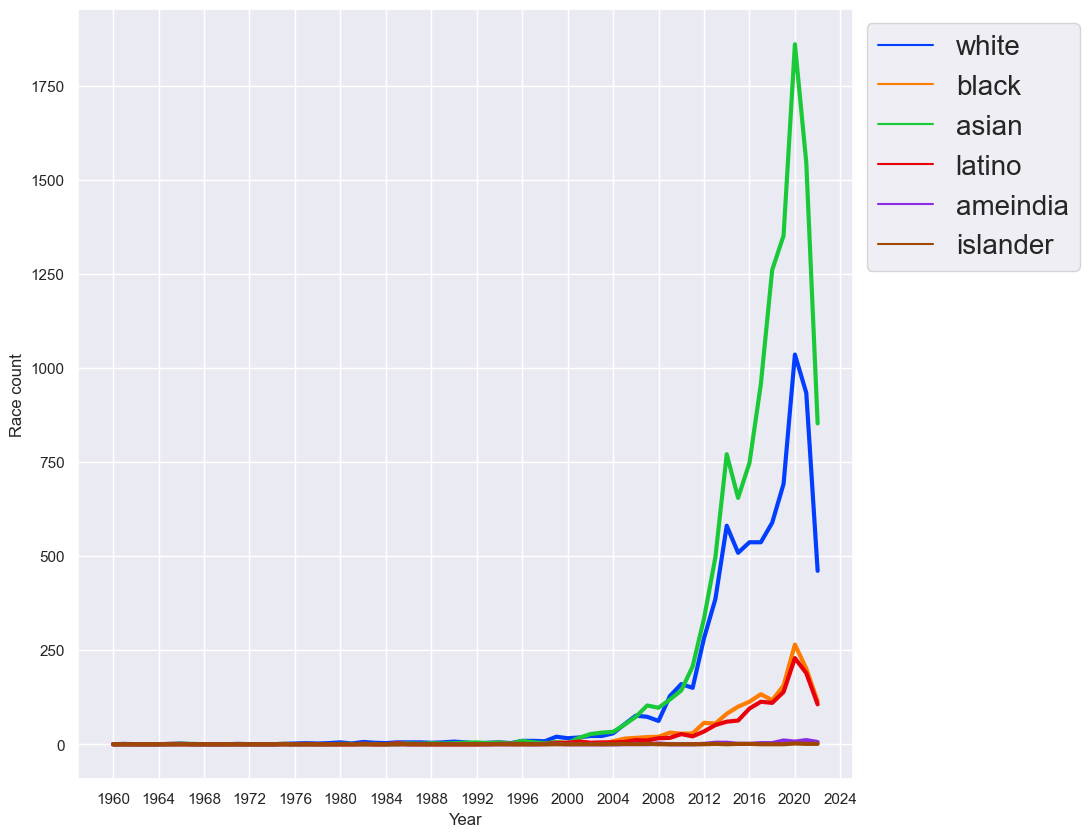

In [896]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='bright',   # colorblind  deep, muted, pastel, bright, dark, viridis
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1), prop={'size':20})›
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

In [876]:

df_pivot = pd.pivot_table(test_df,
                          values='single_race_count',
                          index='race_type',
                          columns='year')
df_pivot



year       1960  1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  \
race_type                                                                     
ameindia      0     0     0     0     0     0     0     0     0     0     0   
asian         0     0     0     0     0     0     1     1     0     0     0   
black         0     0     0     0     0     1     1     0     0     0     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        0     0     0     0     0     0     0     0     0     0     0   
white         0     1     0     0     0     1     2     0     0     0     0   

year       1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  \
race_type                                                                     
ameindia      0     0     0     0     0     0     0     0     0     0     0   
asian         0     0     0     0     1     0     0     0     0     1     1   
black         0     0     0     0     1     0     1     0     0     0     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        0     0     0     0     0     0     0     0     0     0     0   
white         1     0     0     0     1     2     3     2     3     5     2   

year       1982  1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  \
race_type                                                                     
ameindia      0     0     0     0     0     0     0     0     0     0     0   
asian         0     1     0     0     2     1     3     2     3     4     5   
black         1     0     0     2     1     1     0     0     0     0     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        1     0     0     2     0     0     0     0     0     0     0   
white         6     4     3     5     5     5     4     5     7     5     2   

year       1993  1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  \
race_type                                                                     
ameindia      0     0     0     0     0     0     1     0     0     0     0   
asian         3     5     2     9     5     3     5     3    17    27    31   
black         1     1     0     0     1     1     6     3     8     3     0   
islander      0     0     0     0     0     0     0     0     0     0     0   
latino        0     1     1     1     0     1     3     4     7     4     5   
white         4     5     3     9     9     8    20    16    18    22    22   

year       2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  \
race_type                                                                     
ameindia      0     0     1     0     2     0     0     0     1     4     4   
asian        33    52    73   103    97   119   143   207   334   497   771   
black         8    15    17    19    20    31    28    29    57    55    81   
islander      0     1     0     1     0     0     0     0     0     1     0   
latino        5     6    11    10    16    17    27    21    34    51    60   
white        29    53    76    73    62   128   160   150   282   386   581   

year       2015  2016  2017  2018  2019  2020  2021  2022  
race_type                                                  
ameindia      1     1     3     3    10     7    11     6  
asian       655   748   957  1261  1352  1861  1546   853  
black       100   113   133   117   156   265   201   114  
islander      1     1     0     0     0     2     1     1  
latino       63    95   113   110   139   229   189   106  
white       509   537   537   589   692  1036   934   461

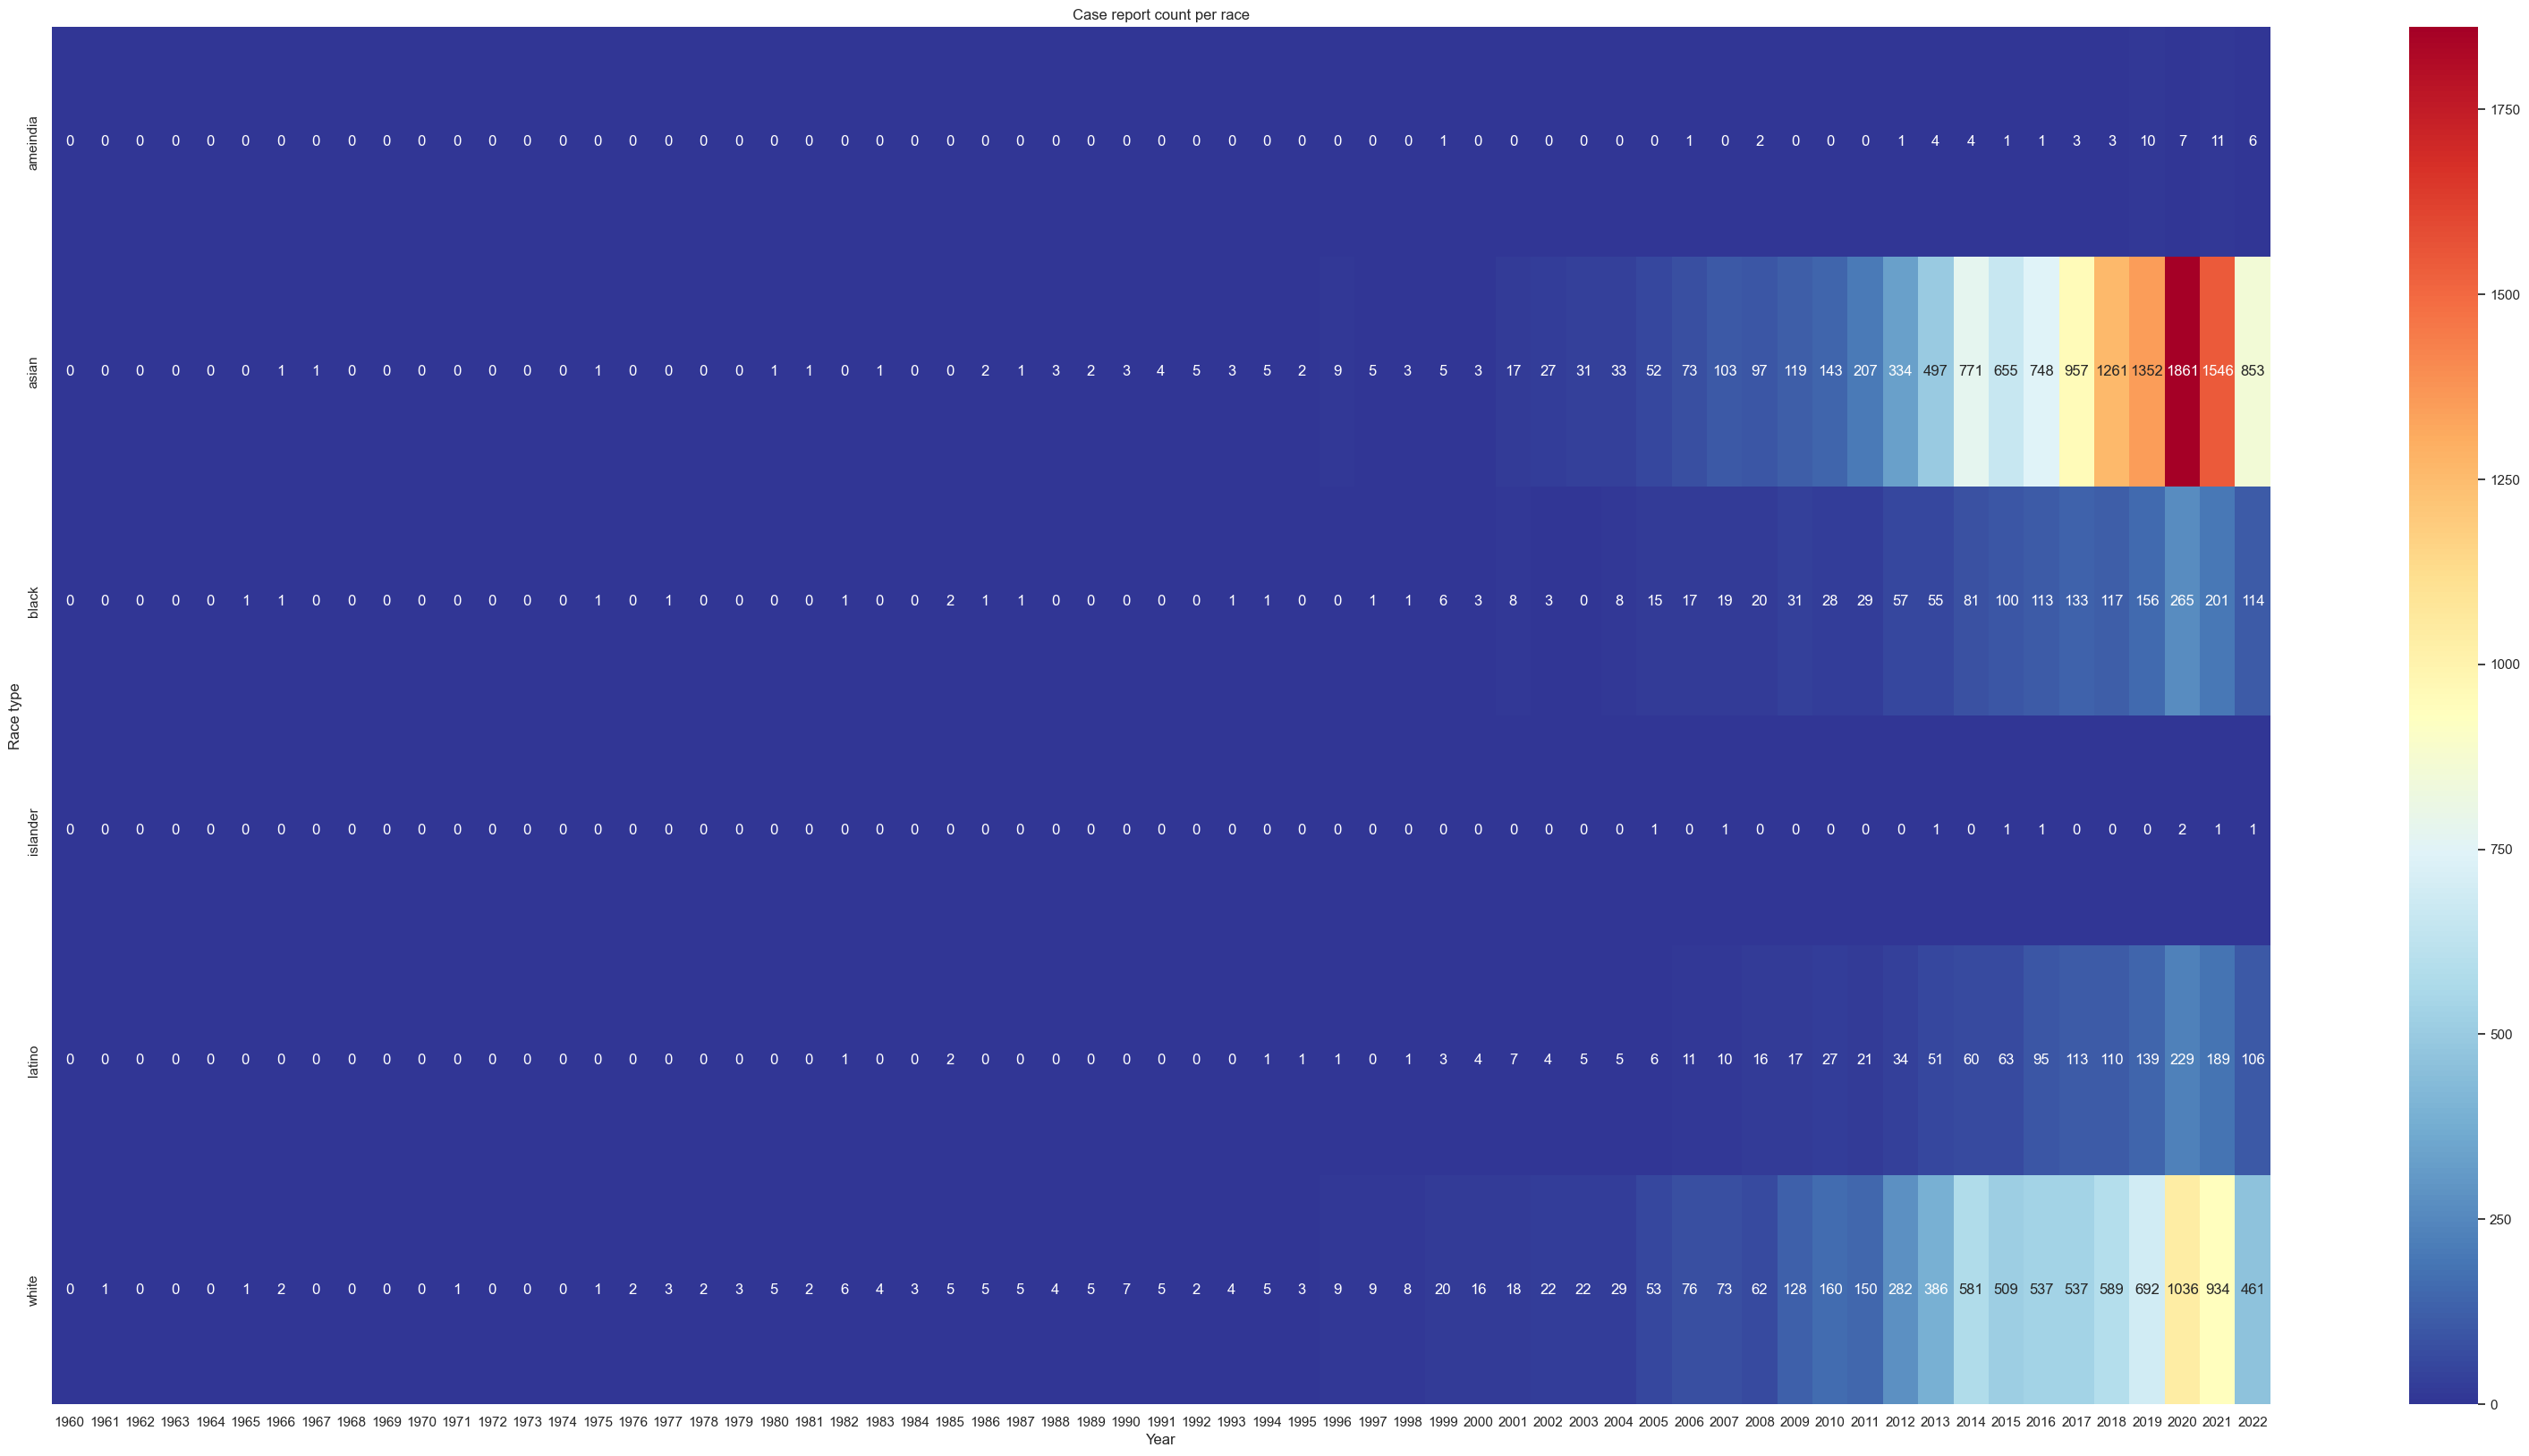

In [898]:
plt.figure(figsize = (40,20))
plt.title('Case report count per race')

sns.heatmap(df_pivot, annot=True, cmap='RdYlBu_r', fmt= '.4g',)
plt.xlabel('Year')
plt.ylabel('Race type')
plt.show()

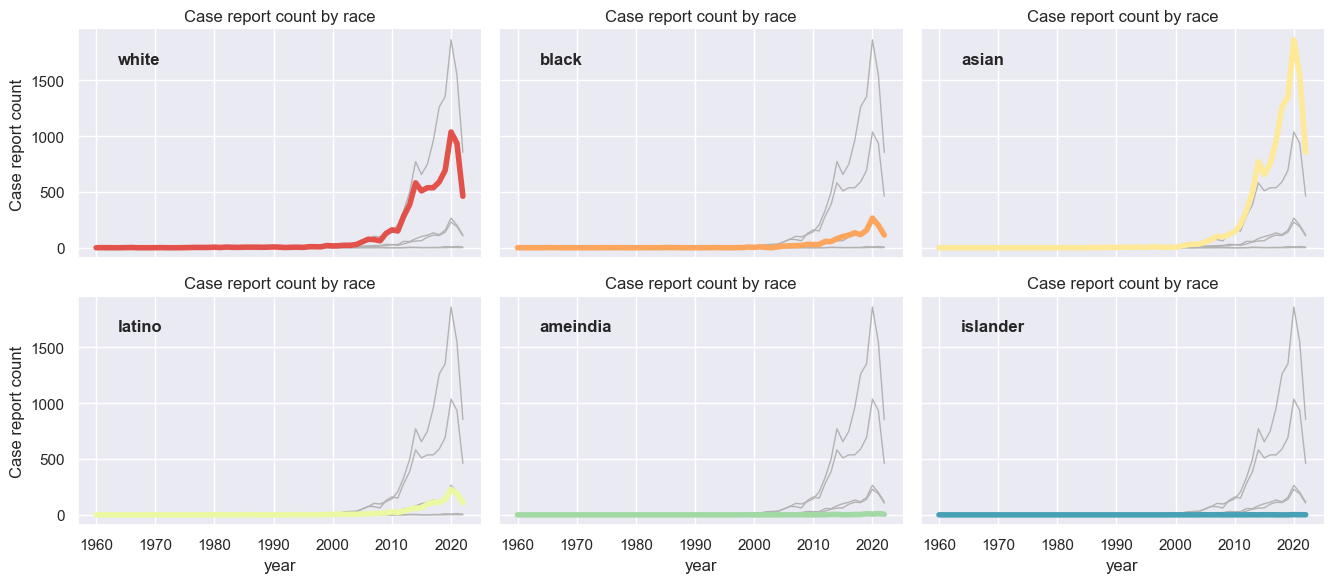

In [849]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report distribution by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [850]:
disease_mesh = 'D000349|Africa'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)

Results for D000349|Africa
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	1	0	1	1	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	1	0	1	1	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	1	1	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	0	1	0	0	0	0
2000	1	1	0	0	0	0	0	0	0
2001	2	1	1	1	1	1	1	0	0
2002	1	0	1	0	1	0	0	0	0
2003	1	0	1	

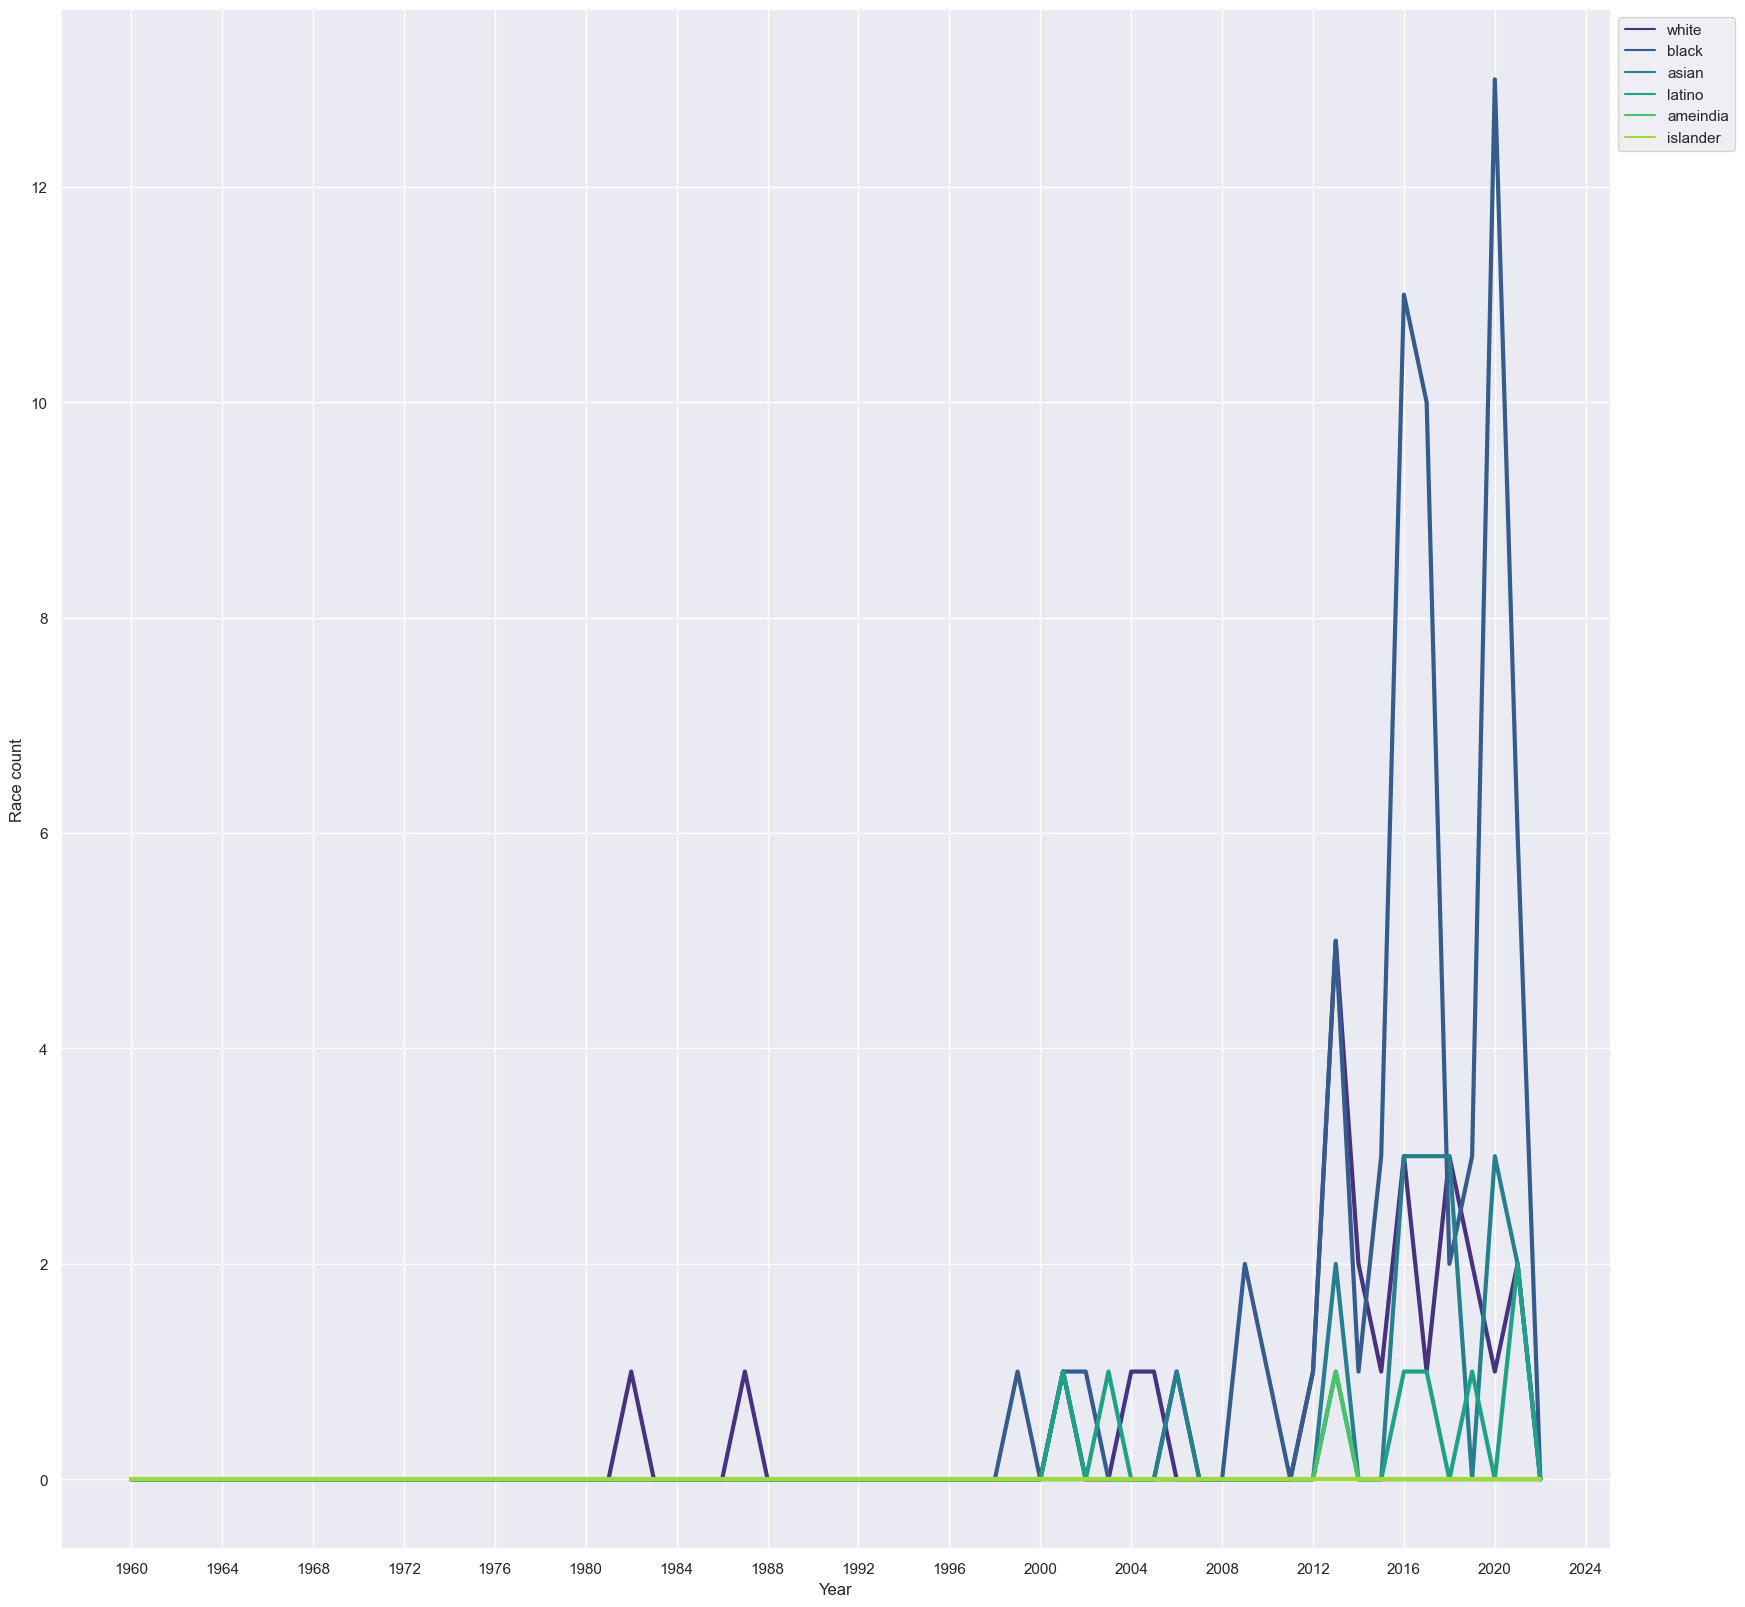

In [851]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

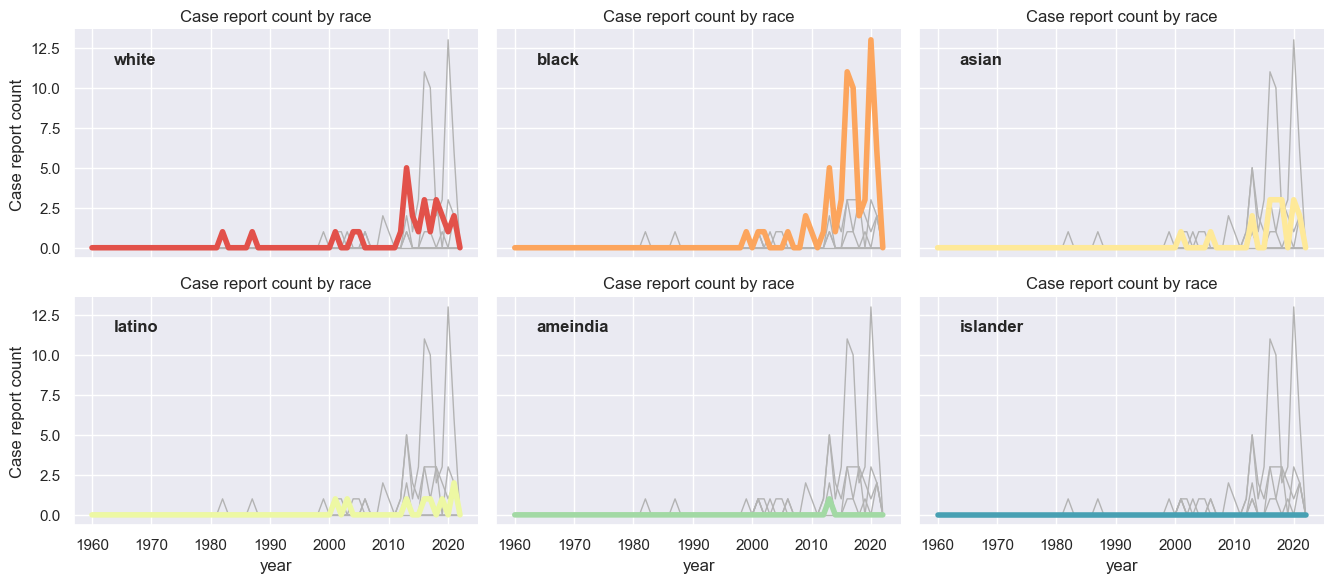

In [852]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report count by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [911]:
# D003550  Cystic Fibrosis
# more common in white patients

disease_mesh = 'D003550|Cystic Fibrosis'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)

Results for D003550|Cystic Fibrosis
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	1	1	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	1	1	0	0	0	0	0	0	0
1993	1	1	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	1	1	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	0	0	0	0	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

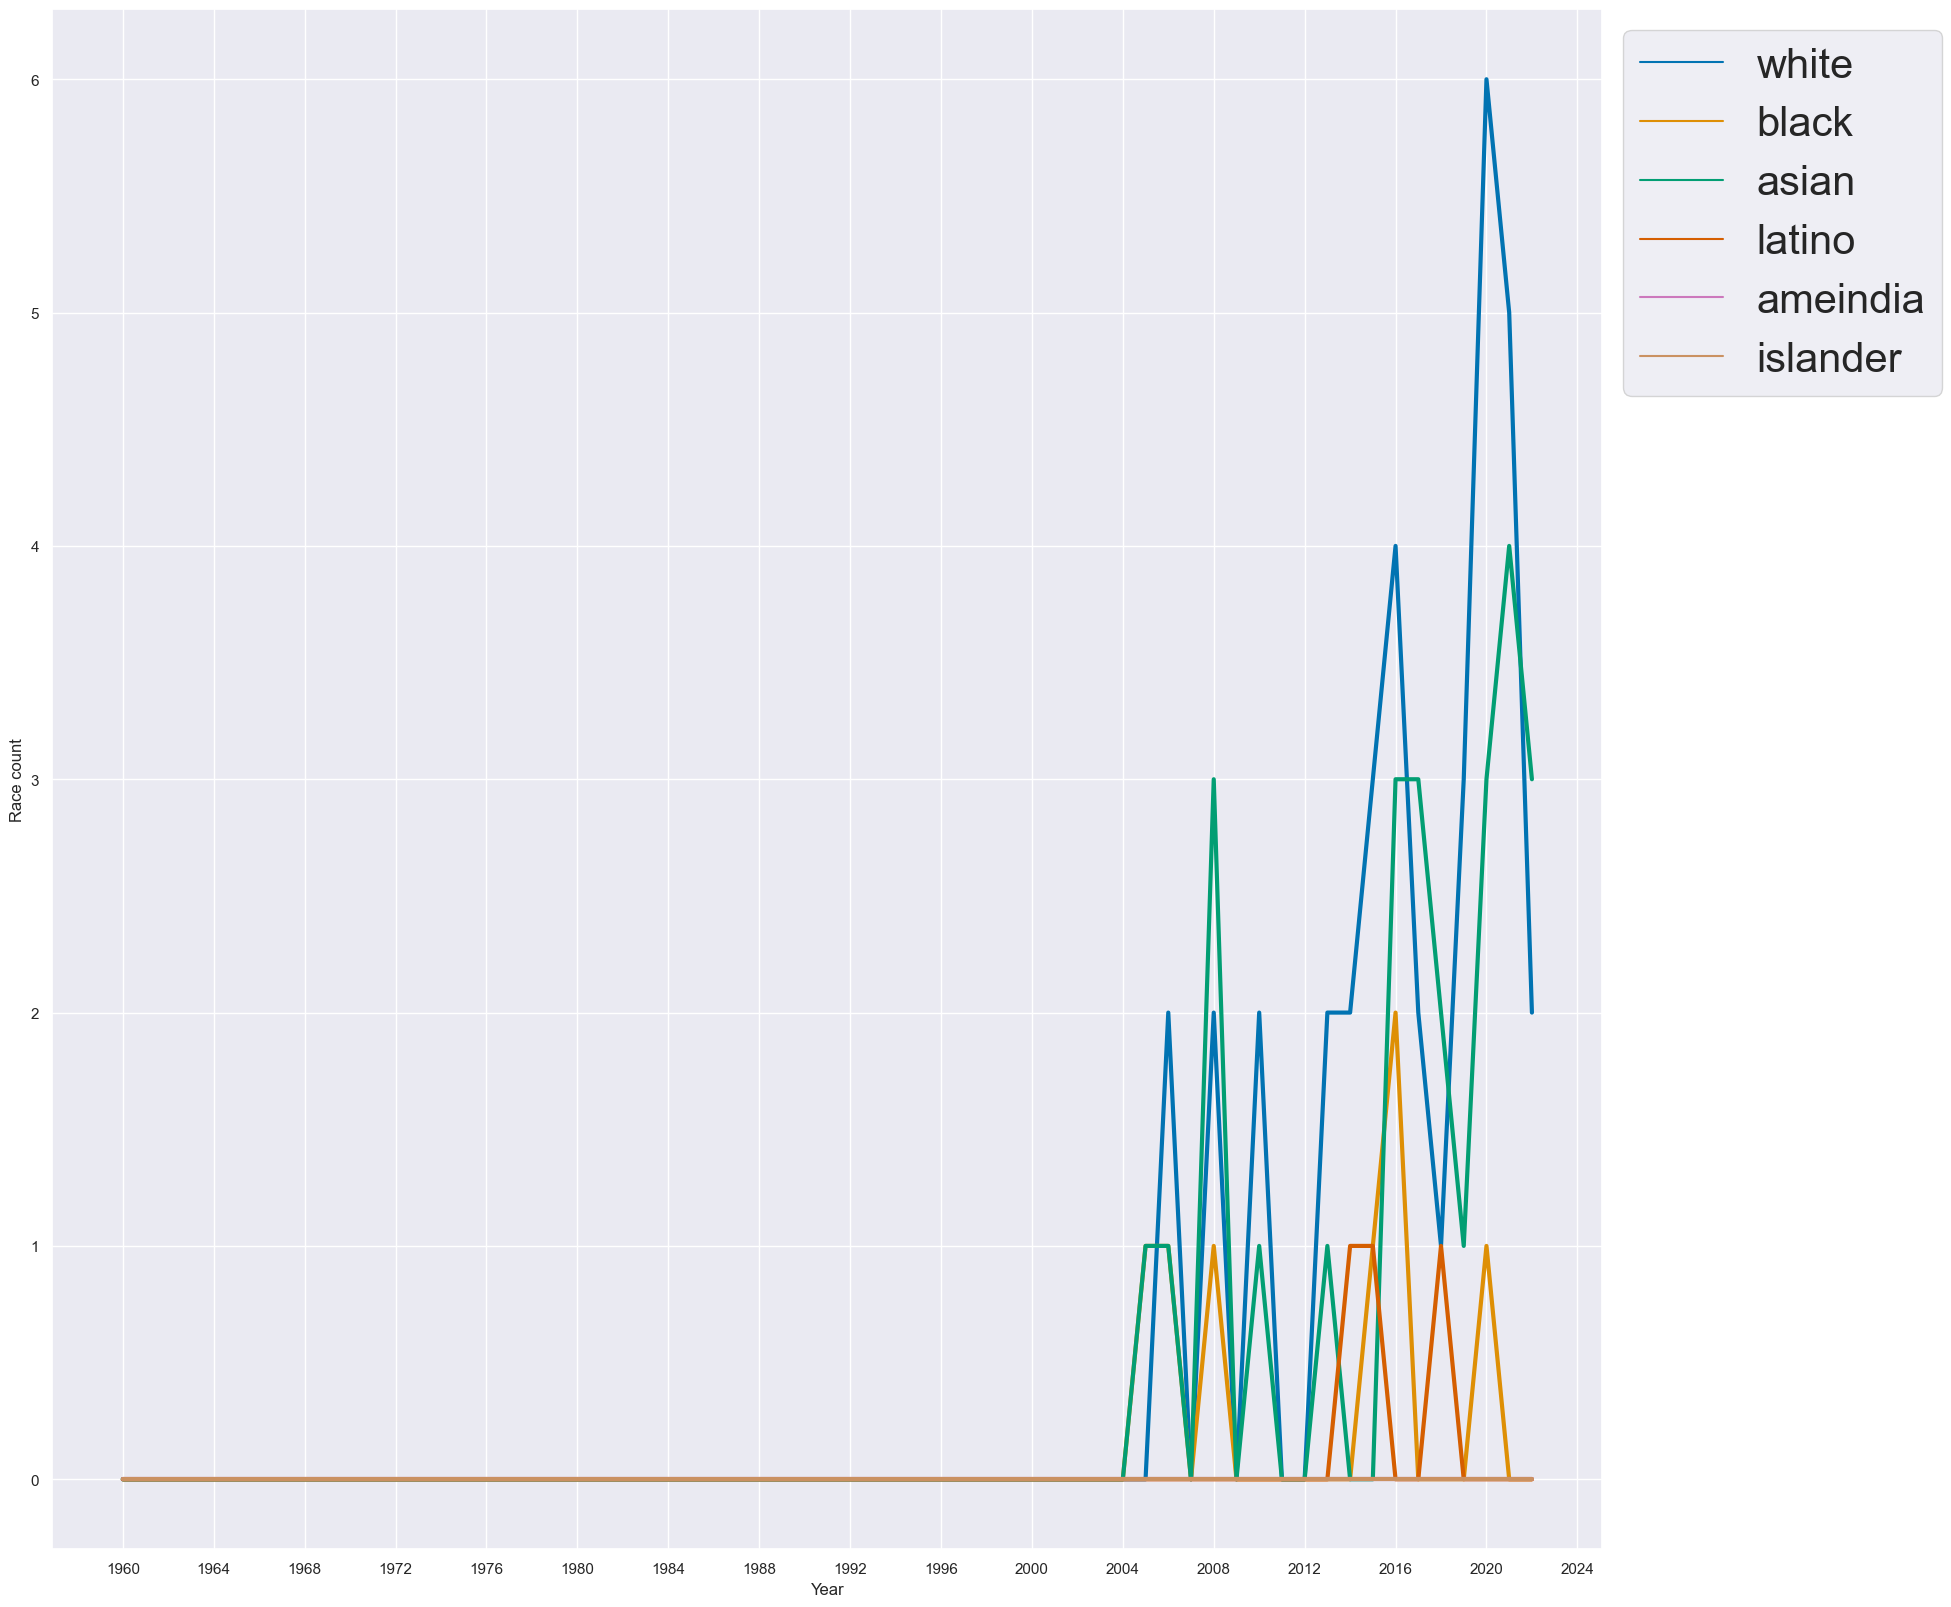

In [912]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='colorblind',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1), prop={'size':30})
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

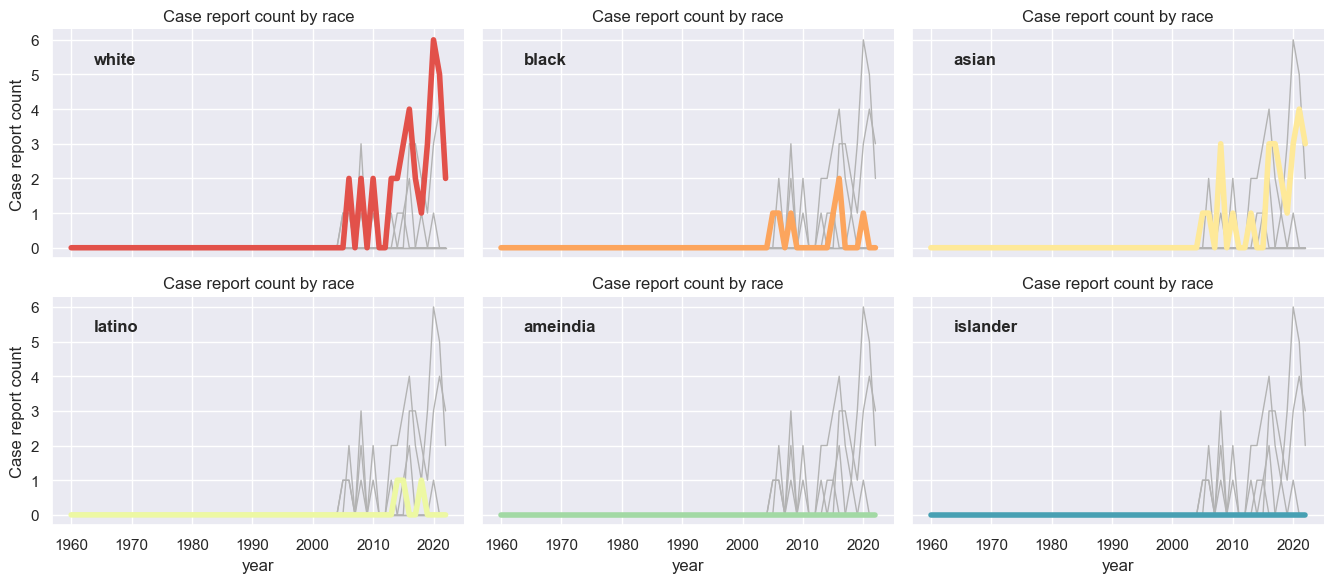

In [913]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report count by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [908]:
# D000755 | Anemia, Sickle Cell
# more common in Black patients

disease_mesh = 'D000755|Anemia, Sickle Cell'
print(f'Results for {disease_mesh}')
test_df = get_stats_by_mesh_single_df(disease_mesh)
print('='*20)

Results for D000755|Anemia, Sickle Cell
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/3295167026.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1960	0	0	0	0	0	0	0	0	0
1961	0	0	0	0	0	0	0	0	0
1962	0	0	0	0	0	0	0	0	0
1963	0	0	0	0	0	0	0	0	0
1964	0	0	0	0	0	0	0	0	0
1965	0	0	0	0	0	0	0	0	0
1966	0	0	0	0	0	0	0	0	0
1967	0	0	0	0	0	0	0	0	0
1968	0	0	0	0	0	0	0	0	0
1969	0	0	0	0	0	0	0	0	0
1970	0	0	0	0	0	0	0	0	0
1971	0	0	0	0	0	0	0	0	0
1972	0	0	0	0	0	0	0	0	0
1973	0	0	0	0	0	0	0	0	0
1974	0	0	0	0	0	0	0	0	0
1975	0	0	0	0	0	0	0	0	0
1976	0	0	0	0	0	0	0	0	0
1977	0	0	0	0	0	0	0	0	0
1978	0	0	0	0	0	0	0	0	0
1979	0	0	0	0	0	0	0	0	0
1980	0	0	0	0	0	0	0	0	0
1981	0	0	0	0	0	0	0	0	0
1982	0	0	0	0	0	0	0	0	0
1983	0	0	0	0	0	0	0	0	0
1984	0	0	0	0	0	0	0	0	0
1985	0	0	0	0	0	0	0	0	0
1986	0	0	0	0	0	0	0	0	0
1987	0	0	0	0	0	0	0	0	0
1988	0	0	0	0	0	0	0	0	0
1989	0	0	0	0	0	0	0	0	0
1990	0	0	0	0	0	0	0	0	0
1991	0	0	0	0	0	0	0	0	0
1992	0	0	0	0	0	0	0	0	0
1993	0	0	0	0	0	0	0	0	0
1994	0	0	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	0	0	0	0	0	0	0	0	0
1998	0	0	0	0	0	0	0	0	0
1999	1	0	1	1	0	0	0	0	0
2000	0	0	0	0	0	0	0	0	0
2001	0	0	0	0	0	0	0	0	0
2002	0	0	0	0	0	0	0	0	0
2003	0	0	0	

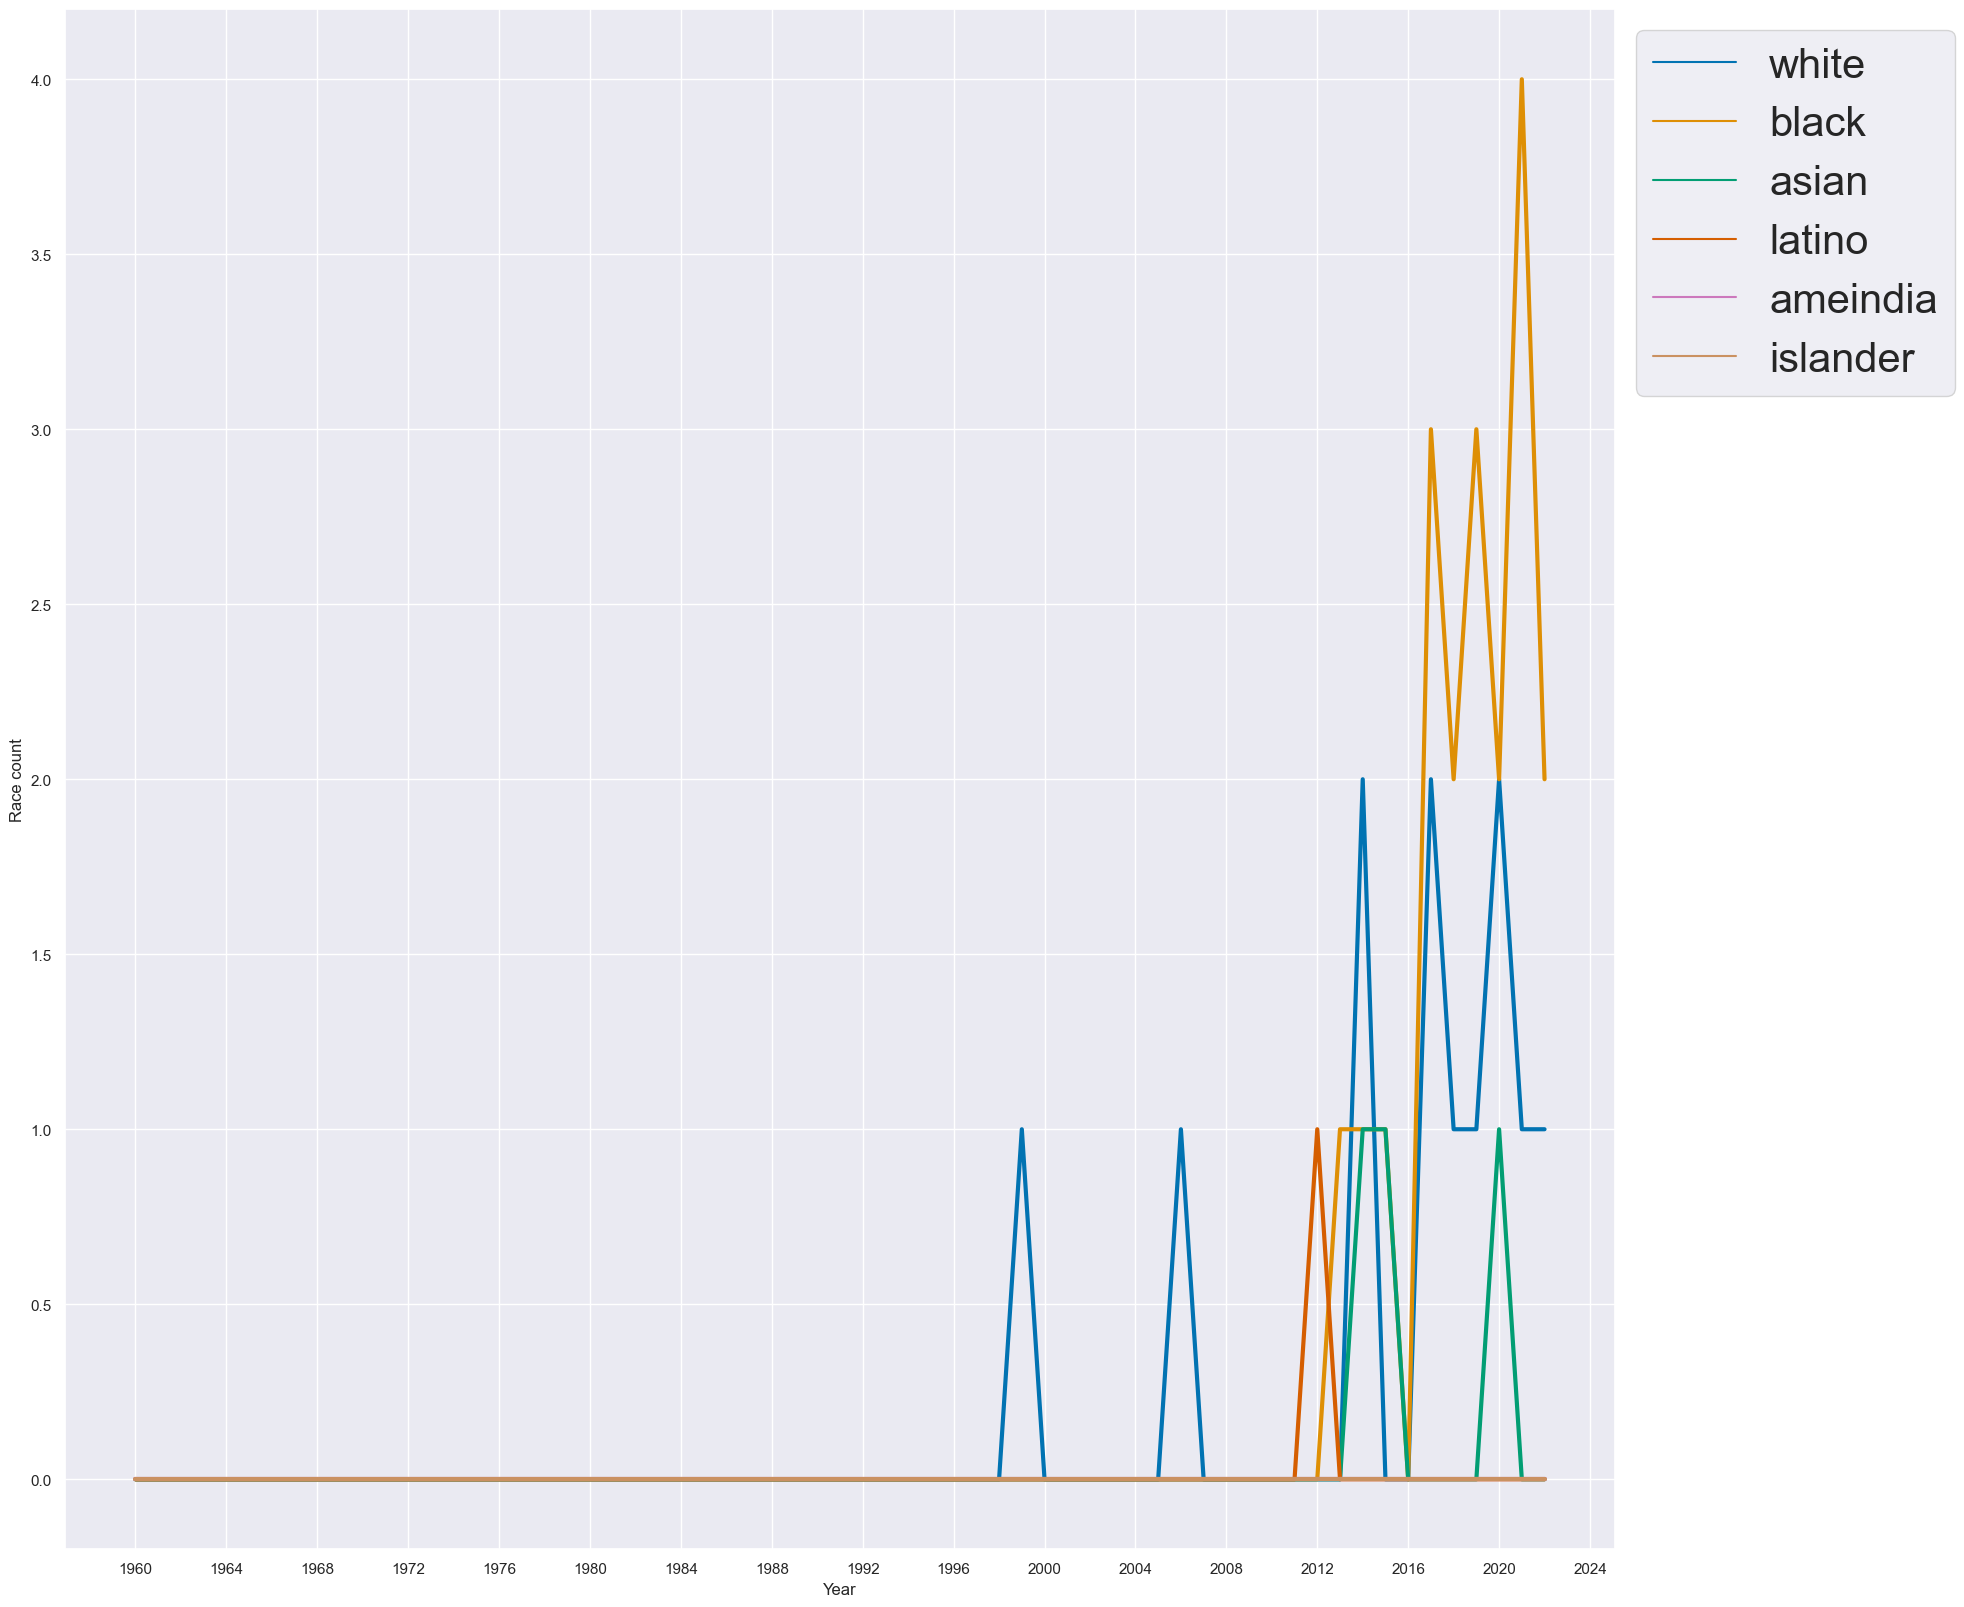

In [909]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,20)})

ax = sns.lineplot(data=test_df, x ='year', y = 'single_race_count',
                  hue='race_type', palette='colorblind',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1), prop={'size':30})
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()

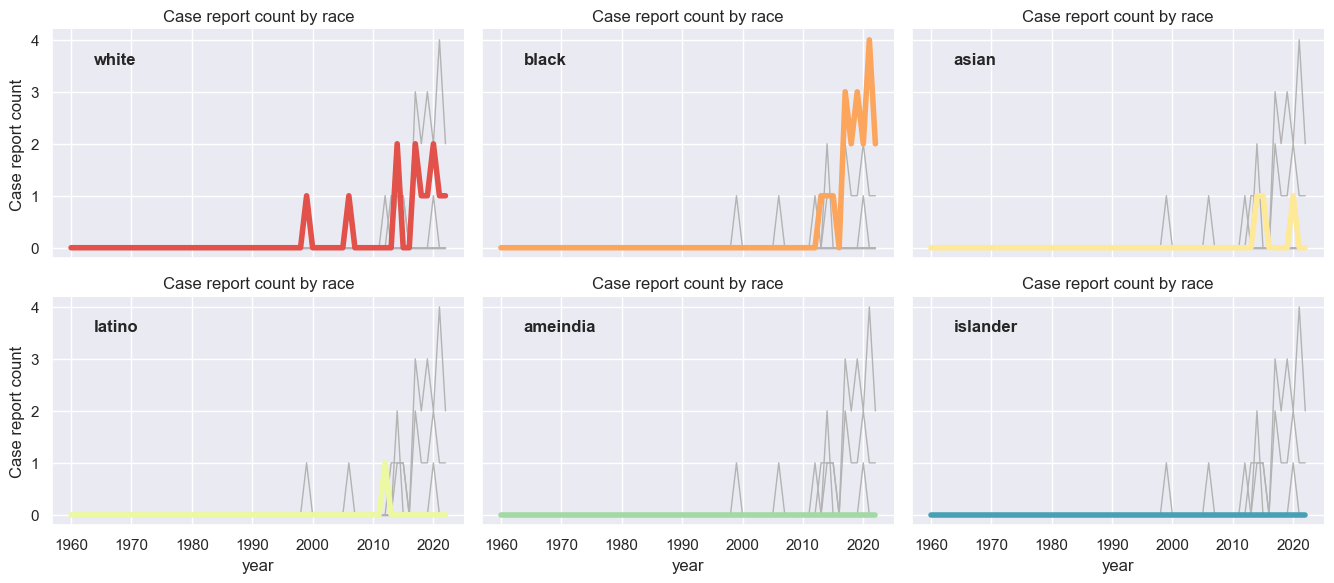

In [910]:
g = sns.relplot(data = test_df, x = "year", y = "single_race_count",
                col = "race_type", hue = "race_type",
                kind = "line", palette = "Spectral",   
                linewidth = 4, zorder = 5,
                col_wrap = 3, height = 3, aspect = 1.5, legend = False
               )

#add text and silhouettes
for time, ax in g.axes_dict.items():
    ax.text(.1, .85, time,
            transform = ax.transAxes, fontweight="bold"
           )
    sns.lineplot(data = test_df, x = "year", y = "single_race_count", units="race_type",
                 estimator = None, color= ".7", linewidth=1, ax=ax
                )

# ax.set_xticks('')

# # get the values we want displayed as tick labels
# tick_labels = tuple(df['Line'])
# # get the positions for the maximum xtick label
# x_max = int(max(plt.xticks()[0]))  # int() to convert numpy.int32 => int
# # manually set you xtick labels
# plt.xticks(range(0, x_max + 1), tick_labels, rotation=45)


g.set_titles("Case report count by race")
g.set_axis_labels("year", "Case report count")
g.tight_layout()

In [807]:

def get_stats_by_mesh_df(mesh_tag):
    result_list = []
    all_count = 0

    print('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count')
    result_list.append('year\ttotal_count\tno_race_count\trace_count\twhite_count\tblack_count\tasian_count\tlatino_count\tameindian_count\tislander_count'.split('\t'))
    
    for year in range(1990,2023):
        year_limit = (merged_df_no_subject_date['pubdate'] >= f'{year}-01-01')  & (merged_df_no_subject_date['pubdate'] <= f'{year}-12-31')

        journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))
        total_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
          ].shape[0]

        no_race_count = merged_df_no_subject_date[
            year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==True)
          ].shape[0]

        race_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['no_race']==False)
          ].shape[0]

        white_count = merged_df_no_subject_date[
              year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'white' in x))
          ].shape[0]

        black_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'black' in x)
              )
          ].shape[0]

        asian_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'asian' in x)
              )
          ].shape[0]

        latino_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'latino' in x)
              )
          ].shape[0]

        ameindian_count = merged_df_no_subject_date[
          year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'ameindian' in x)
              )
          ].shape[0]

        islander_count = merged_df_no_subject_date[
           year_limit
            & journal_limit
            & (merged_df_no_subject_date['race_type'].apply(lambda x: 'islander' in x)
              )
          ].shape[0]

        print(f'{year}\t{total_count}\t{no_race_count}\t{race_count}\t{white_count}\t{black_count}\t{asian_count}\t{latino_count}\t{ameindian_count}\t{islander_count}')
        result_list.append([year,total_count,no_race_count,race_count,white_count,black_count,asian_count,latino_count,ameindian_count,islander_count])
        all_count += total_count
    print(all_count)
#     print(result_list[:5])
    result_df = pd.DataFrame(result_list[1:], columns=result_list[0])
    result_df['MESH'] = disease_mesh
    return result_df
    



In [812]:
disease_mesh = 'D014057|Tomography, X-Ray Computed'
print(f'Results for {disease_mesh}')
test_df_1 = get_stats_by_mesh_df(disease_mesh)

disease_mesh = 'D008279|Magnetic Resonance Imaging'
print(f'Results for {disease_mesh}')
test_df_2 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

disease_mesh = 'D011859|Radiography'
print(f'Results for {disease_mesh}')
test_df_3 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


disease_mesh = 'D014463|Ultrasonography'
print(f'Results for {disease_mesh}')
test_df_4 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

disease_mesh = 'D004452|Echocardiography'
print(f'Results for {disease_mesh}')
test_df_5 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


Results for D014057|Tomography, X-Ray Computed
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	7	7	0	0	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	4	4	0	0	0	0	0	0	0
1993	4	4	0	0	0	0	0	0	0
1994	5	5	0	0	0	0	0	0	0
1995	6	6	0	0	0	0	0	0	0
1996	11	8	3	2	0	2	0	0	0
1997	13	9	4	3	0	2	0	0	0
1998	6	5	1	1	0	0	0	0	0
1999	25	22	3	2	0	1	1	0	0
2000	16	12	4	1	0	1	2	0	0
2001	23	18	5	2	1	3	0	0	0
2002	31	29	2	1	0	1	0	0	0
2003	27	25	2	1	0	1	0	0	0
2004	27	23	4	1	1	3	0	0	0
2005	82	66	16	10	4	5	0	0	0
2006	89	81	8	5	0	4	0	0	0
2007	158	138	20	6	2	16	1	0	0
2008	183	170	13	5	2	7	1	0	0
2009	219	188	31	13	6	13	3	0	0
2010	210	177	33	21	5	15	2	0	0
2011	317	284	33	14	1	24	3	0	0
2012	387	316	71	31	6	54	3	0	0
2013	447	335	112	46	7	80	4	0	0
2014	536	379	157	78	5	122	4	0	0
2015	608	462	146	59	12	98	8	0	0
2016	683	495	188	81	16	129	6	0	0
2017	630	461	169	64	9	115	10	1	0
2018	930	721	209	55	13	172	7	0	0
2019	848	677	171	55	13	118	15	1	0
2020	1352	1134	218	69	14	150	21	1	0
2021	514	409	105	38	6	75	9	1	0
2022	128	108	20	4	2	18	0	0	0
8535
Results for D008279|Magnetic Resonance Imaging
year	total_count	no_race_count	race_

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	3	3	0	0	0	0	0	0	0
1991	2	2	0	0	0	0	0	0	0
1992	1	1	0	0	0	0	0	0	0
1993	2	2	0	0	0	0	0	0	0
1994	2	2	0	0	0	0	0	0	0
1995	4	4	0	0	0	0	0	0	0
1996	9	9	0	0	0	0	0	0	0
1997	4	4	0	0	0	0	0	0	0
1998	4	4	0	0	0	0	0	0	0
1999	12	11	1	1	0	0	0	0	0
2000	10	8	2	1	0	0	1	0	0
2001	14	13	1	0	0	1	0	0	0
2002	18	14	4	1	0	4	0	0	0
2003	19	15	4	3	0	3	0	0	0
2004	21	20	1	0	0	1	0	0	0
2005	56	49	7	3	3	2	0	0	0
2006	66	58	8	5	0	6	1	0	0
2007	105	97	8	5	0	6	0	0	0
2008	137	119	18	8	3	12	0	0	0
2009	144	120	24	15	1	16	1	0	0
2010	154	131	23	13	3	12	1	0	0
2011	176	149	27	13	2	20	1	0	0
2012	234	197	37	19	2	19	4	0	0
2013	292	234	58	25	6	37	3	0	0
2014	350	243	107	55	3	78	4	0	0
2015	373	283	90	41	3	59	2	0	0
2016	462	354	108	48	4	78	6	0	0
2017	493	358	135	58	11	91	2	0	0
2018	655	502	153	52	11	110	7	0	0
2019	671	509	162	66	8	122	12	0	0
2020	861	707	154	45	12	110	8	1	1
2021	542	421	121	44	11	94	4	0	0
2022	165	133	32	13	4	21	2	0	0
6061
Results for D011859|Radiography
year	total_count	no_race_count	race_count	white_count	black_count	a

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	3	2	1	1	0	0	0	0	0
1991	3	3	0	0	0	0	0	0	0
1992	6	5	1	1	0	1	0	0	0
1993	4	4	0	0	0	0	0	0	0
1994	3	2	1	1	0	1	0	0	0
1995	4	4	0	0	0	0	0	0	0
1996	4	4	0	0	0	0	0	0	0
1997	3	3	0	0	0	0	0	0	0
1998	14	13	1	0	1	0	0	0	0
1999	14	14	0	0	0	0	0	0	0
2000	12	10	2	2	0	0	0	0	0
2001	21	19	2	1	0	1	1	0	0
2002	12	10	2	1	0	2	0	0	0
2003	22	21	1	0	0	1	0	0	0
2004	21	20	1	0	0	1	0	0	0
2005	37	34	3	1	1	1	0	0	0
2006	39	33	6	4	1	3	1	0	0
2007	44	36	8	2	2	7	1	0	0
2008	59	53	6	3	0	6	0	0	0
2009	74	60	14	6	1	10	2	0	0
2010	112	95	17	9	1	11	2	0	0
2011	125	104	21	6	3	15	0	0	0
2012	116	91	25	13	2	18	3	0	0
2013	178	134	44	23	1	29	3	0	0
2014	180	134	46	25	2	36	4	0	0
2015	209	164	45	21	3	31	2	0	0
2016	123	85	38	19	2	26	2	0	0
2017	111	73	38	17	5	22	2	0	0
2018	139	103	36	11	2	27	3	0	0
2019	156	128	28	12	4	14	4	0	0
2020	316	269	47	10	7	31	7	0	0
2021	87	69	18	5	3	12	1	0	0
2022	21	17	4	1	0	2	1	0	0
2272
Results for D014463|Ultrasonography
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameind

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	4	2	2	1	0	1	0	0	0
1991	6	6	0	0	0	0	0	0	0
1992	3	3	0	0	0	0	0	0	0
1993	2	2	0	0	0	0	0	0	0
1994	2	2	0	0	0	0	0	0	0
1995	3	3	0	0	0	0	0	0	0
1996	3	2	1	1	0	1	0	0	0
1997	4	2	2	2	0	1	0	0	0
1998	6	5	1	1	0	0	0	0	0
1999	10	8	2	1	1	0	0	0	0
2000	8	7	1	0	1	0	0	0	0
2001	17	17	0	0	0	0	0	0	0
2002	7	5	2	2	0	1	0	0	0
2003	8	8	0	0	0	0	0	0	0
2004	25	25	0	0	0	0	0	0	0
2005	22	20	2	1	0	1	0	0	0
2006	28	25	3	2	1	2	1	0	0
2007	48	45	3	0	0	3	1	0	0
2008	31	28	3	1	0	3	0	0	0
2009	46	41	5	2	1	3	1	0	0
2010	50	43	7	2	0	4	1	0	0
2011	55	48	7	2	0	6	0	0	0
2012	85	69	16	10	2	12	0	0	0
2013	82	68	14	5	0	12	0	0	0
2014	105	75	30	18	3	20	1	0	0
2015	144	116	28	9	4	20	2	0	0
2016	142	105	37	17	3	26	1	0	0
2017	159	120	39	13	3	27	3	0	0
2018	251	203	48	15	5	38	3	0	0
2019	264	205	59	19	2	42	6	0	0
2020	355	291	64	24	4	43	4	1	0
2021	214	172	42	16	3	29	1	0	0
2022	63	57	6	2	0	4	0	0	0
2252
Results for D004452|Echocardiography
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	0	0	0	0	0	0	0	0	0
1991	1	1	0	0	0	0	0	0	0
1992	1	0	1	0	0	1	0	0	0
1993	1	1	0	0	0	0	0	0	0
1994	1	1	0	0	0	0	0	0	0
1995	0	0	0	0	0	0	0	0	0
1996	0	0	0	0	0	0	0	0	0
1997	2	2	0	0	0	0	0	0	0
1998	3	3	0	0	0	0	0	0	0
1999	2	2	0	0	0	0	0	0	0
2000	1	1	0	0	0	0	0	0	0
2001	1	1	0	0	0	0	0	0	0
2002	5	5	0	0	0	0	0	0	0
2003	10	9	1	1	0	1	0	0	0
2004	7	6	1	0	0	1	0	0	0
2005	12	11	1	0	0	1	0	0	0
2006	15	12	3	3	0	2	0	0	0
2007	29	26	3	2	1	2	0	0	0
2008	22	19	3	1	0	2	1	0	0
2009	25	20	5	3	1	4	1	0	0
2010	41	33	8	6	0	5	0	0	0
2011	42	37	5	1	1	4	0	0	0
2012	25	20	5	4	0	4	0	0	0
2013	68	52	16	6	0	16	0	0	0
2014	82	59	23	10	3	18	1	0	0
2015	184	157	27	11	3	19	2	0	0
2016	157	124	33	12	3	22	0	0	0
2017	177	151	26	10	2	17	1	0	0
2018	221	174	47	26	3	34	3	0	0
2019	188	160	28	8	7	17	2	0	0
2020	294	258	36	8	5	24	6	0	0
2021	167	145	22	10	1	18	1	0	0
2022	46	44	2	2	0	0	0	0	0
1830


year  total_count  no_race_count  race_count  white_count  black_count  \
0  1990            7              7           0            0            0   
1  1991            9              9           0            0            0   
2  1992            4              4           0            0            0   
3  1993            4              4           0            0            0   
4  1994            5              5           0            0            0   

   asian_count  latino_count  ameindian_count  islander_count  \
0            0             0                0               0   
1            0             0                0               0   
2            0             0                0               0   
3            0             0                0               0   
4            0             0                0               0   

                                 MESH  
0  D014057|Tomography, X-Ray Computed  
1  D014057|Tomography, X-Ray Computed  
2  D014057|Tomography, X-Ray Computed  
3  D014057|Tomography, X-Ray Computed  
4  D014057|Tomography, X-Ray Computed

In [818]:
res_df = pd.concat([test_df_1, test_df_2, test_df_3, test_df_4, test_df_5])
res_df.head()

year  total_count  no_race_count  race_count  white_count  black_count  \
0  1990            7              7           0            0            0   
1  1991            9              9           0            0            0   
2  1992            4              4           0            0            0   
3  1993            4              4           0            0            0   
4  1994            5              5           0            0            0   

   asian_count  latino_count  ameindian_count  islander_count  \
0            0             0                0               0   
1            0             0                0               0   
2            0             0                0               0   
3            0             0                0               0   
4            0             0                0               0   

                                 MESH  
0  D014057|Tomography, X-Ray Computed  
1  D014057|Tomography, X-Ray Computed  
2  D014057|Tomography, X-Ray Computed  
3  D014057|Tomography, X-Ray Computed  
4  D014057|Tomography, X-Ray Computed

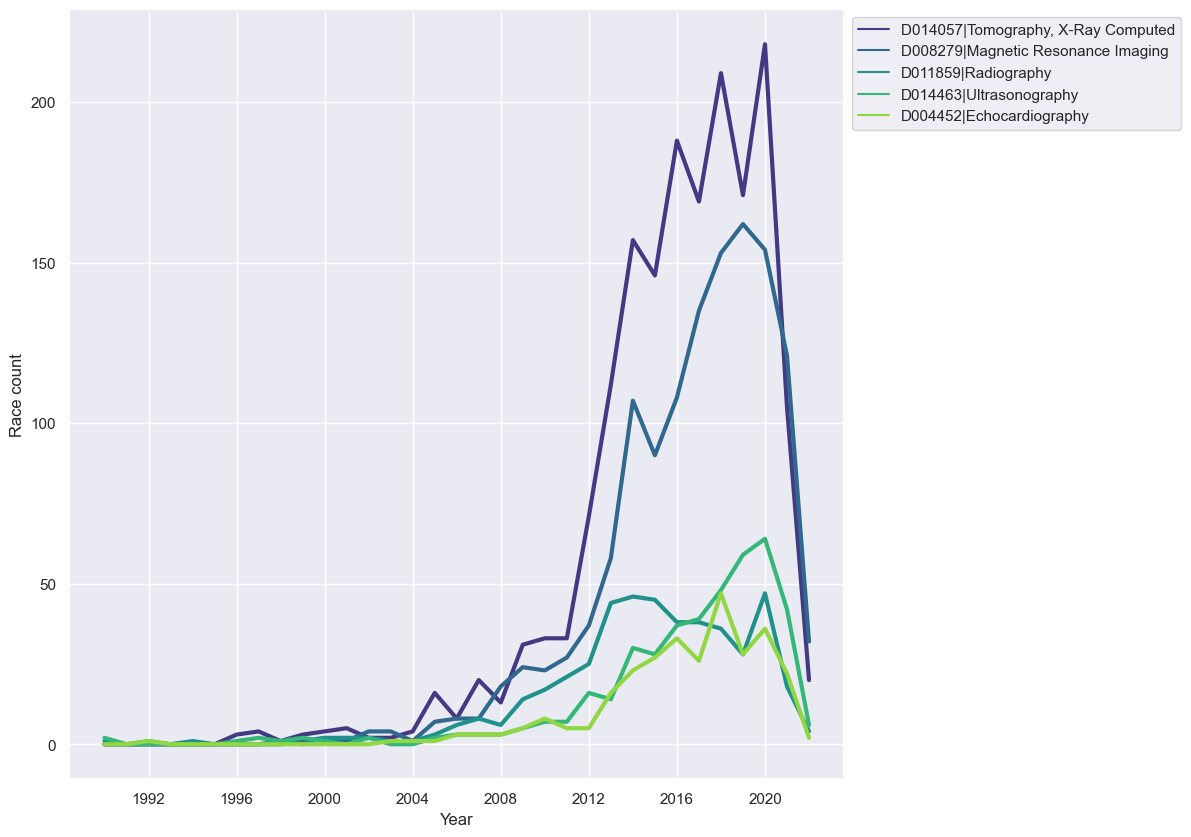

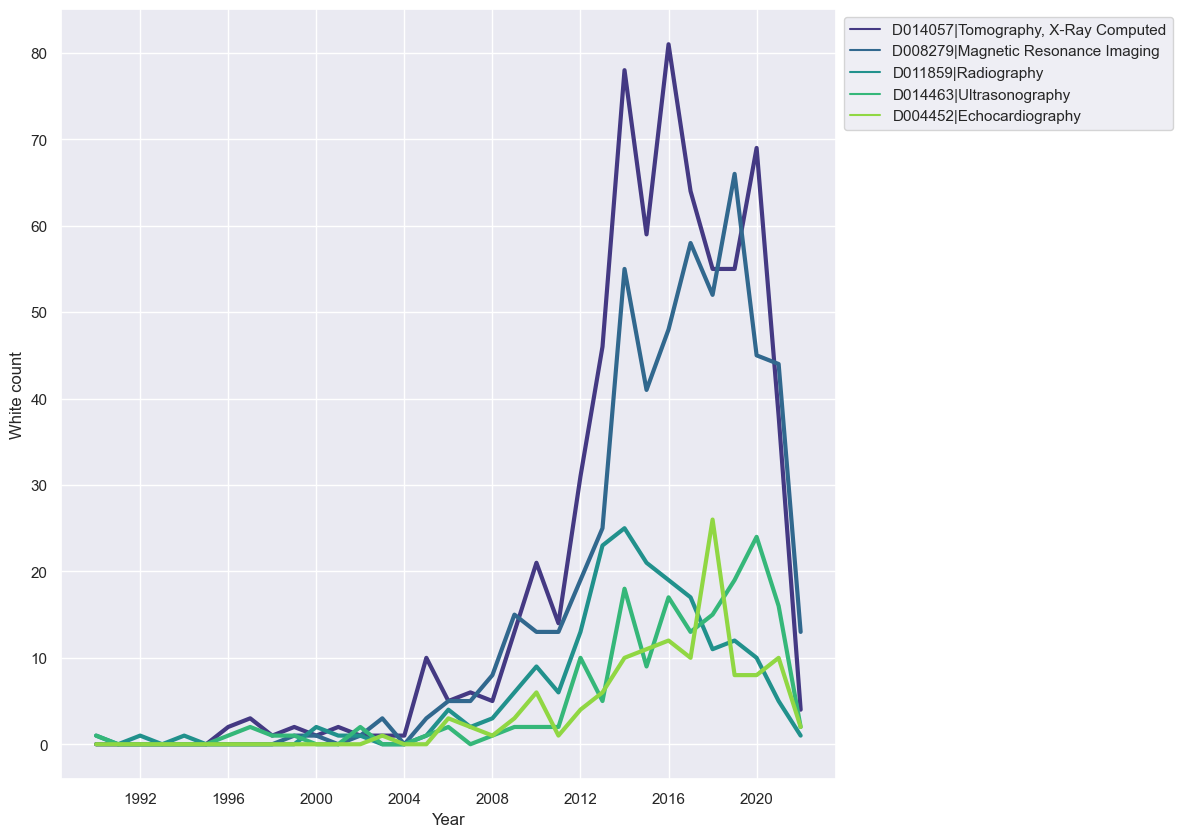

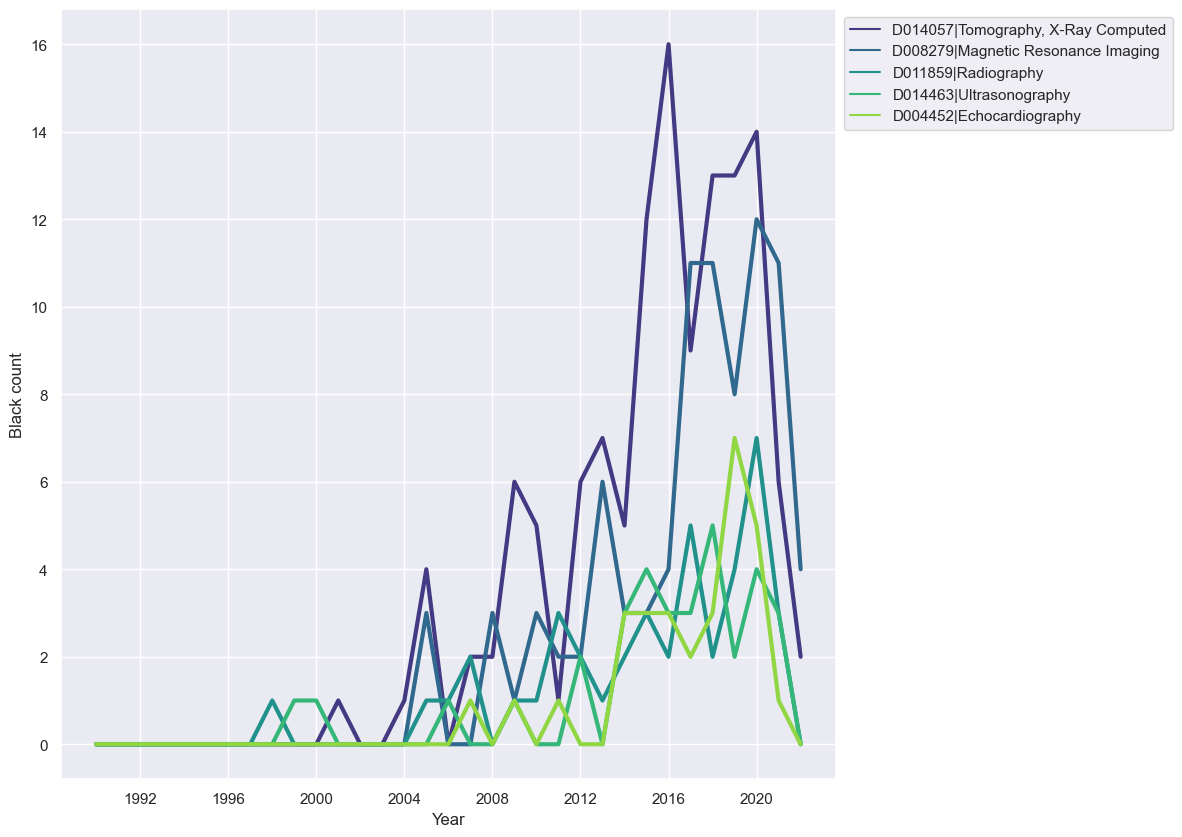

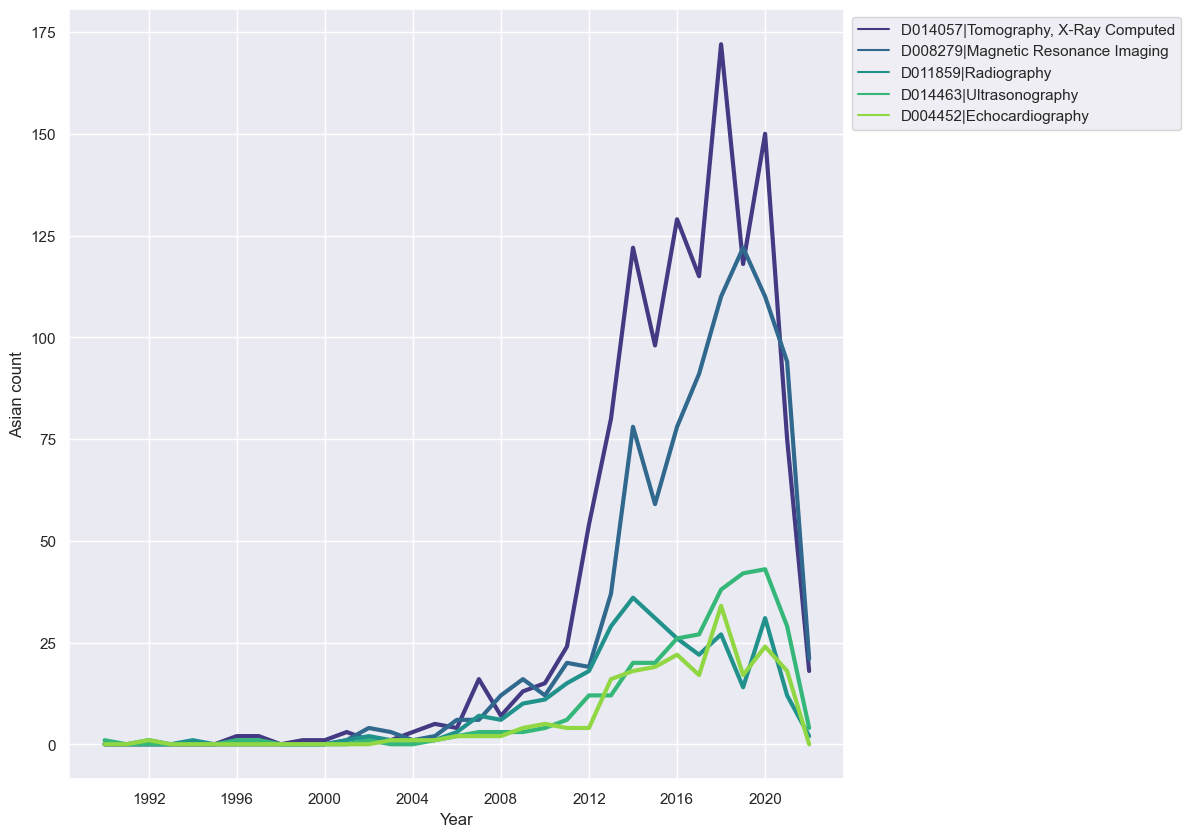

In [862]:

# sns.barplot(x = 'year',y = 'race_count',data = res_df)
# sns.set(rc={'figure.figsize':(20,20)})
# plt.title("Race count over the years")
# plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=res_df, x ='year', y = 'race_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=res_df, x ='year', y = 'white_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('White count')
plt.xlabel('Year')
plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.lineplot(data=res_df, x ='year', y = 'black_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Black count')
plt.xlabel('Year')
plt.show()


ax = sns.lineplot(data=res_df, x ='year', y = 'asian_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Asian count')
plt.xlabel('Year')
plt.show()

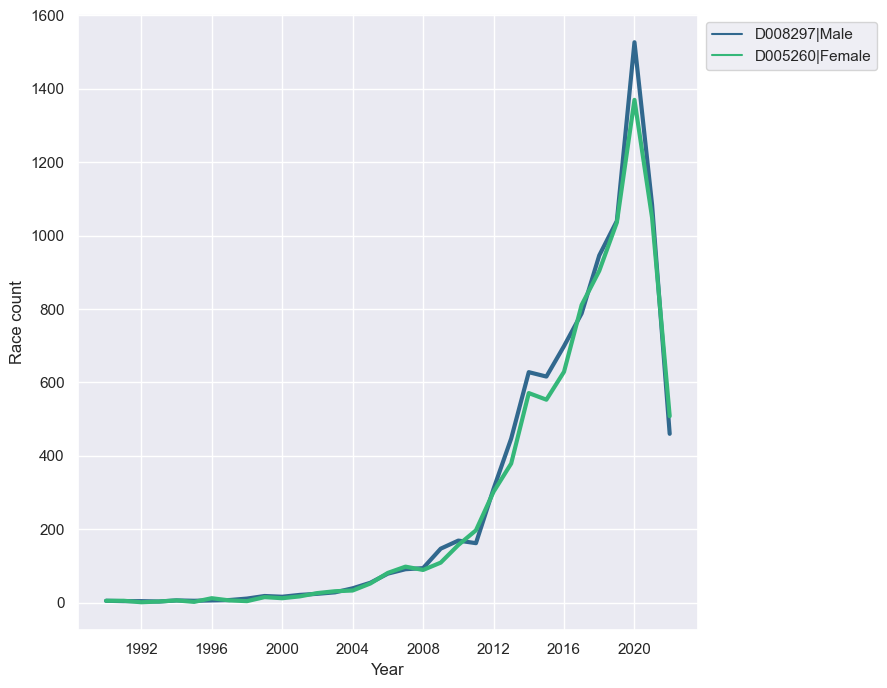

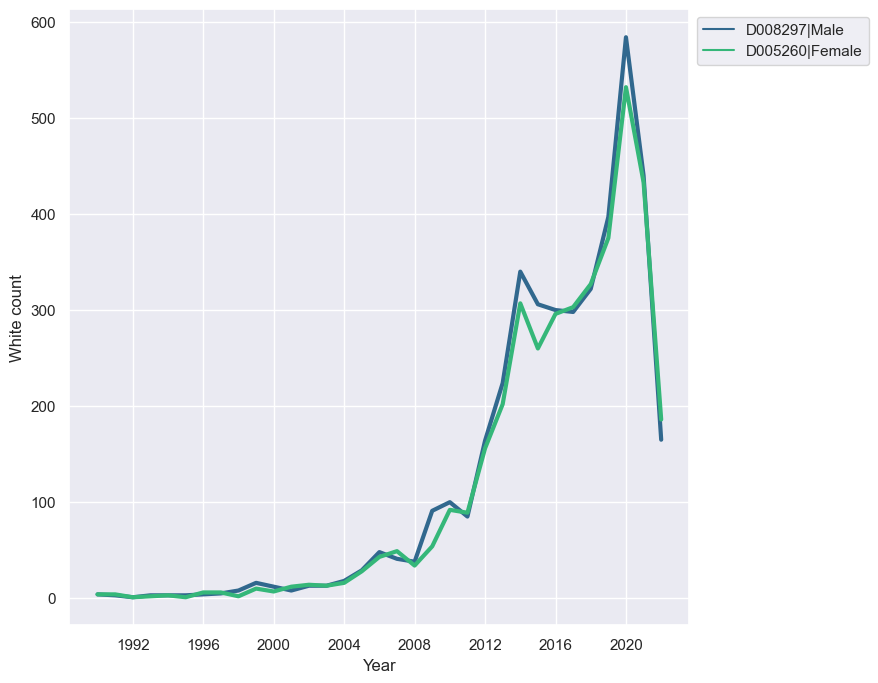

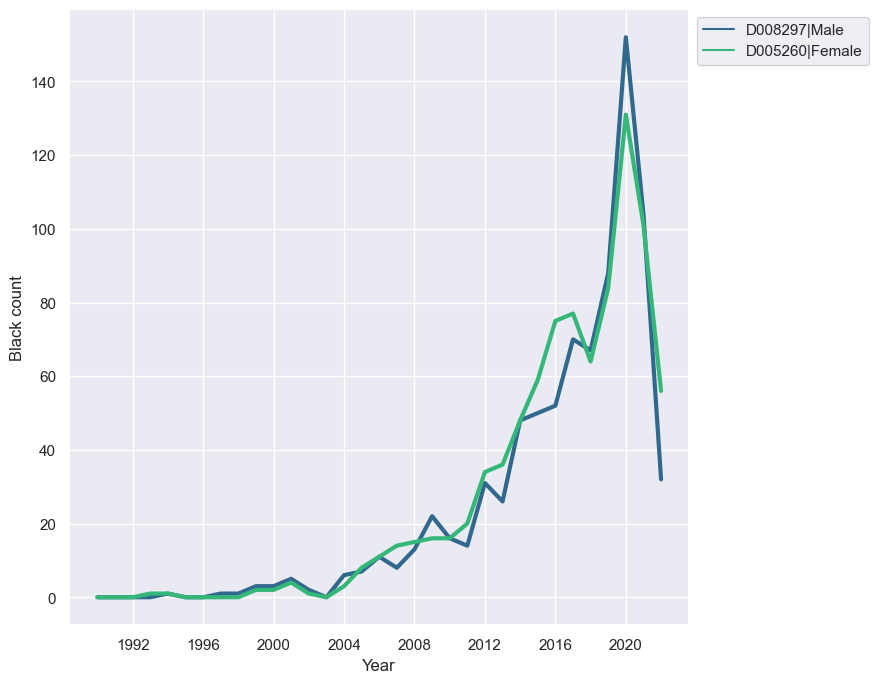

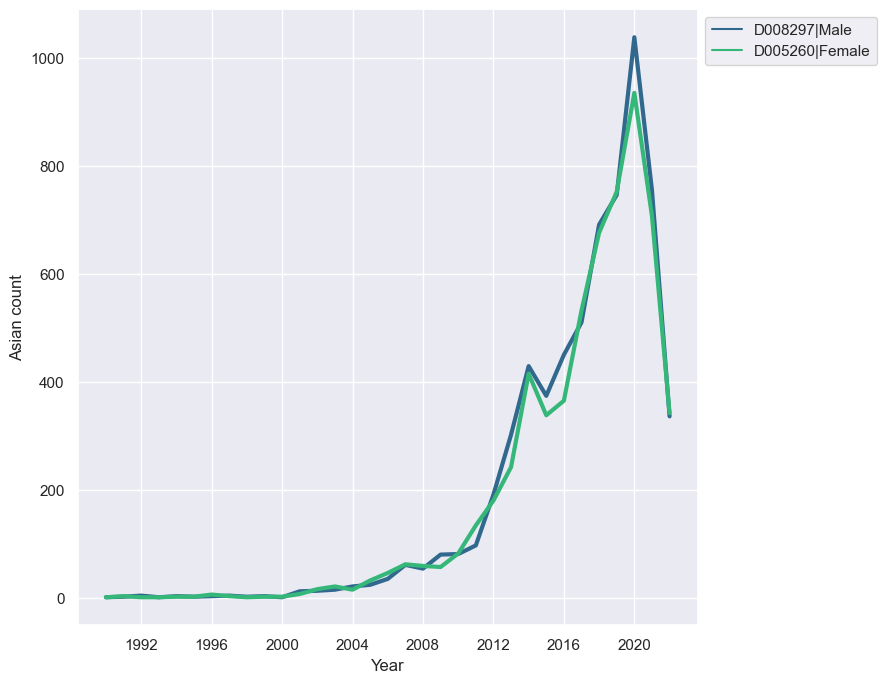

In [865]:
disease_mesh = 'D008297|Male'
print(f'Results for {disease_mesh}')
test_df_1 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


disease_mesh = 'D005260|Female'
print(f'Results for {disease_mesh}')
test_df_2 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

res_df = pd.concat([test_df_1, test_df_2])
res_df.head()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'race_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'white_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('White count')
plt.xlabel('Year')
plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'black_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Black count')
plt.xlabel('Year')
plt.show()


ax = sns.lineplot(data=res_df, x ='year', y = 'asian_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Asian count')
plt.xlabel('Year')
plt.show()

Results for D000328|Adult
year	total_count	no_race_count	race_count	white_count	black_count	asian_count	latino_count	ameindian_count	islander_count


/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	33	27	6	4	0	2	0	0	0
1991	39	33	6	4	0	3	0	0	0
1992	34	32	2	0	0	2	0	0	0
1993	40	39	1	1	1	0	0	0	0
1994	38	31	7	3	1	4	1	0	0
1995	31	31	0	0	0	0	0	0	0
1996	44	40	4	1	0	3	0	0	0
1997	36	32	4	4	1	2	0	0	0
1998	44	41	3	2	0	1	0	0	0
1999	80	68	12	9	2	2	3	0	0
2000	60	49	11	7	3	1	1	0	0
2001	97	80	17	8	4	10	3	0	0
2002	98	77	21	12	2	10	1	0	0
2003	155	129	26	15	0	14	2	0	0
2004	171	138	33	14	5	17	3	0	0
2005	236	193	43	22	7	21	4	0	0
2006	288	228	60	39	8	27	4	0	0
2007	346	280	66	31	11	41	4	0	0
2008	425	363	62	18	13	33	13	0	0
2009	463	369	94	49	15	53	9	0	0
2010	617	496	121	62	17	60	13	0	0
2011	673	554	119	55	17	77	8	0	0
2012	831	629	202	105	17	127	19	0	0
2013	1074	791	283	146	30	181	21	2	0
2014	1299	884	415	212	42	284	29	1	0
2015	1546	1159	387	186	44	212	33	1	0
2016	1649	1232	417	180	51	248	31	1	0
2017	1885	1403	482	175	57	292	38	0	0
2018	2416	1806	610	213	53	424	51	0	0
2019	2657	2049	608	228	56	432	46	1	0
2020	4171	3308	863	327	101	571	83	2	2
2021	2822	2150	672	282	75	440	66	3	0
2022	1290	988	302	114	

/var/folders/_3/np49sjc12t54plcrh2qv_xx40000gn/T/ipykernel_76901/281460603.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  journal_limit = (merged_df_no_subject_date['mesh_list'].astype(str).str.contains(f'({disease_mesh})', regex=True))


1990	9	7	2	2	0	0	0	0	0
1991	9	9	0	0	0	0	0	0	0
1992	7	7	0	0	0	0	0	0	0
1993	9	8	1	1	0	0	0	0	0
1994	7	7	0	0	0	0	0	0	0
1995	8	7	1	1	0	1	0	0	0
1996	6	5	1	0	0	0	1	0	0
1997	8	8	0	0	0	0	0	0	0
1998	7	5	2	1	0	0	1	0	0
1999	14	9	5	5	0	1	0	0	0
2000	9	9	0	0	0	0	0	0	0
2001	14	9	5	4	2	5	2	0	0
2002	17	12	5	3	0	2	0	0	0
2003	18	13	5	1	0	3	2	0	0
2004	38	32	6	4	0	4	0	0	0
2005	48	33	15	7	2	6	1	0	0
2006	65	51	14	6	2	8	1	1	0
2007	75	62	13	6	2	9	3	0	0
2008	106	87	19	4	3	12	3	1	0
2009	136	105	31	19	1	13	4	0	0
2010	190	149	41	25	3	15	6	0	0
2011	192	149	43	28	5	21	4	0	0
2012	254	182	72	40	13	39	6	0	0
2013	308	224	84	43	10	44	8	1	0
2014	371	254	117	71	11	65	11	2	0
2015	468	345	123	68	18	62	5	0	0
2016	497	362	135	69	13	74	13	0	0
2017	556	414	142	66	10	77	14	3	0
2018	727	537	190	80	13	125	19	1	0
2019	866	623	243	98	34	161	25	2	0
2020	1339	978	361	147	33	218	39	2	0
2021	1144	852	292	129	43	169	33	3	1
2022	614	462	152	74	21	80	17	2	0
8136


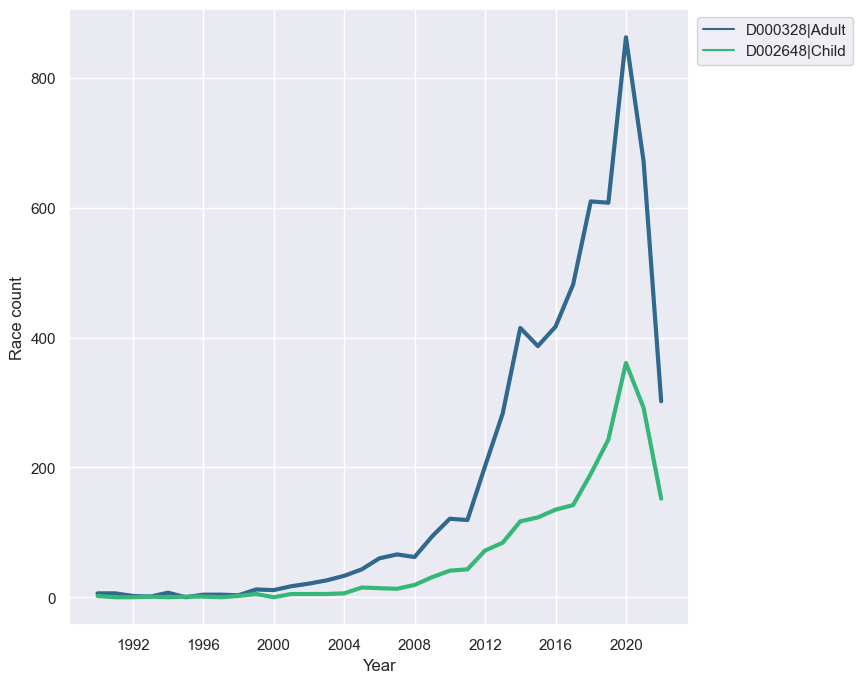

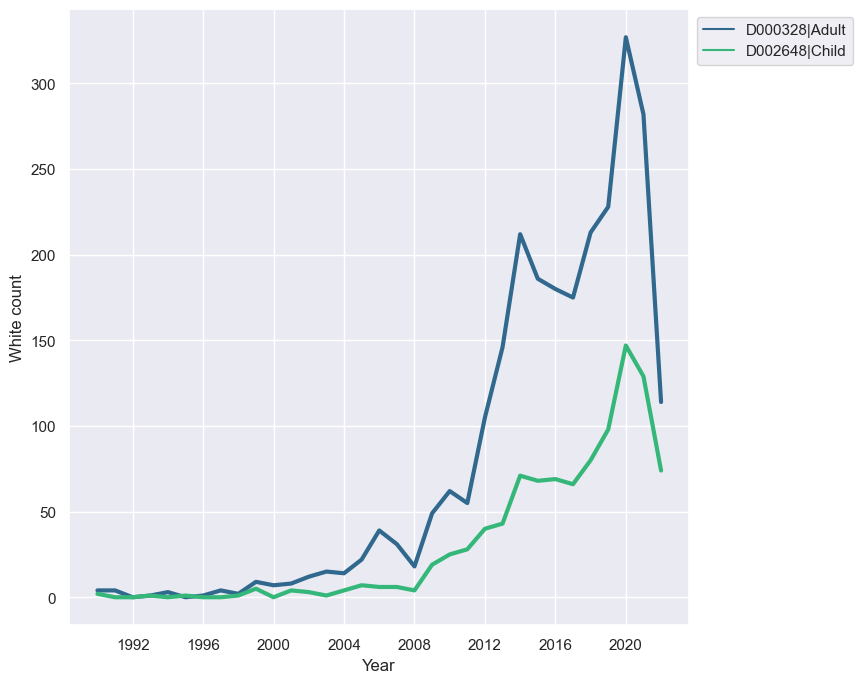

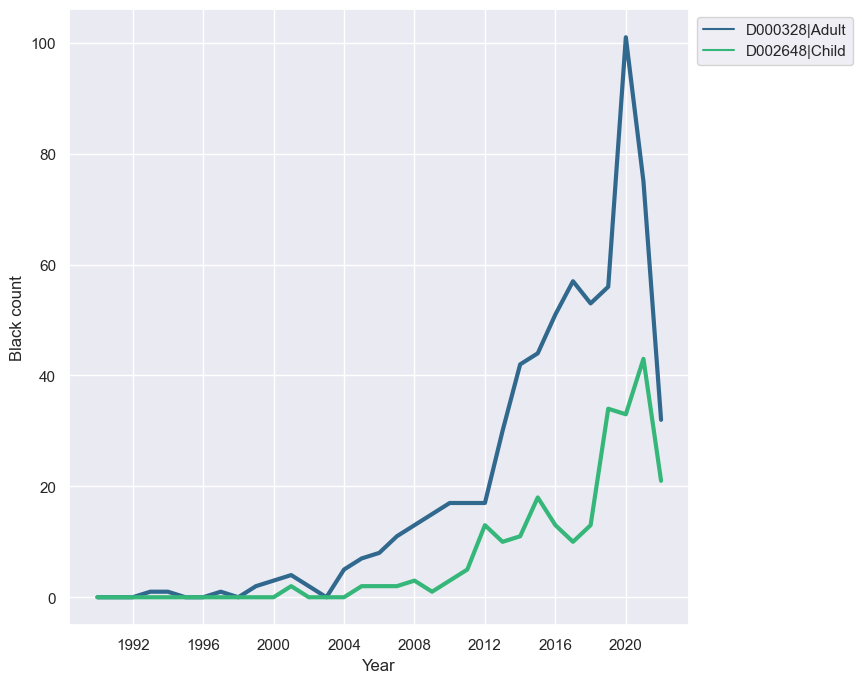

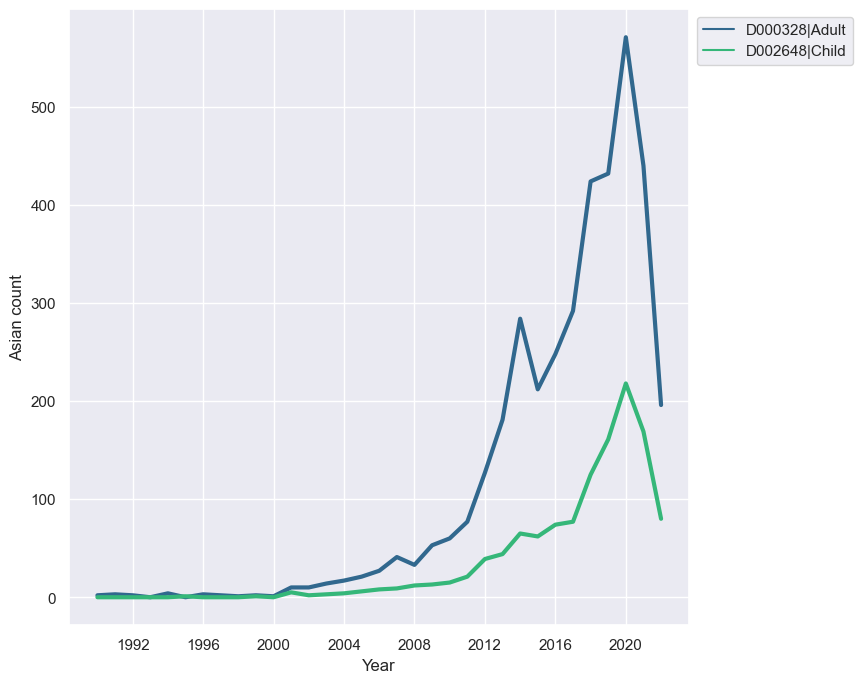

In [867]:
disease_mesh = 'D000328|Adult'
print(f'Results for {disease_mesh}')
test_df_1 = get_stats_by_mesh_df(disease_mesh)
print('='*20)

disease_mesh = 'D002648|Child'
print(f'Results for {disease_mesh}')
test_df_2 = get_stats_by_mesh_df(disease_mesh)
print('='*20)


res_df = pd.concat([test_df_1, test_df_2])
res_df.head()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'race_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Race count')
plt.xlabel('Year')
plt.show()


sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'white_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('White count')
plt.xlabel('Year')
plt.show()

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,8)})

ax = sns.lineplot(data=res_df, x ='year', y = 'black_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Black count')
plt.xlabel('Year')
plt.show()


ax = sns.lineplot(data=res_df, x ='year', y = 'asian_count',
                  hue='MESH', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Asian count')
plt.xlabel('Year')
plt.show()